# Trabajo Práctico: Predicción de lluvia en Australia.

**Materia:** Aprendizaje Automático I (IA41)

**Comisión:** C-31527

**Año académico:** 2024

**Período lectivo:** 1° cuatrimestre

**Integrantes:**
- Britos Julián Francisco
- Moresco Brisa

# Terminado

A continuación, se enlistarán las correcciones que fueron sugeridas hacer y fueron hechas, listas para ser revisadas nuevamente:
- El ploteo de la matriz de correlación luego de haber generado las variables dummies, no es muy recomendado ya que confunde su interpretación innecesariamente.
- Resta completar el análisis estadístico descriptivo con gráficos, comentarios y conclusiones.
- Realizar la imputación de nulos previo a dividir el set de datos en train y test, ¿creen que es la mejor opción? Podría generarse data leakage.
- En cuanto a la forma de hacer el split del set de datos, ¿creen que es la correcta para evitar data leakage? Se trata de un conjunto con fuerte dependencia cronológica.
- ¿Está el set de datos balanceado o no?
- Es importante agregar una gráfica de pérdida vs. iteraciones del gradiente descendente para observar que el modelo converja.
- En cuanto al cálculo de métricas, restan las correspondientes al set de entrenamiento. ¿Por qué ambas son necesarias?
- ¿Consiguió un buen fitting?

# To Do List

A continuación, se enlistarán las **correcciones** que fueron sugeridas hacer:


A continuación, se enlistarán las cuestiones **generales** que faltan realizar:

9. Implementar las soluciones con una red neuronal.
- Obtener las métricas adecuadas.
- Repetir los pasos 7 y 8 para las redes neuronales. ¿Qué diferencias hay con los modelos de regresión lineal y logística?

10. Comparación de modelos.
- Incluyan en su análisis una comparación de modelos: de todos los modelos de regresión, ¿cuál es el mejor? Escoger una métrica adecuada para poder compararlos. Lo mismo con los de clasificación.

11. MLOps
- Realizar un script app.py donde se utilice streamlit para la puesta en producción, donde el modelo para predecir debe ser el que se elija en el ítem 10.
- Se valorará incorporación de pipeline con clases y funciones que se encarguen de hacer las transformaciones de datos, aunque no es necesario.
- El script debe permitir incorporar datos en un frontend de streamlit y debe mostrar la predicción para dichos valores. Se valora incorporar manejo de errores. Se valora el trabajo realizado para mejorar el frontend de la aplicación; sin embargo es suficiente con una interfaz que sea útil.
- A su vez, se especifica el requerimiento de un script que tenga funciones para tomar datos de entrada (que estén en el mismo formato del dataset)

12. Escribir una conclusión del trabajo.

13. Preparar una defensa del trabajo práctico. La presentación de forma oral se hace sobre el notebook de trabajo y la aplicación de streamlit, en un total de 20 minutos, donde deben destacar lo que consideren más relevante, ya que no es tiempo suficiente para mostrar absolutamente todo. ¡Planificar la gestión de tiempos es parte de la calidad de la presentación del trabajo realizado! Se recomienda previa práctica.

# Librerías

In [1]:
%%capture
!pip install pandas
!pip install seaborn
!pip install -U scikit-learn
!pip install numpy
!pip install shap
!pip install --quiet optuna
!pip install tensorflow

In [1]:
import time

import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import shap

import optuna


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_classification, load_iris, load_digits
from sklearn.utils.validation import column_or_1d
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, LeaveOneOut, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, SGDRegressor, ElasticNet, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, auc

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt


# Carga de datos

### Contexto:

Este conjunto de datos contiene alrededor de 10 años de observaciones meteorológicas diarias de numerosas estaciones meteorológicas australianas.

### Contenido:

Date, Location, MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustDir, WindGustSpeed, WindDir9am, WindDir3pm, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm, Cloud9am, Cloud3pm, Temp9am, Temp3pm, RainToday, RainTomorrow, RainfallTomorrow

### Objetivo:

Tras observar los datos del día de hoy, el objetivo es predecir las variables target:
- RainFallTomorrow: cantidad de lluvia del día posterior a la observación. (Problema de **Regresión**).
- RainTomorrow: si el día siguiente llueve o no llueve. (Problema de **Clasificación**).


In [2]:
file_path= 'weatherAUS.csv'
weather_data = pd.read_csv(file_path, sep=',',engine='python')

# Análisis estadístico descriptivo

## Visualización de datos

Examinaremos los datos para un primer vistazo.

In [3]:
weather_data.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


Como podemos ver, al haber 25 columnas no nos muestra todas, por lo que deberemos realizar un paso más para verlas.

In [4]:
weather_data.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

A continuación, examinaremos qué tipos de variables son estas columnas.

In [5]:
weather_data.dtypes

Unnamed: 0            int64
Date                 object
Location             object
MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustDir          object
WindGustSpeed       float64
WindDir9am           object
WindDir3pm           object
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
RainToday            object
RainTomorrow         object
RainfallTomorrow    float64
dtype: object

Investiguemos la presencia de valores nulos en los datos.

In [6]:
weather_data.isna().sum()

Unnamed: 0              0
Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

Para concluir nuestra primera inspección, veremos las estadísticas descriptivas del conjunto de datos.

In [7]:
weather_data.describe(include='all')

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
count,145412.000000,145412,145412,143928.000000,144159.000000,142152.000000,82658.000000,75616.000000,135096,135159.000000,...,140907.000000,130351.000000,130388.000000,89542.000000,86076.000000,143646.000000,141805.000000,142152,142153,142153.000000
unique,NaN,3435,49,NaN,NaN,NaN,NaN,NaN,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN
top,NaN,2013-11-11,Canberra,NaN,NaN,NaN,NaN,NaN,W,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,NaN
freq,NaN,49,3435,NaN,NaN,NaN,NaN,NaN,9910,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110276,110281,NaN
mean,72728.184393,NaN,NaN,12.195873,23.223176,2.361516,5.468616,7.611241,NaN,40.036564,...,51.537432,1017.649277,1015.255184,4.447287,4.509770,16.992780,21.685249,NaN,NaN,2.361242
std,41990.722236,NaN,NaN,6.398018,7.118770,8.479338,4.193871,3.785612,NaN,13.607212,...,20.796720,7.107132,7.037981,2.887161,2.720306,6.488045,6.936358,NaN,NaN,8.479084
min,0.000000,NaN,NaN,-8.500000,-4.800000,0.000000,0.000000,0.000000,NaN,6.000000,...,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,NaN,NaN,0.000000
25%,36362.750000,NaN,NaN,7.600000,17.900000,0.000000,2.600000,4.800000,NaN,31.000000,...,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,NaN,NaN,0.000000
50%,72727.500000,NaN,NaN,12.000000,22.600000,0.000000,4.800000,8.400000,NaN,39.000000,...,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,NaN,NaN,0.000000
75%,109093.250000,NaN,NaN,16.900000,28.200000,0.800000,7.400000,10.600000,NaN,48.000000,...,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,NaN,NaN,0.800000


## Gráficos

### Location

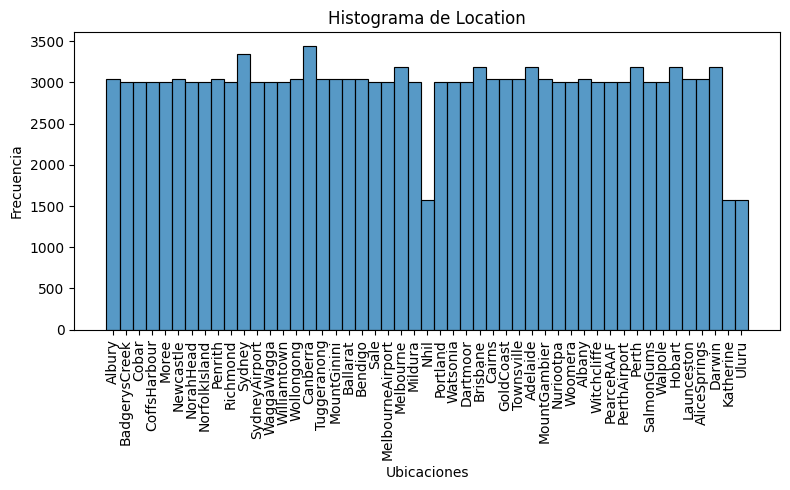

count       145412
unique          49
top       Canberra
freq          3435
Name: Location, dtype: object

In [8]:
fig, axs = plt.subplots(figsize=(8, 5))

# Histograma
sns.histplot(weather_data['Location'])
axs.set_title('Histograma de Location')
axs.set_xlabel('Ubicaciones')
axs.set_ylabel('Frecuencia')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

weather_data['Location'].describe()


**Histograma:**

El histograma muestra la distribución de las ubicaciones en los datos meteorológicos. Cada barra en el histograma representa la frecuencia de una ubicación específica dentro del conjunto de datos.

**Interpretación:**

Se observa que la frecuencia varía entre las diferentes ubicaciones, lo que indica que algunas ubicaciones tienen más observaciones que otras en el conjunto de datos.

### MinTemp

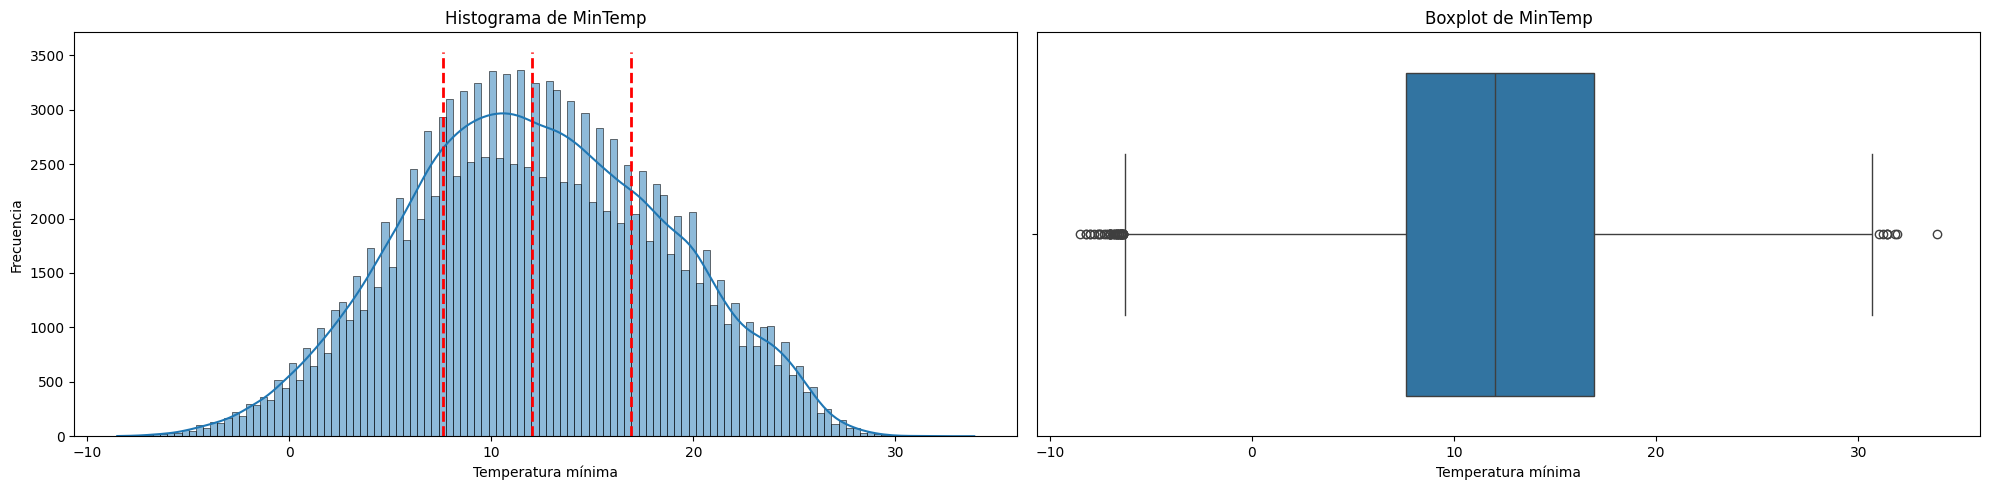

count    143928.000000
mean         12.195873
std           6.398018
min          -8.500000
25%           7.600000
50%          12.000000
75%          16.900000
max          33.900000
Name: MinTemp, dtype: float64

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['MinTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MinTemp')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['MinTemp'].quantile(0.25)
q2 = weather_data['MinTemp'].quantile(0.5)
q3 = weather_data['MinTemp'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['MinTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MinTemp')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()

weather_data['MinTemp'].describe()

**Histograma:**

El histograma muestra la distribución de la temperatura mínima en los datos meteorológicos. La curva KDE (Kernel Density Estimate) superpuesta al histograma representa una estimación suavizada de esta distribución. Se observa que la mayoría de las temperaturas mínimas se concentran alrededor de un rango específico, lo que indica una distribución con una tendencia central. Las líneas verticales rojas representan los cuartiles (Q1, Q2, Q3) de los datos.

**Boxplot:**

El boxplot proporciona un resumen estadístico de los datos de temperatura mínima. Muestra la mediana (representada por la línea horizontal dentro del recuadro), los cuartiles (Q1 y Q3, representados por los límites del recuadro) y el rango intercuartílico (IQR). No se observan valores atípicos (outliers) que se extiendan más allá de los bigotes del boxplot. Esto sugiere que los datos de temperatura mínima no presentan valores extremos significativos.

**Interpretación:**

En general, la distribución de la temperatura mínima en los datos meteorológicos presenta una tendencia central, con la mayoría de las temperaturas concentrándose alrededor de 12.00°C. La ausencia de valores atípicos indica que los datos no presentan extremos significativos en cuanto a temperaturas mínimas. La media y la mediana son cercanas, lo que sugiere que la distribución puede ser simétrica.

### MaxTemp

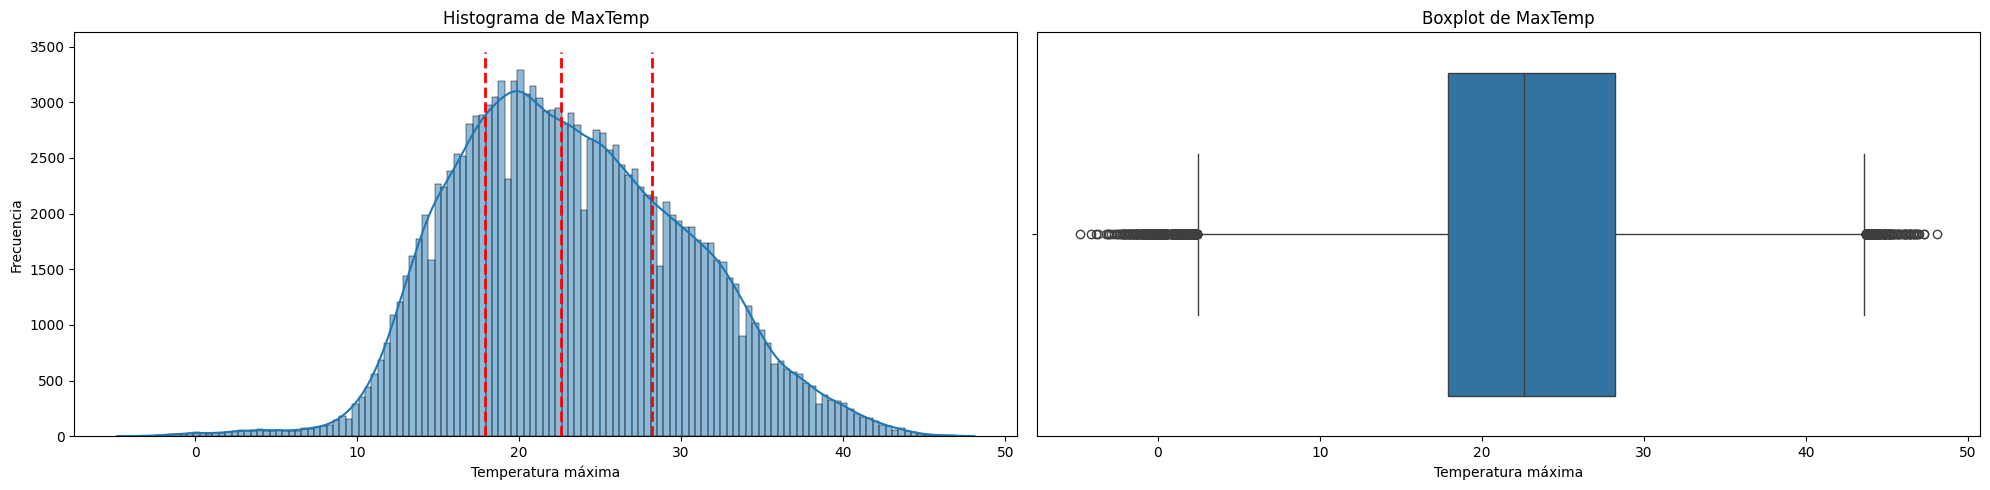

count    144159.000000
mean         23.223176
std           7.118770
min          -4.800000
25%          17.900000
50%          22.600000
75%          28.200000
max          48.100000
Name: MaxTemp, dtype: float64

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['MaxTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MaxTemp')
axs[0].set_xlabel('Temperatura máxima')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['MaxTemp'].quantile(0.25)
q2 = weather_data['MaxTemp'].quantile(0.5)
q3 = weather_data['MaxTemp'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['MaxTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MaxTemp')
axs[1].set_xlabel('Temperatura máxima')

plt.tight_layout()
plt.show()

weather_data['MaxTemp'].describe()


**Histograma:**

El histograma muestra la distribución de la temperatura máxima en los datos meteorológicos. La curva KDE (Kernel Density Estimate) superpuesta al histograma representa una estimación suavizada de esta distribución. Se observa que la mayoría de las temperaturas máximas se concentran alrededor de un rango específico, lo que indica una distribución con una tendencia central. Las líneas verticales rojas representan los cuartiles (Q1, Q2, Q3) de los datos.

**Boxplot:**

El boxplot proporciona un resumen estadístico de los datos de temperatura máxima. Muestra la mediana (representada por la línea horizontal dentro del recuadro), los cuartiles (Q1 y Q3, representados por los límites del recuadro) y el rango intercuartílico (IQR). No se observan valores atípicos (outliers) que se extiendan más allá de los bigotes del boxplot. Esto sugiere que los datos de temperatura máxima no presentan valores extremos significativos.

**Interpretación:**

En general, la distribución de la temperatura máxima en los datos meteorológicos presenta una tendencia central, con la mayoría de las temperaturas concentrándose alrededor de 22.60°C. La ausencia de valores atípicos indica que los datos no presentan extremos significativos en cuanto a temperaturas máximas. La media y la mediana son cercanas, lo que sugiere que la distribución puede ser simétrica.

### Rainfall

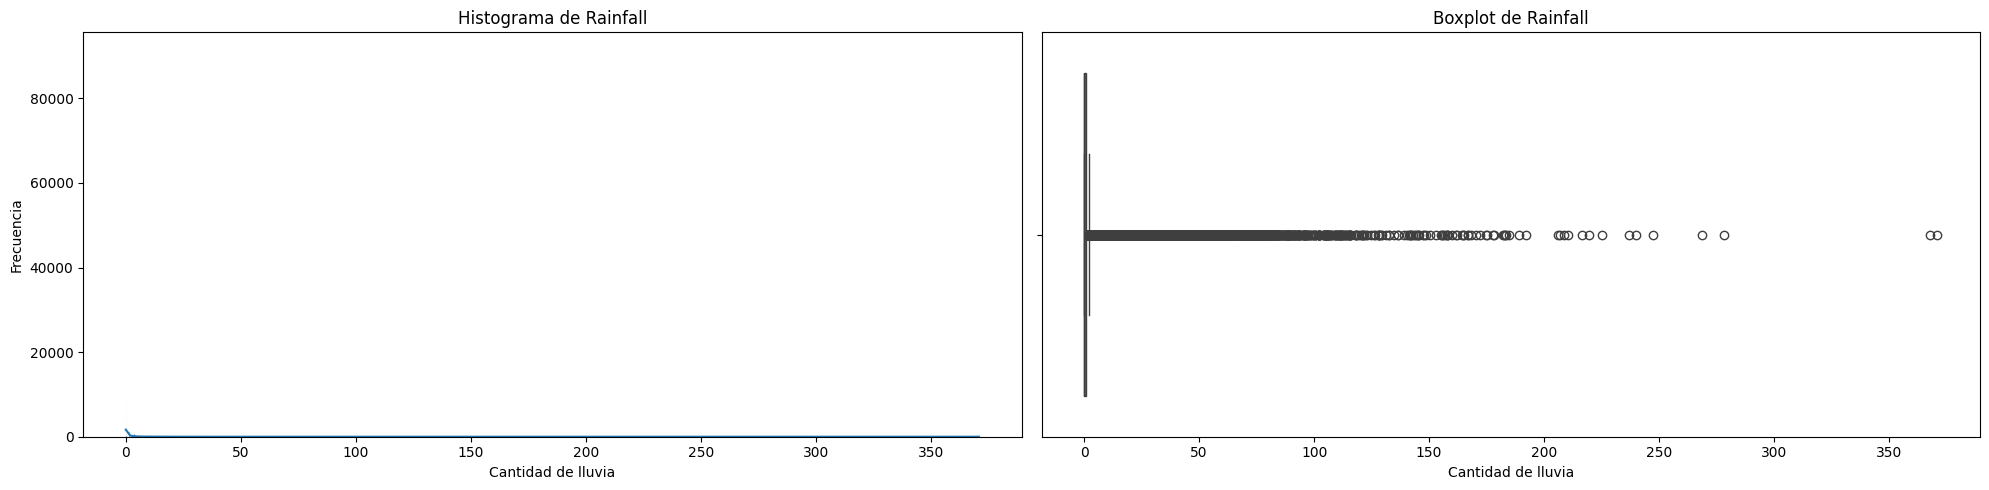

count    142152.000000
mean          2.361516
std           8.479338
min           0.000000
25%           0.000000
50%           0.000000
75%           0.800000
max         371.000000
Name: Rainfall, dtype: float64

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Cantidad de lluvia')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Cantidad de lluvia')

plt.tight_layout()
plt.show()

weather_data['Rainfall'].describe()


**Histograma:**

El histograma muestra la distribución de la cantidad de lluvia en los datos meteorológicos. La curva KDE (Kernel Density Estimate) superpuesta al histograma representa una estimación suavizada de esta distribución. Se observa que la mayoría de las cantidades de lluvia se concentran cerca de cero, lo que indica una distribución con una tendencia hacia valores bajos. Esto sugiere que la mayoría de los días no tienen lluvia o tienen una cantidad muy pequeña de lluvia.

**Boxplot:**

El boxplot proporciona un resumen estadístico de los datos de cantidad de lluvia. Muestra la mediana (representada por la línea horizontal dentro del recuadro), los cuartiles (Q1 y Q3, representados por los límites del recuadro) y el rango intercuartílico (IQR). Se observan varios valores atípicos que se extienden más allá de los bigotes del boxplot. Esto sugiere que hay algunos días con cantidades de lluvia significativamente altas.

**Interpretación:**

En general, la distribución de la cantidad de lluvia en los datos meteorológicos presenta una tendencia hacia valores bajos, con la mayoría de las cantidades de lluvia concentrándose en 0.00 mm. Sin embargo, la presencia de valores atípicos indica que hay algunos días con cantidades de lluvia significativamente altas.

### Evaporation

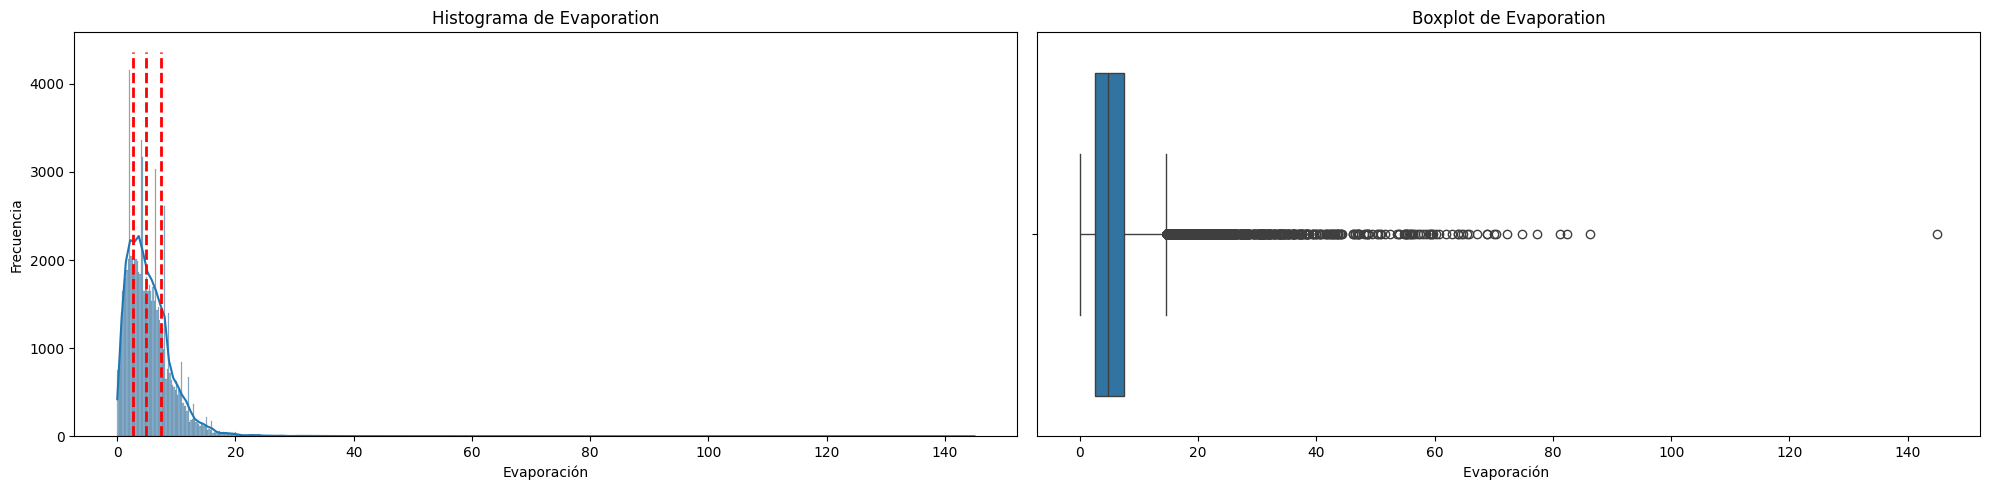

count    82658.000000
mean         5.468616
std          4.193871
min          0.000000
25%          2.600000
50%          4.800000
75%          7.400000
max        145.000000
Name: Evaporation, dtype: float64

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Evaporation'], kde=True, ax=axs[0])

# Calcular cuartiles
q1 = weather_data['Evaporation'].quantile(0.25)
q2 = weather_data['Evaporation'].quantile(0.5)
q3 = weather_data['Evaporation'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

axs[0].set_title('Histograma de Evaporation')
axs[0].set_xlabel('Evaporación')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Evaporation'], ax=axs[1])
axs[1].set_title('Boxplot de Evaporation')
axs[1].set_xlabel('Evaporación ')

plt.tight_layout()
plt.show()

weather_data['Evaporation'].describe()



**Histograma:**

El histograma muestra la distribución de la evaporación en los datos meteorológicos. La curva KDE (Kernel Density Estimate) superpuesta al histograma representa una estimación suavizada de esta distribución. Se observa que la mayoría de las temperaturas máximas se concentran alrededor de un rango específico, lo que indica una distribución con una tendencia central. Las líneas verticales rojas representan los cuartiles (Q1, Q2, Q3) de los datos.

**Boxplot:**

El boxplot proporciona un resumen estadístico de los datos de evaporación. Muestra la mediana (representada por la línea horizontal dentro del recuadro), los cuartiles (Q1 y Q3, representados por los límites del recuadro) y el rango intercuartílico (IQR). Se observan varios valores atípicos que se extienden más allá de los bigotes del boxplot. Esto sugiere que hay algunos días con niveles de evaporación significativamente altos.

**Interpretación:**

En general, la distribución de la evaporación en los datos meteorológicos presenta una tendencia central, con la mayoría de las mediciones de evaporación concentrándose en 4.8 mm. Sin embargo, la presencia de valores atípicos indica que hay algunos días con niveles de evaporación significativamente altos. La media y la mediana son cercanas, lo que sugiere que la distribución puede ser simétrica.

### Sunshine

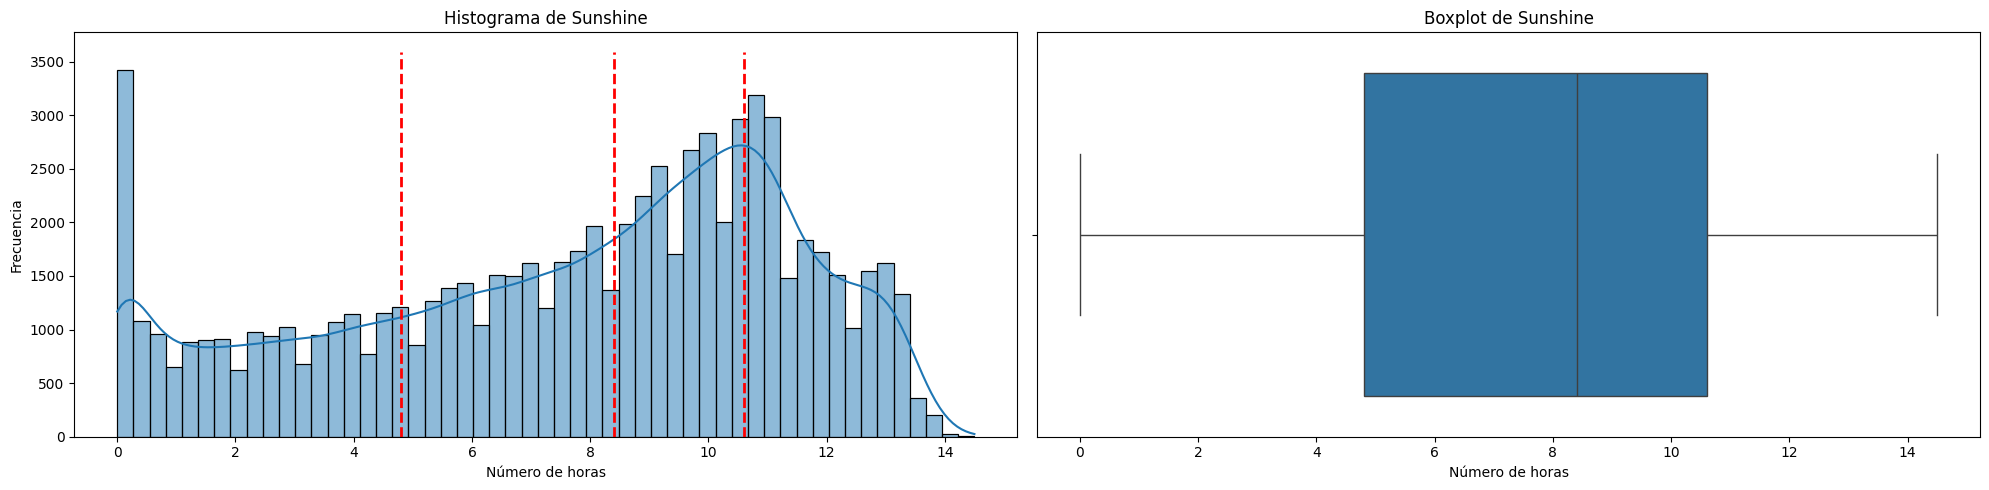

count    75616.000000
mean         7.611241
std          3.785612
min          0.000000
25%          4.800000
50%          8.400000
75%         10.600000
max         14.500000
Name: Sunshine, dtype: float64

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Sunshine'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Sunshine')
axs[0].set_xlabel('Número de horas')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Sunshine'].quantile(0.25)
q2 = weather_data['Sunshine'].quantile(0.5)
q3 = weather_data['Sunshine'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Sunshine'], ax=axs[1])
axs[1].set_title('Boxplot de Sunshine')
axs[1].set_xlabel('Número de horas')

plt.tight_layout()
plt.show()

weather_data['Sunshine'].describe()

**Histograma:**

El histograma muestra la distribución del número de horas de sol en los datos meteorológicos. La curva KDE (Kernel Density Estimate) superpuesta al histograma representa una estimación suavizada de esta distribución. Se observa que la mayoría de las mediciones de horas de sol se concentran alrededor de un rango específico, lo que indica una distribución con una tendencia central. Las líneas verticales rojas representan los cuartiles (Q1, Q2, Q3) de los datos.

**Boxplot:**

El boxplot proporciona un resumen estadístico de los datos de horas de sol. Muestra la mediana (representada por la línea horizontal dentro del recuadro), los cuartiles (Q1 y Q3, representados por los límites del recuadro) y el rango intercuartílico (IQR). No se observan valores atípicos que se extiendan más allá de los bigotes del boxplot. Esto sugiere que los datos de horas de sol no presentan valores extremos significativos.

**Interpretación:**

En general, la distribución del número de horas de sol en los datos meteorológicos presenta una tendencia central, con la mayoría de las mediciones de horas de sol concentrándose alrededor de 8.40 horas. La ausencia de valores atípicos indica que los datos no presentan extremos significativos en cuanto a horas de sol. La media y la mediana son cercanas, lo que sugiere que la distribución puede ser simétrica.

### WindGustDir

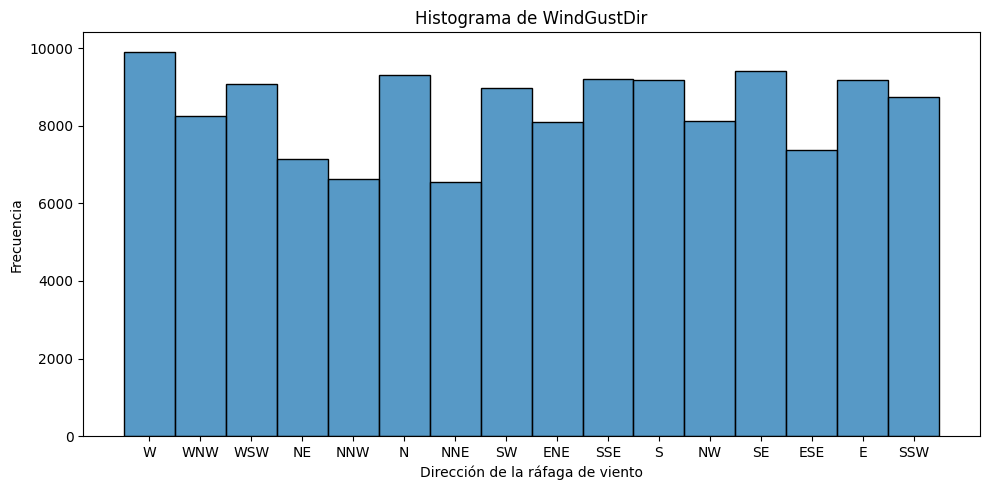

count     135096
unique        16
top            W
freq        9910
Name: WindGustDir, dtype: object

In [14]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(weather_data['WindGustDir'])
axs.set_title('Histograma de WindGustDir')
axs.set_xlabel('Dirección de la ráfaga de viento')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

weather_data['WindGustDir'].describe()

**Histograma**:

El histograma muestra la distribución de la dirección de las ráfagas de viento en los datos meteorológicos. Se observa que las direcciones de las ráfagas de viento están distribuidas entre 16 categorías diferentes, lo que indica que las ráfagas de viento pueden venir de varias direcciones.

**Interpretación:**

En general, la dirección de las ráfagas de viento en los datos meteorológicos varía entre 16 direcciones diferentes. La dirección más frecuente de las ráfagas de viento es el oeste (W), con una frecuencia de 9910.

### WindGustSpeed

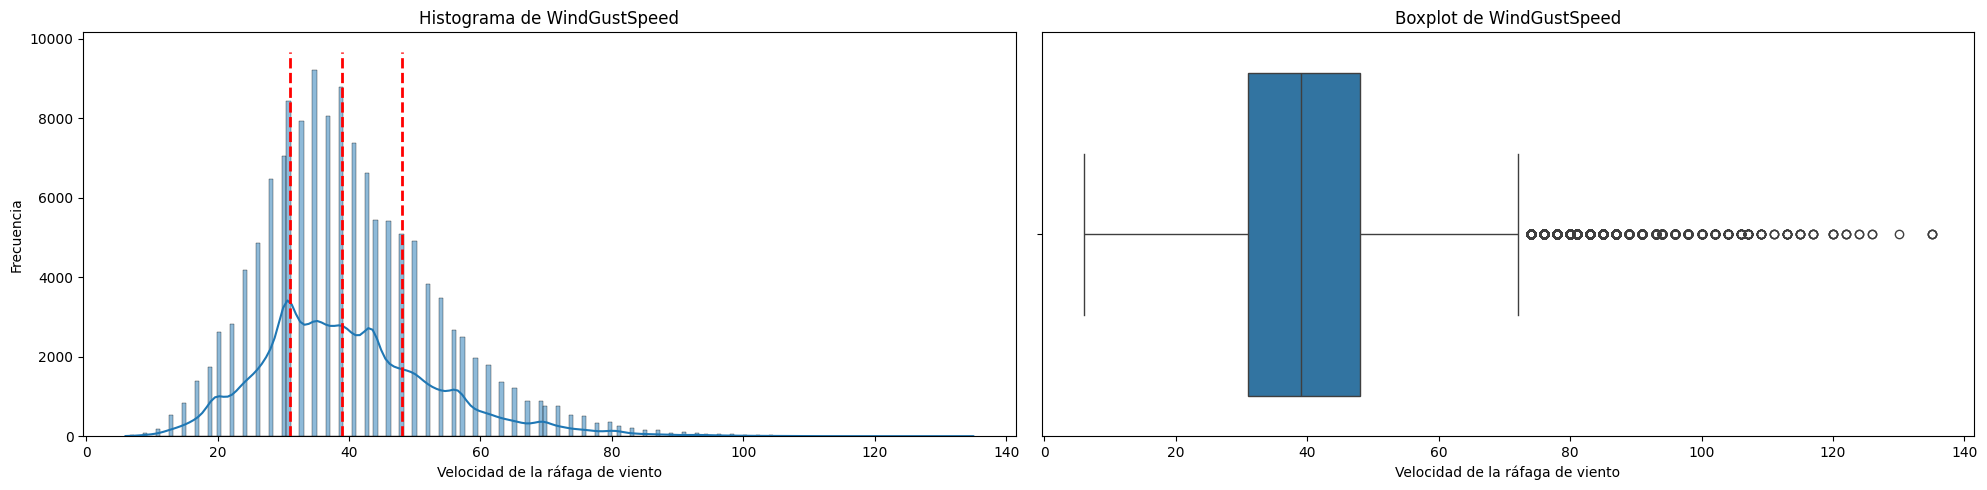

count    135159.000000
mean         40.036564
std          13.607212
min           6.000000
25%          31.000000
50%          39.000000
75%          48.000000
max         135.000000
Name: WindGustSpeed, dtype: float64

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['WindGustSpeed'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindGustSpeed')
axs[0].set_xlabel('Velocidad de la ráfaga de viento')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['WindGustSpeed'].quantile(0.25)
q2 = weather_data['WindGustSpeed'].quantile(0.5)
q3 = weather_data['WindGustSpeed'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['WindGustSpeed'], ax=axs[1])
axs[1].set_title('Boxplot de WindGustSpeed')
axs[1].set_xlabel('Velocidad de la ráfaga de viento')

plt.tight_layout()
plt.show()

weather_data['WindGustSpeed'].describe()

**Histograma:**

El histograma muestra la distribución de la velocidad de las ráfagas de viento en los datos meteorológicos. La curva KDE (Kernel Density Estimate) superpuesta al histograma representa una estimación suavizada de esta distribución. Se observa que la mayoría de las velocidades de las ráfagas de viento se concentran alrededor de un rango específico, lo que indica una distribución con una tendencia central. Las líneas verticales rojas representan los cuartiles (Q1, Q2, Q3) de los datos.

**Boxplot:**

El boxplot proporciona un resumen estadístico de los datos de velocidad de las ráfagas de viento. Muestra la mediana (representada por la línea horizontal dentro del recuadro), los cuartiles (Q1 y Q3, representados por los límites del recuadro) y el rango intercuartílico (IQR). No se observan valores atípicos que se extiendan más allá de los bigotes del boxplot. Esto sugiere que los datos de velocidad de las ráfagas de viento no presentan valores extremos significativos.

**Interpretación:**

En general, la distribución de la velocidad de las ráfagas de viento en los datos meteorológicos presenta una tendencia central, con la mayoría de las velocidades de las ráfagas de viento concentrándose alrededor de 39.00 km/h. La ausencia de valores atípicos indica que los datos no presentan extremos significativos en cuanto a velocidades de las ráfagas de viento. La media y la mediana son cercanas, lo que sugiere que la distribución puede ser simétrica.

### WindDir9am

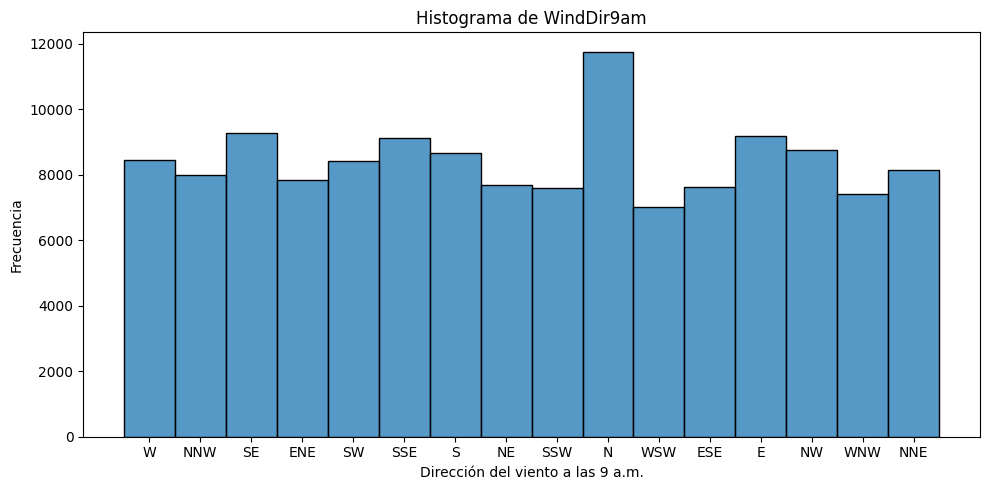

count     134850
unique        16
top            N
freq       11754
Name: WindDir9am, dtype: object

In [16]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(weather_data['WindDir9am'])
axs.set_title('Histograma de WindDir9am')
axs.set_xlabel('Dirección del viento a las 9 a.m.')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

weather_data['WindDir9am'].describe()

**Histograma:**

El histograma muestra la distribución de la dirección del viento a las 9 a.m. en los datos meteorológicos. Se observa que las direcciones del viento están distribuidas entre 16 categorías diferentes, lo que indica que el viento puede venir de varias direcciones a las 9 a.m.

**Interpretación:**

En general, la dirección del viento a las 9 a.m. en los datos meteorológicos varía entre 16 direcciones diferentes. La dirección más frecuente del viento a las 9 a.m. es el norte (N), con una frecuencia de 11754.

### WindDir3pm

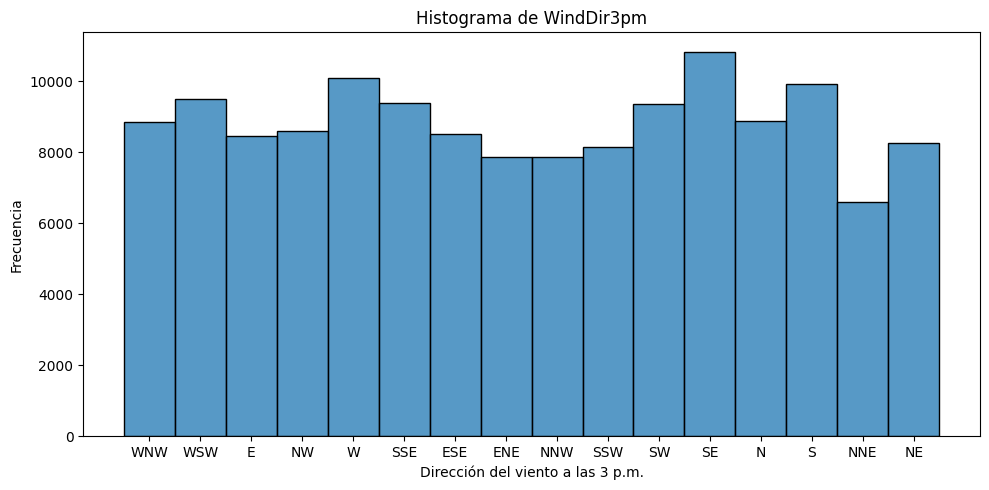

count     141186
unique        16
top           SE
freq       10837
Name: WindDir3pm, dtype: object

In [17]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(weather_data['WindDir3pm'])
axs.set_title('Histograma de WindDir3pm')
axs.set_xlabel('Dirección del viento a las 3 p.m.')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

weather_data['WindDir3pm'].describe()

**Histograma:**

El histograma muestra la distribución de la dirección del viento a las 3 p.m. en los datos meteorológicos. Se observa que las direcciones del viento están distribuidas entre 16 categorías diferentes, lo que indica que el viento puede venir de varias direcciones a las 3 p.m.

**Interpretación:**

En general, la dirección del viento a las 3 p.m. en los datos meteorológicos varía entre 16 direcciones diferentes. La dirección más frecuente del viento a las 3 p.m. es el sureste (SE), con una frecuencia de 10837.

### WindSpeed9am

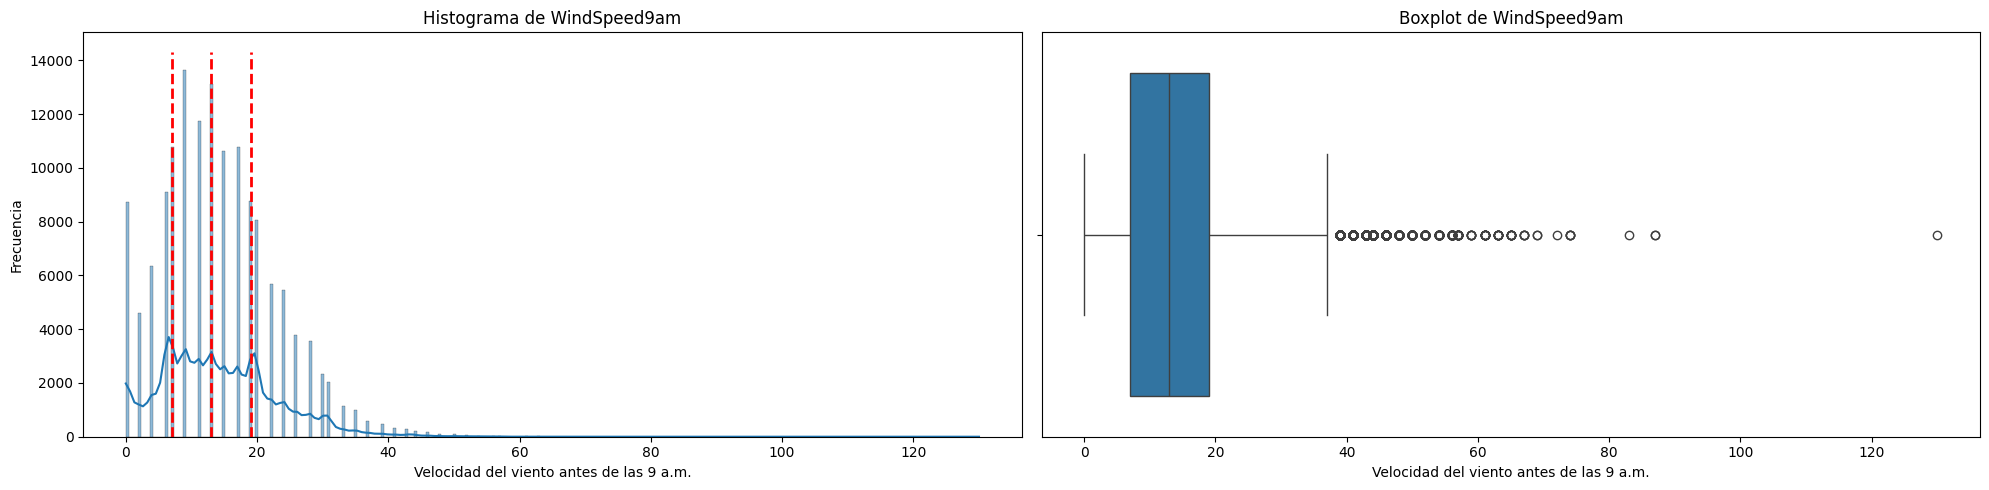

count    143645.000000
mean         14.044742
std           8.915610
min           0.000000
25%           7.000000
50%          13.000000
75%          19.000000
max         130.000000
Name: WindSpeed9am, dtype: float64

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['WindSpeed9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed9am')
axs[0].set_xlabel('Velocidad del viento antes de las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['WindSpeed9am'].quantile(0.25)
q2 = weather_data['WindSpeed9am'].quantile(0.5)
q3 = weather_data['WindSpeed9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['WindSpeed9am'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed9am')
axs[1].set_xlabel('Velocidad del viento antes de las 9 a.m.')

plt.tight_layout()
plt.show()

weather_data['WindSpeed9am'].describe()

**Histograma:**

El histograma muestra la distribución de la velocidad del viento antes de las 9 a.m. en los datos meteorológicos. La curva KDE (Kernel Density Estimate) superpuesta al histograma representa una estimación suavizada de esta distribución. Se observa que la mayoría de las velocidades del viento se concentran alrededor de un rango específico, lo que indica una distribución con una tendencia central. Las líneas verticales rojas representan los cuartiles (Q1, Q2, Q3) de los datos.

**Boxplot:**

El boxplot proporciona un resumen estadístico de los datos de velocidad del viento antes de las 9 a.m. Muestra la mediana (representada por la línea horizontal dentro del recuadro), los cuartiles (Q1 y Q3, representados por los límites del recuadro) y el rango intercuartílico (IQR). Se observan varios valores atípicos que se extienden más allá de los bigotes del boxplot. Esto sugiere que hay algunos días con niveles de viento antes de las 9 a.m. significativamente altos.

**Interpretación:**

En general, la distribución de la velocidad del viento antes de las 9 a.m. en los datos meteorológicos presenta una tendencia central, con la mayoría de las velocidades del viento concentrándose alrededor de 13.00 km/h. Sin embargo, la presencia de valores atípicos indica que hay algunos días con niveles de la velocidades del viento antes de las 9 a.m. significativamente altos. La media y la mediana son cercanas, lo que sugiere que la distribución puede ser simétrica.

### WindSpeed3pm

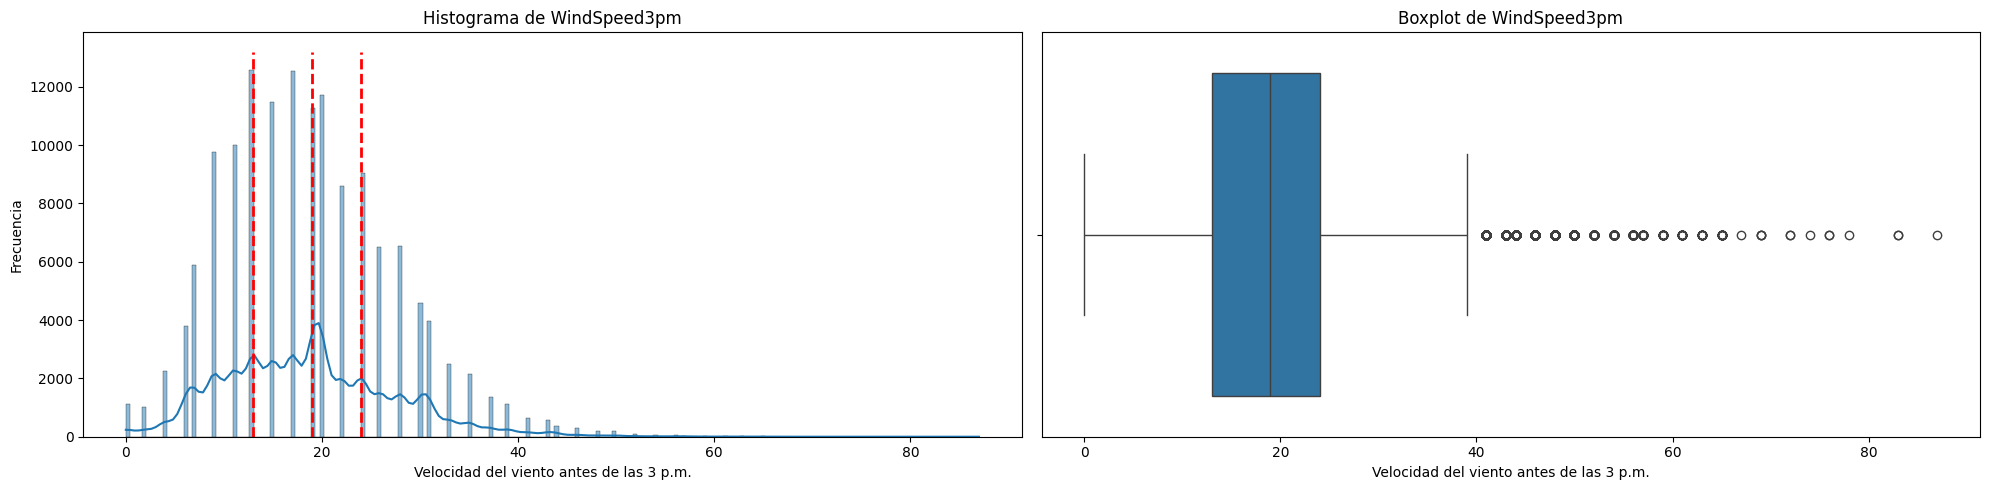

count    142351.000000
mean         18.663164
std           8.810276
min           0.000000
25%          13.000000
50%          19.000000
75%          24.000000
max          87.000000
Name: WindSpeed3pm, dtype: float64

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['WindSpeed3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed3pm')
axs[0].set_xlabel('Velocidad del viento antes de las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['WindSpeed3pm'].quantile(0.25)
q2 = weather_data['WindSpeed3pm'].quantile(0.5)
q3 = weather_data['WindSpeed3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['WindSpeed3pm'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed3pm')
axs[1].set_xlabel('Velocidad del viento antes de las 3 p.m.')

plt.tight_layout()
plt.show()

weather_data['WindSpeed3pm'].describe()

**Histograma:**

El histograma muestra la distribución de la velocidad del viento antes de las 3 p.m. en los datos meteorológicos. La curva KDE (Kernel Density Estimate) superpuesta al histograma representa una estimación suavizada de esta distribución. Se observa que la mayoría de las velocidades del viento se concentran alrededor de un rango específico, lo que indica una distribución con una tendencia central. Las líneas verticales rojas representan los cuartiles (Q1, Q2, Q3) de los datos.

**Boxplot:**

El boxplot proporciona un resumen estadístico de los datos de velocidad del viento antes de las 3 p.m. Muestra la mediana (representada por la línea horizontal dentro del recuadro), los cuartiles (Q1 y Q3, representados por los límites del recuadro) y el rango intercuartílico (IQR). Se observan varios valores atípicos que se extienden más allá de los bigotes del boxplot. Esto sugiere que hay algunos días con niveles de viento antes de las 3 p.m. significativamente altos.

**Interpretación:**

En general, la distribución de la velocidad del viento antes de las 3 p.m. en los datos meteorológicos presenta una tendencia central, con la mayoría de las velocidades del viento concentrándose alrededor de 19.00 km/h. Sin embargo, la presencia de valores atípicos indica que hay algunos días con niveles de la velocidades del viento antes de las 3 p.m. significativamente altos. La media y la mediana son cercanas, lo que sugiere que la distribución puede ser simétrica.

### Humidity9am

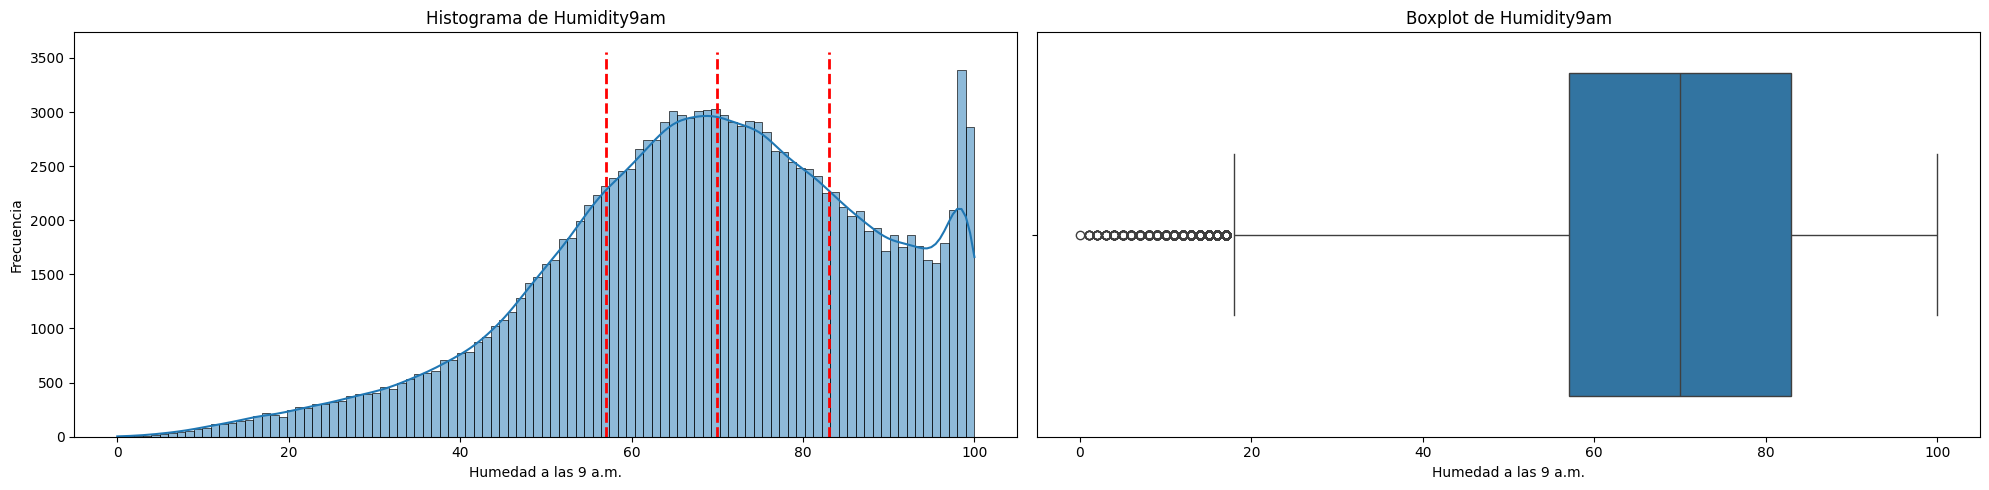

count    142759.000000
mean         68.877290
std          19.029576
min           0.000000
25%          57.000000
50%          70.000000
75%          83.000000
max         100.000000
Name: Humidity9am, dtype: float64

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Humidity9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Humidity9am')
axs[0].set_xlabel('Humedad a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Humidity9am'].quantile(0.25)
q2 = weather_data['Humidity9am'].quantile(0.5)
q3 = weather_data['Humidity9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Humidity9am'], ax=axs[1])
axs[1].set_title('Boxplot de Humidity9am')
axs[1].set_xlabel('Humedad a las 9 a.m.')

plt.tight_layout()
plt.show()

weather_data['Humidity9am'].describe()

**Histograma:**

El histograma muestra la distribución de la velocidad de la humedad a las 9 a.m. en los datos meteorológicos. La curva KDE (Kernel Density Estimate) superpuesta al histograma representa una estimación suavizada de esta distribución. Se observa que la mayoría de la humedad a las 9 a.m. se concentran alrededor de un rango específico, lo que indica una distribución con una tendencia central. Las líneas verticales rojas representan los cuartiles (Q1, Q2, Q3) de los datos.

**Boxplot:**

El boxplot proporciona un resumen estadístico de los datos de velocidad de la humedad a las 9 a.m. Muestra la mediana (representada por la línea horizontal dentro del recuadro), los cuartiles (Q1 y Q3, representados por los límites del recuadro) y el rango intercuartílico (IQR). No se observan valores atípicos que se extiendan más allá de los bigotes del boxplot. Esto sugiere que los datos de la humedad a las 9 a.m no presentan valores extremos significativos.

**Interpretación:**

En general, la distribución de la velocidad de la humedad a las 9 a.m. en los datos meteorológicos presenta una tendencia central, con la mayoría de las velocidades del viento concentrándose alrededor de 70 Hr. La ausencia de valores atípicos indica que los datos no presentan extremos significativos en cuanto a velocidades de la humedad a las 9 a.m. La media y la mediana son cercanas, lo que sugiere que la distribución puede ser simétrica.

### Humidity3pm

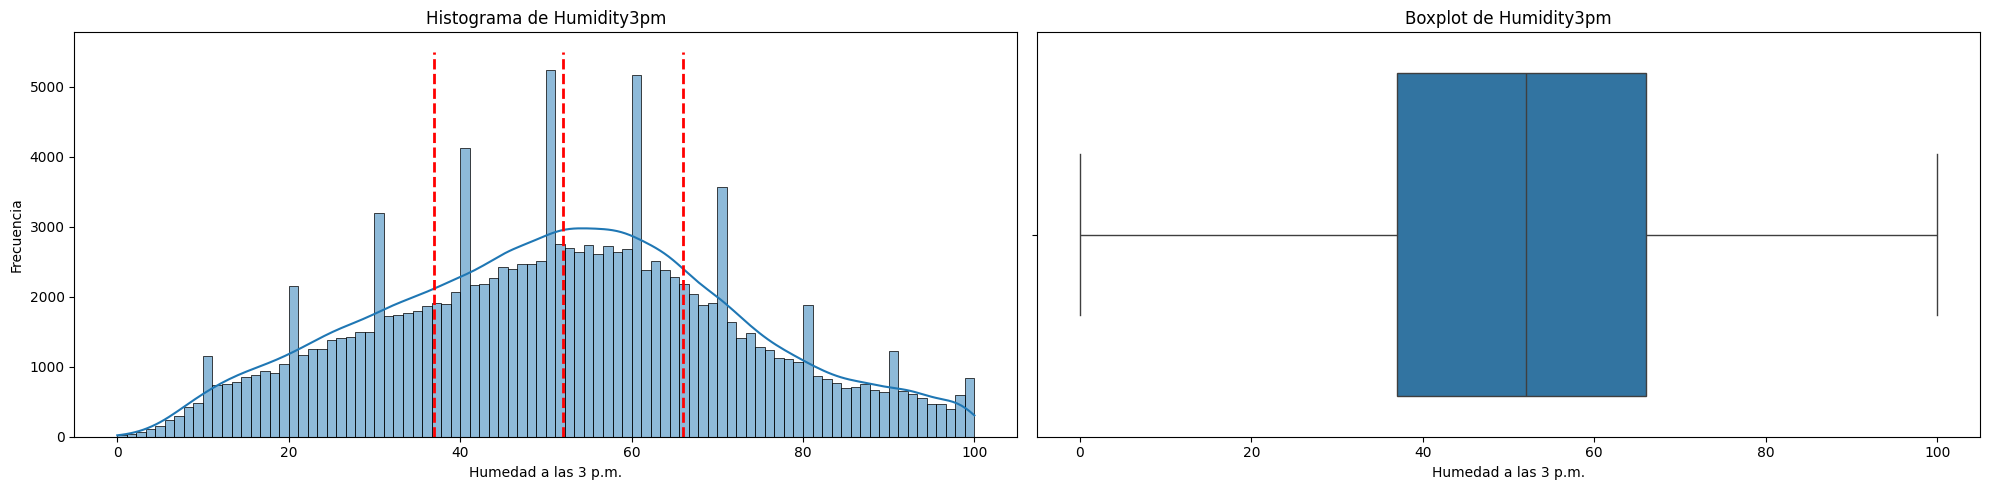

count    140907.000000
mean         51.537432
std          20.796720
min           0.000000
25%          37.000000
50%          52.000000
75%          66.000000
max         100.000000
Name: Humidity3pm, dtype: float64

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Humidity3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Humidity3pm')
axs[0].set_xlabel('Humedad a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Humidity3pm'].quantile(0.25)
q2 = weather_data['Humidity3pm'].quantile(0.5)
q3 = weather_data['Humidity3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Humidity3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Humidity3pm')
axs[1].set_xlabel('Humedad a las 3 p.m.')

plt.tight_layout()
plt.show()

weather_data['Humidity3pm'].describe()

**Histograma:**

El histograma muestra la distribución de la velocidad de la humedad a las 3 p.m. en los datos meteorológicos. La curva KDE (Kernel Density Estimate) superpuesta al histograma representa una estimación suavizada de esta distribución. Se observa que la mayoría de la humedad a las 3 p.m. se concentran alrededor de un rango específico, lo que indica una distribución con una tendencia central. Las líneas verticales rojas representan los cuartiles (Q1, Q2, Q3) de los datos.

**Boxplot:**

El boxplot proporciona un resumen estadístico de los datos de la humedad a las 3 p.m. Muestra la mediana (representada por la línea horizontal dentro del recuadro), los cuartiles (Q1 y Q3, representados por los límites del recuadro) y el rango intercuartílico (IQR). No se observan valores atípicos que se extiendan más allá de los bigotes del boxplot. Esto sugiere que los datos de la humedad a las 3 p.m. no presentan valores extremos significativos.

**Interpretación:**

En general, la distribución de la humedad a las 3 p.m. en los datos meteorológicos presenta una tendencia central, con la mayoría de la humedad a las 3 p.m. concentrándose alrededor de 52 Hr. La ausencia de valores atípicos indica que los datos no presentan extremos significativos en cuanto a la humedad a las 3 p.m. La media y la mediana son cercanas, lo que sugiere que la distribución puede ser simétrica.

### Pressure9am

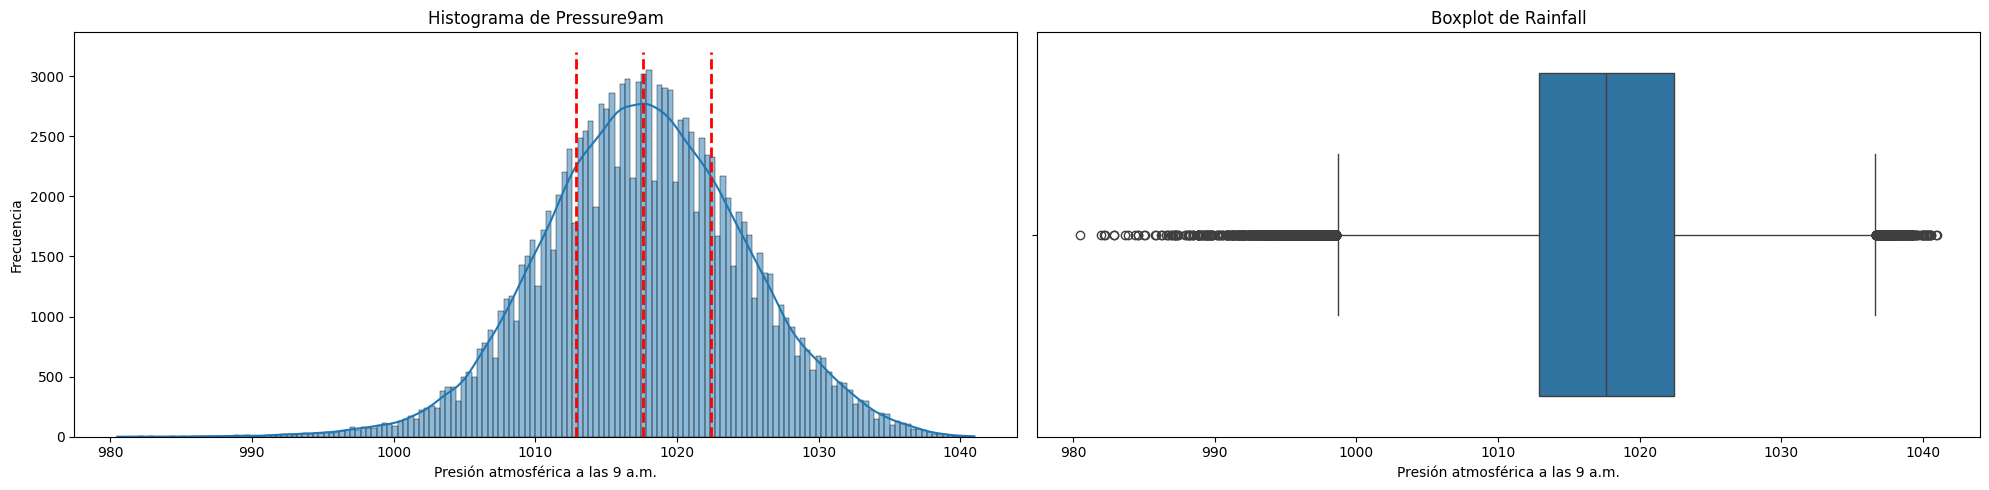

count    130351.000000
mean       1017.649277
std           7.107132
min         980.500000
25%        1012.900000
50%        1017.600000
75%        1022.400000
max        1041.000000
Name: Pressure9am, dtype: float64

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Pressure9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Pressure9am')
axs[0].set_xlabel('Presión atmosférica a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Pressure9am'].quantile(0.25)
q2 = weather_data['Pressure9am'].quantile(0.5)
q3 = weather_data['Pressure9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Pressure9am'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Presión atmosférica a las 9 a.m.')

plt.tight_layout()
plt.show()

weather_data['Pressure9am'].describe()

**Histograma:**

El histograma muestra la distribución de la velocidad de la presión atmosférica a las 9 a.m. en los datos meteorológicos. La curva KDE (Kernel Density Estimate) superpuesta al histograma representa una estimación suavizada de esta distribución. Se observa que la mayoría de la presión atmosférica a las 9 a.m. se concentran alrededor de un rango específico, lo que indica una distribución con una tendencia central. Las líneas verticales rojas representan los cuartiles (Q1, Q2, Q3) de los datos.

**Boxplot:**

El boxplot proporciona un resumen estadístico de los datos de la presión atmosférica a las 9 a.m. Muestra la mediana (representada por la línea horizontal dentro del recuadro), los cuartiles (Q1 y Q3, representados por los límites del recuadro) y el rango intercuartílico (IQR). No se observan valores atípicos que se extiendan más allá de los bigotes del boxplot. Esto sugiere que los datos de la presión atmosférica a las 9 a.m. no presentan valores extremos significativos.

**Interpretación:**

En general, la distribución de la presión atmosférica a las 9 a.m. en los datos meteorológicos presenta una tendencia central, con la mayoría de la presión atmosférica a las 9 a.m. concentrándose alrededor de 1017.6 hPa. La ausencia de valores atípicos indica que los datos no presentan extremos significativos en cuanto a la presión atmosférica a las 9 a.m. La media y la mediana son cercanas, lo que sugiere que la distribución puede ser simétrica.

### Pressure3pm

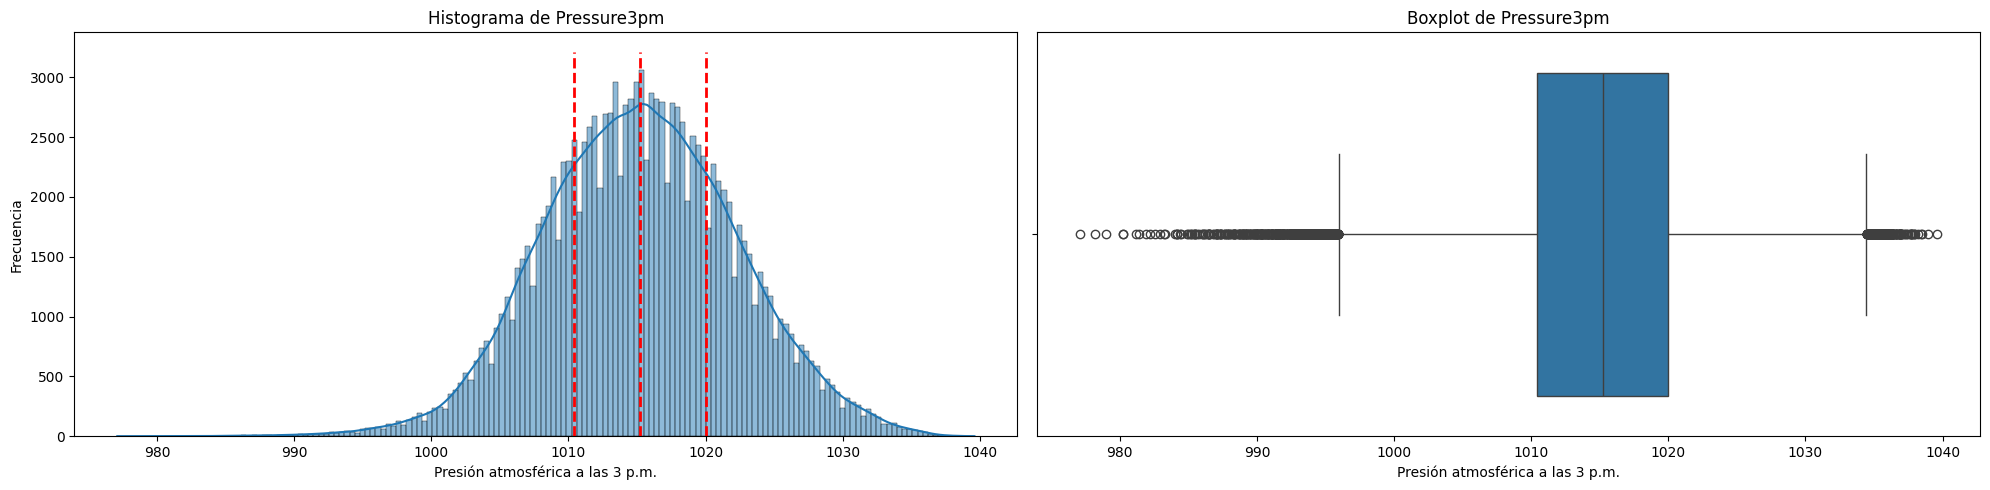

count    130388.000000
mean       1015.255184
std           7.037981
min         977.100000
25%        1010.400000
50%        1015.200000
75%        1020.000000
max        1039.600000
Name: Pressure3pm, dtype: float64

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Pressure3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Pressure3pm')
axs[0].set_xlabel('Presión atmosférica a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Pressure3pm'].quantile(0.25)
q2 = weather_data['Pressure3pm'].quantile(0.5)
q3 = weather_data['Pressure3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Pressure3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Pressure3pm')
axs[1].set_xlabel('Presión atmosférica a las 3 p.m.')

plt.tight_layout()
plt.show()

weather_data['Pressure3pm'].describe()

**Histograma:**

El histograma muestra la distribución de la velocidad de la presión atmosférica a las 3 p.m. en los datos meteorológicos. La curva KDE (Kernel Density Estimate) superpuesta al histograma representa una estimación suavizada de esta distribución. Se observa que la mayoría de la presión atmosférica a las 3 p.m. se concentran alrededor de un rango específico, lo que indica una distribución con una tendencia central. Las líneas verticales rojas representan los cuartiles (Q1, Q2, Q3) de los datos.

**Boxplot:**

El boxplot proporciona un resumen estadístico de los datos de la presión atmosférica a las 3 p.m. Muestra la mediana (representada por la línea horizontal dentro del recuadro), los cuartiles (Q1 y Q3, representados por los límites del recuadro) y el rango intercuartílico (IQR). No se observan valores atípicos que se extiendan más allá de los bigotes del boxplot. Esto sugiere que los datos de la presión atmosférica a las 3 p.m. no presentan valores extremos significativos.

**Interpretación:**

En general, la distribución de la presión atmosférica a las 3 p.m. en los datos meteorológicos presenta una tendencia central, con la mayoría de la presión atmosférica a las 3 p.m. concentrándose alrededor de 1015.2 hPa. La ausencia de valores atípicos indica que los datos no presentan extremos significativos en cuanto a la presión atmosférica a las 3 p.m. La media y la mediana son cercanas, lo que sugiere que la distribución puede ser simétrica.

### Cloud9am

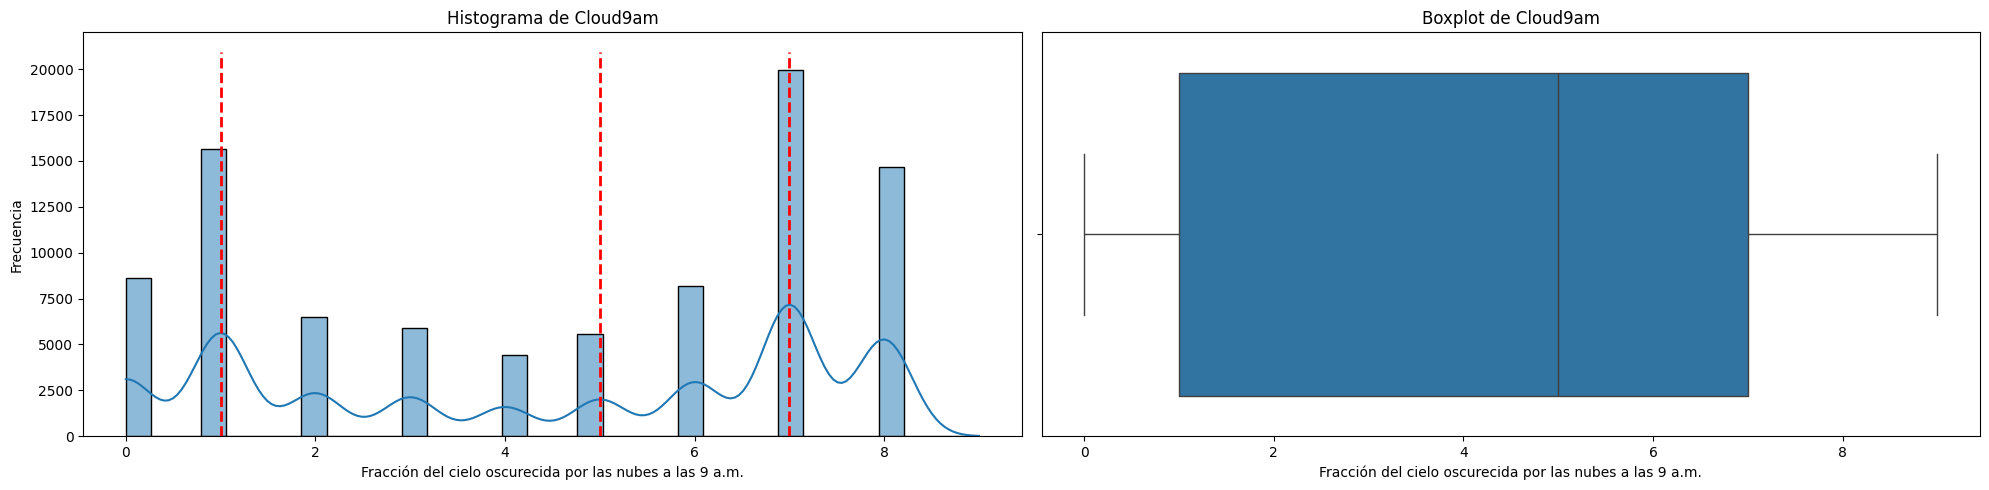

count    89542.000000
mean         4.447287
std          2.887161
min          0.000000
25%          1.000000
50%          5.000000
75%          7.000000
max          9.000000
Name: Cloud9am, dtype: float64

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Cloud9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Cloud9am')
axs[0].set_xlabel('Fracción del cielo oscurecida por las nubes a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Cloud9am'].quantile(0.25)
q2 = weather_data['Cloud9am'].quantile(0.5)
q3 = weather_data['Cloud9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Cloud9am'], ax=axs[1])
axs[1].set_title('Boxplot de Cloud9am')
axs[1].set_xlabel('Fracción del cielo oscurecida por las nubes a las 9 a.m.')

plt.tight_layout()
plt.show()

weather_data['Cloud9am'].describe()

**Histograma:**

El histograma muestra la distribución de la velocidad de la fracción del cielo oscurecida por las nubes a las 9 a.m. en los datos meteorológicos. La curva KDE (Kernel Density Estimate) superpuesta al histograma representa una estimación suavizada de esta distribución. Se observa que la mayoría de la fracción del cielo oscurecida por las nubes a las 9 a.m. se concentran alrededor de un rango específico, lo que indica una distribución con una tendencia central. Las líneas verticales rojas representan los cuartiles (Q1, Q2, Q3) de los datos.

**Boxplot:**

El boxplot proporciona un resumen estadístico de los datos de la fracción del cielo oscurecida por las nubes a las 9 a.m. Muestra la mediana (representada por la línea horizontal dentro del recuadro), los cuartiles (Q1 y Q3, representados por los límites del recuadro) y el rango intercuartílico (IQR). No se observan valores atípicos que se extiendan más allá de los bigotes del boxplot. Esto sugiere que los datos de la fracción del cielo oscurecida por las nubes a las 9 a.m. no presentan valores extremos significativos.

**Interpretación:**

En general, la distribución de la fracción del cielo oscurecida por las nubes a las 9 a.m. en los datos meteorológicos presenta una tendencia central, con la mayoría de la fracción del cielo oscurecida por las nubes a las 9 a.m. concentrándose alrededor de 5 oktas (octavos). La ausencia de valores atípicos indica que los datos no presentan extremos significativos en cuanto a la fracción del cielo oscurecida por las nubes a las 9 a.m. La media y la mediana son cercanas, lo que sugiere que la distribución puede ser simétrica.

### Cloud3pm

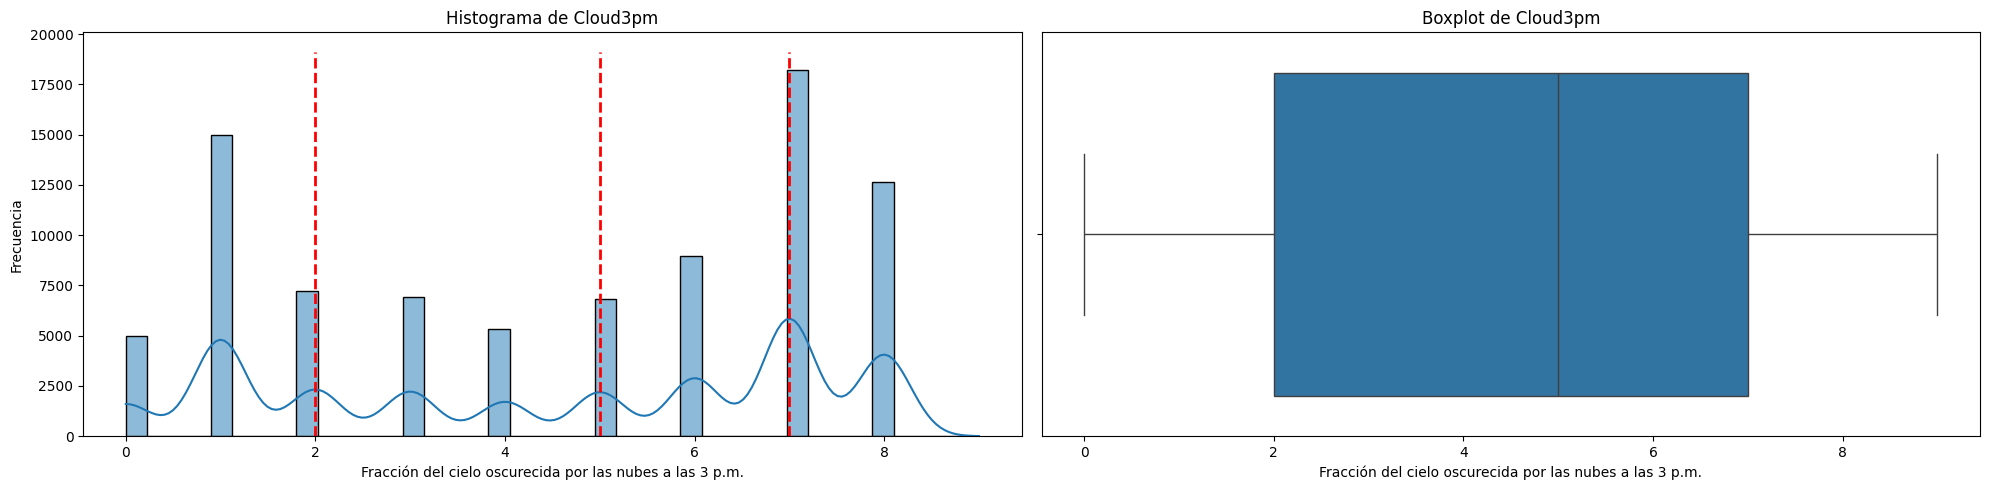

count    86076.000000
mean         4.509770
std          2.720306
min          0.000000
25%          2.000000
50%          5.000000
75%          7.000000
max          9.000000
Name: Cloud3pm, dtype: float64

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Cloud3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Cloud3pm')
axs[0].set_xlabel('Fracción del cielo oscurecida por las nubes a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Cloud3pm'].quantile(0.25)
q2 = weather_data['Cloud3pm'].quantile(0.5)
q3 = weather_data['Cloud3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Cloud3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Cloud3pm')
axs[1].set_xlabel('Fracción del cielo oscurecida por las nubes a las 3 p.m.')

plt.tight_layout()
plt.show()

weather_data['Cloud3pm'].describe()

**Histograma:**

El histograma muestra la distribución de la velocidad de la fracción del cielo oscurecida por las nubes a las 3 p.m. en los datos meteorológicos. La curva KDE (Kernel Density Estimate) superpuesta al histograma representa una estimación suavizada de esta distribución. Se observa que la mayoría de la fracción del cielo oscurecida por las nubes a las 3 p.m. se concentran alrededor de un rango específico, lo que indica una distribución con una tendencia central. Las líneas verticales rojas representan los cuartiles (Q1, Q2, Q3) de los datos.

**Boxplot:**

El boxplot proporciona un resumen estadístico de los datos de la fracción del cielo oscurecida por las nubes a las 3 p.m. Muestra la mediana (representada por la línea horizontal dentro del recuadro), los cuartiles (Q1 y Q3, representados por los límites del recuadro) y el rango intercuartílico (IQR). No se observan valores atípicos que se extiendan más allá de los bigotes del boxplot. Esto sugiere que los datos de la fracción del cielo oscurecida por las nubes a las 3 p.m. no presentan valores extremos significativos.

**Interpretación:**

En general, la distribución de la fracción del cielo oscurecida por las nubes a las 3 p.m. en los datos meteorológicos presenta una tendencia central, con la mayoría de la fracción del cielo oscurecida por las nubes a las 3 p.m. concentrándose alrededor de 5 oktas (octavos). La ausencia de valores atípicos indica que los datos no presentan extremos significativos en cuanto a la fracción del cielo oscurecida por las nubes a las 3 p.m. La media y la mediana son cercanas, lo que sugiere que la distribución puede ser simétrica.

### Temp9am

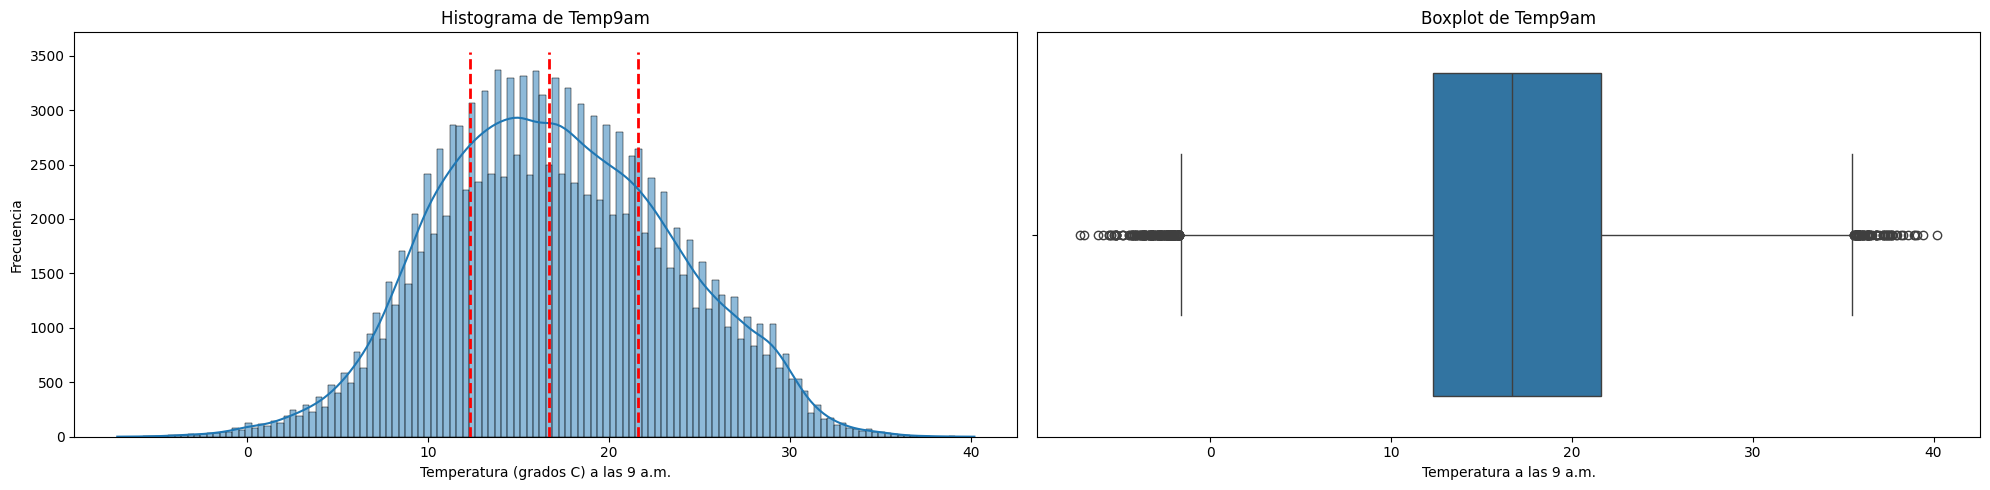

count    143646.000000
mean         16.992780
std           6.488045
min          -7.200000
25%          12.300000
50%          16.700000
75%          21.600000
max          40.200000
Name: Temp9am, dtype: float64

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Temp9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Temp9am')
axs[0].set_xlabel('Temperatura (grados C) a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Temp9am'].quantile(0.25)
q2 = weather_data['Temp9am'].quantile(0.5)
q3 = weather_data['Temp9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Temp9am'], ax=axs[1])
axs[1].set_title('Boxplot de Temp9am')
axs[1].set_xlabel('Temperatura a las 9 a.m.')

plt.tight_layout()
plt.show()

weather_data['Temp9am'].describe()

**Histograma:**

El histograma muestra la distribución de la velocidad de la temperatura a las 9 a.m. en los datos meteorológicos. La curva KDE (Kernel Density Estimate) superpuesta al histograma representa una estimación suavizada de esta distribución. Se observa que la mayoría de la temperatura a las 9 a.m. se concentran alrededor de un rango específico, lo que indica una distribución con una tendencia central. Las líneas verticales rojas representan los cuartiles (Q1, Q2, Q3) de los datos.

**Boxplot:**

El boxplot proporciona un resumen estadístico de los datos de la temperatura a las 9 a.m. Muestra la mediana (representada por la línea horizontal dentro del recuadro), los cuartiles (Q1 y Q3, representados por los límites del recuadro) y el rango intercuartílico (IQR). No se observan valores atípicos que se extiendan más allá de los bigotes del boxplot. Esto sugiere que los datos de la temperatura a las 9 a.m. no presentan valores extremos significativos.

**Interpretación:**

En general, la distribución de la temperatura a las 9 a.m. en los datos meteorológicos presenta una tendencia central, con la mayoría de la temperatura a las 9 a.m. concentrándose alrededor de 16.7 °C. La ausencia de valores atípicos indica que los datos no presentan extremos significativos en cuanto a la temperatura a las 9 a.m. La media y la mediana son cercanas, lo que sugiere que la distribución puede ser simétrica.

### Temp3pm

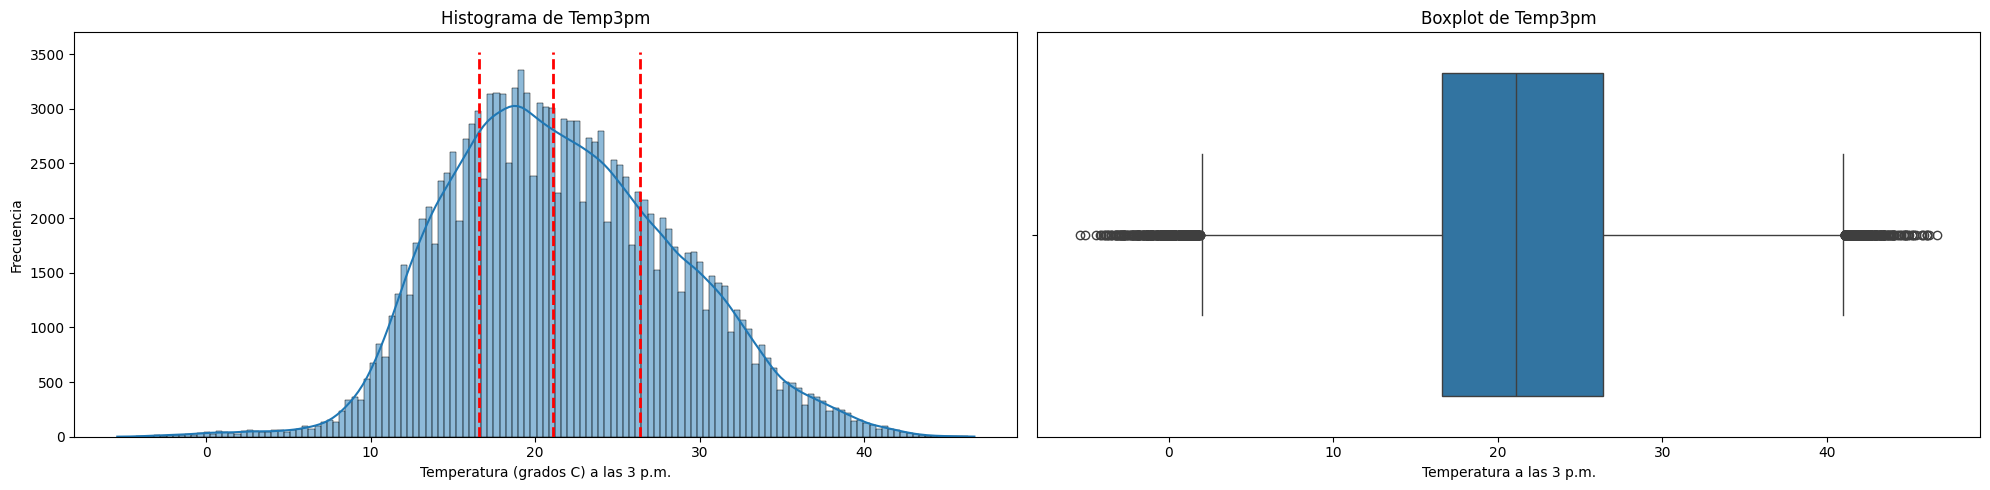

count    141805.000000
mean         21.685249
std           6.936358
min          -5.400000
25%          16.600000
50%          21.100000
75%          26.400000
max          46.700000
Name: Temp3pm, dtype: float64

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))


# Histograma
sns.histplot(weather_data['Temp3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Temp3pm')
axs[0].set_xlabel('Temperatura (grados C) a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Temp3pm'].quantile(0.25)
q2 = weather_data['Temp3pm'].quantile(0.5)
q3 = weather_data['Temp3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Temp3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Temp3pm')
axs[1].set_xlabel('Temperatura a las 3 p.m.')

plt.tight_layout()
plt.show()

weather_data['Temp3pm'].describe()

**Histograma:**

El histograma muestra la distribución de la velocidad de la temperatura a las 3 p.m. en los datos meteorológicos. La curva KDE (Kernel Density Estimate) superpuesta al histograma representa una estimación suavizada de esta distribución. Se observa que la mayoría de la temperatura a las 3 p.m. se concentran alrededor de un rango específico, lo que indica una distribución con una tendencia central. Las líneas verticales rojas representan los cuartiles (Q1, Q2, Q3) de los datos.

**Boxplot:**

El boxplot proporciona un resumen estadístico de los datos de la temperatura a las 3 p.m. Muestra la mediana (representada por la línea horizontal dentro del recuadro), los cuartiles (Q1 y Q3, representados por los límites del recuadro) y el rango intercuartílico (IQR). No se observan valores atípicos que se extiendan más allá de los bigotes del boxplot. Esto sugiere que los datos de la temperatura a las 3 p.m. no presentan valores extremos significativos.

**Interpretación:**

En general, la distribución de la temperatura a las 3 p.m. en los datos meteorológicos presenta una tendencia central, con la mayoría de la temperatura a las 3 p.m. concentrándose alrededor de 21.1 °C. La ausencia de valores atípicos indica que los datos no presentan extremos significativos en cuanto a la temperatura a las 3 p.m. La media y la mediana son cercanas, lo que sugiere que la distribución puede ser simétrica.

### RainToday

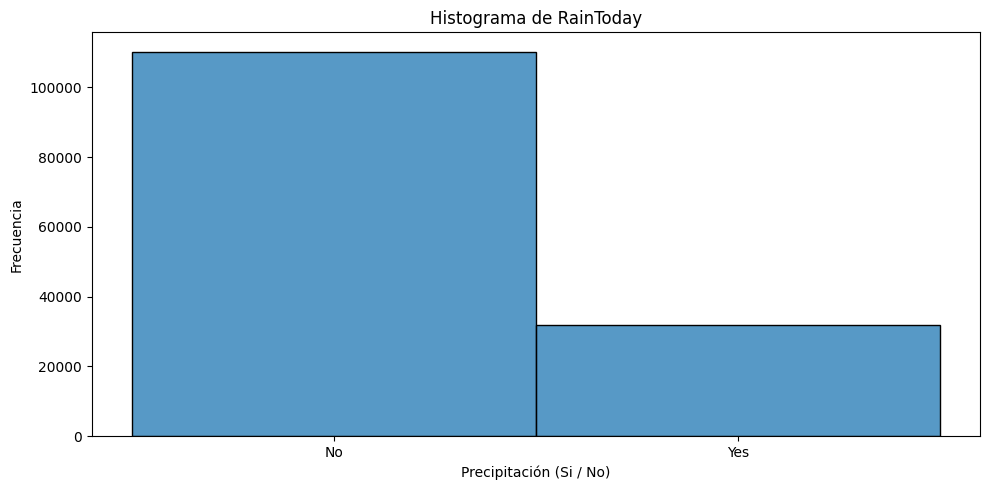

count     142152
unique         2
top           No
freq      110276
Name: RainToday, dtype: object

In [28]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(weather_data['RainToday'])
axs.set_title('Histograma de RainToday')
axs.set_xlabel('Precipitación (Si / No)')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

weather_data['RainToday'].describe()

### RainTomorrow

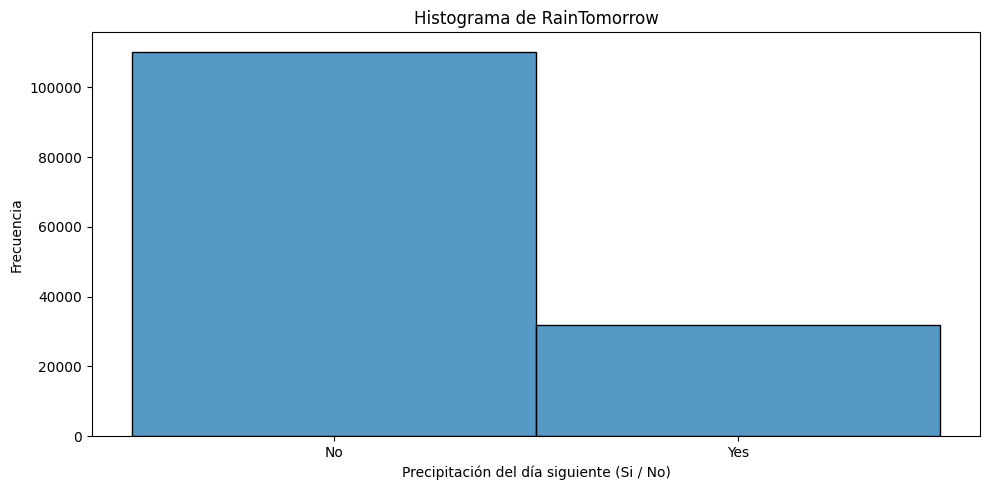

count     142153
unique         2
top           No
freq      110281
Name: RainTomorrow, dtype: object

In [29]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(weather_data['RainTomorrow'])
axs.set_title('Histograma de RainTomorrow')
axs.set_xlabel('Precipitación del día siguiente (Si / No)')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

weather_data['RainTomorrow'].describe()

### RainfallTomorrow

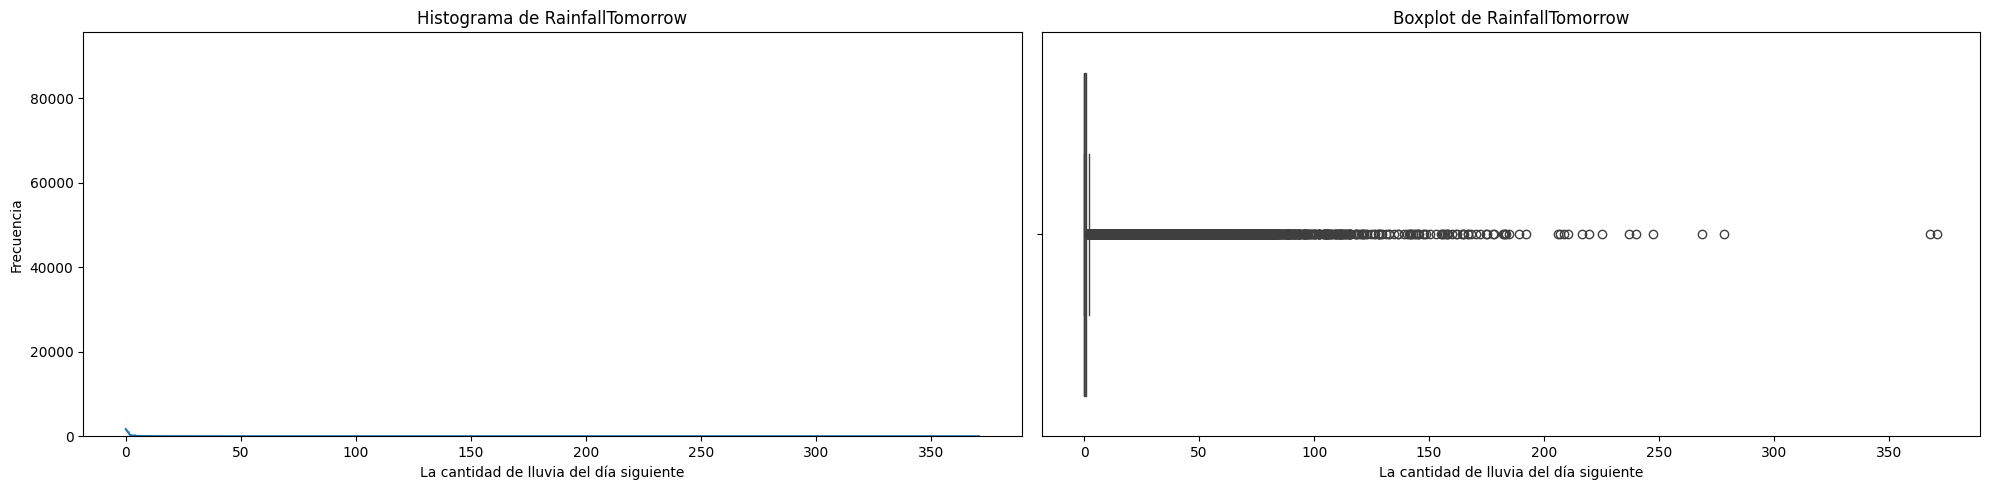

count    142153.000000
mean          2.361242
std           8.479084
min           0.000000
25%           0.000000
50%           0.000000
75%           0.800000
max         371.000000
Name: RainfallTomorrow, dtype: float64

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['RainfallTomorrow'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de RainfallTomorrow')
axs[0].set_xlabel('La cantidad de lluvia del día siguiente')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['RainfallTomorrow'], ax=axs[1])
axs[1].set_title('Boxplot de RainfallTomorrow')
axs[1].set_xlabel('La cantidad de lluvia del día siguiente')

plt.tight_layout()
plt.show()

weather_data['RainfallTomorrow'].describe()

**Histograma:**

El histograma muestra la distribución de la velocidad de la cantidad de lluvia del día siguiente en los datos meteorológicos. La curva KDE (Kernel Density Estimate) superpuesta al histograma representa una estimación suavizada de esta distribución. Se observa que la mayoría de la cantidad de lluvia del día siguiente se concentran alrededor de un rango específico, lo que indica una distribución con una tendencia central. Las líneas verticales rojas representan los cuartiles (Q1, Q2, Q3) de los datos.

**Boxplot:**

El boxplot proporciona un resumen estadístico de los datos de la cantidad de lluvia del día siguiente Muestra la mediana (representada por la línea horizontal dentro del recuadro), los cuartiles (Q1 y Q3, representados por los límites del recuadro) y el rango intercuartílico (IQR). Se observan varios valores atípicos que se extienden más allá de los bigotes del boxplot. Esto sugiere que hay algunos días con niveles de la cantidad de lluvia del día siguiente significativamente altos.

**Interpretación:**

En general, la distribución de la cantidad de lluvia del día siguiente en los datos meteorológicos presenta una tendencia central, con la mayoría de la cantidad de lluvia del día siguiente concentrándose alrededor de 00.0 mm. Sin embargo, la presencia de valores atípicos indica que hay algunos días con niveles de la cantidad de lluvia del día siguiente significativamente altos. La media y la mediana son cercanas, lo que sugiere que la distribución puede ser simétrica.


### Otros

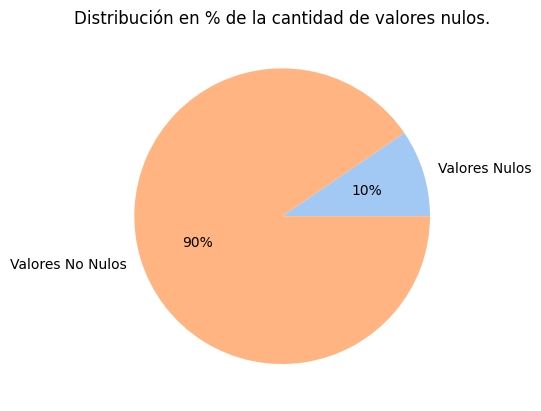

In [31]:
# Calcula el número total de valores (nulos y no nulos)
total_valores = np.product(weather_data.shape)

# Calcula el número de valores nulos
valores_nulos = weather_data.isnull().sum().sum()

# Calcula el número de valores no nulos
valores_no_nulos = total_valores - valores_nulos

# Crea una lista con los valores para el gráfico
datos = [valores_nulos, valores_no_nulos]

# Crea una lista con las etiquetas para el gráfico
etiquetas = ['Valores Nulos', 'Valores No Nulos']

colors = sns.color_palette("pastel")

plt.title('Distribución en % de la cantidad de valores nulos.')
plt.pie(datos, labels=etiquetas, colors=colors, autopct='%.0f%%')
plt.show()

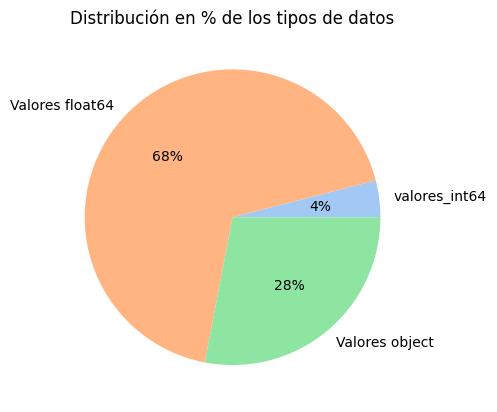

In [32]:
# Calcula el número de valores que son de tipo int64
valores_int64 = (weather_data.dtypes == 'int64').sum()

# Calcula el número de valores que son de tipo float64
valores_float64 = (weather_data.dtypes == 'float64').sum()

# Calcula el número de valores que son de tipo object
valores_object = (weather_data.dtypes == 'object').sum()

# Crea una lista con los valores para el gráfico
datos = [valores_int64, valores_float64, valores_object]

# Crea una lista con las etiquetas para el gráfico
etiquetas = ['valores_int64', 'Valores float64', 'Valores object']

colors = sns.color_palette("pastel")

plt.title('Distribución en % de los tipos de datos')
plt.pie(datos, labels=etiquetas, colors=colors, autopct='%.0f%%')
plt.show()

## Conclusiones

### Columnas
- Date: Fecha de observación.

        Debemos eliminarla porque no contiene información relevante.
        
- Location: El nombre de la ubicación de la estación meteorológica.

        Debemos descartar todas las ubicaciones que no nos interesen y luego las restantes asumirlas como una misma y única, para poder posteriormente eliminar Location y reducir la dimensionalidad para un modelo más simple.

- MinTemp: La temperatura mínima (°C).
- MaxTemp: La temperatura máxima (°C).

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la temperatura promedio durante el día (PromTemp = MaxTemp - MinTemp)

- Rainfall: La cantidad de lluvia registrada durante el día (mm).
- Evaporation: La evaporación del recipiente Clase A (mm) en el período de 24 horas a las 9 a.m.
- Sunshine: El número de horas de sol brillante en el día.
- WindGustDir: La dirección de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche.
- WindGustSpeed: La velocidad (km/h) de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche.
- WindDir9am: Dirección del viento a las 9 a.m.
- WindDir3pm: Dirección del viento a las 3 p.m.
- WindSpeed9am: Velocidad del viento (km/h) promediada de las 9 a.m.
- WindSpeed3pm: Velocidad del viento (km/h) promediada de las 3 p.m.
- Humidity9am: Humedad (porcentaje) a las 9 a.m.
- Humidity3pm: Humedad (porcentaje) a las 3 p.m.

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la diferencia de humedad (ΔHumidity = Humidity3pm - Humidity9am)

- Pressure9am: La presión atmosférica (hPa) a las 9 a. m.
- Pressure3pm: La presión atmosférica (hPa) a las 3 p. m.

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la diferencia de presión atmosférica (ΔPressure = Pressure3pm - Pressure9am)

- Cloud9am: Fracción del cielo oscurecida por las nubes a las 9 a.m. Esto se mide en "oktas", que son una unidad de octavos. Registra cuantos
- Cloud3pm: Fracción del cielo oscurecida por las nubes a las 3 p.m. Esto se mide en "oktas", que son una unidad de octavos. Registra cuantos
- Temp9am: Temperatura (grados C) a las 9 a.m.
- Temp3pm: Temperatura (grados C) a las 3 p.m.
- RainToday: Booleano: 1 si la precipitación (mm) en las 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0
- RainTomorrow: Booleano: 1 si la precipitación (mm) en las siguientes 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0

        Debemos eliminarla porque no contiene información relevante para el modelo de regresión lineal.

- RainfallTomorrow: La cantidad de lluvia del día siguiente en mm. Se utiliza para crear la variable de respuesta RainTomorrow. Una especie de medida del "riesgo".

### Outliers

Según nuestro análisis previo, las siguientes columnas presentan valores atípicos: **Rainfall**, **Evaporation**, **WindSpeed9am**, **WindSpeed3pm** y **RainfallTomorrow**. A excepción de **RainfallTomorrow** deberán tratarse todos los valores atípicos encontrados para así evitar que estos puedan sesgar o influir en la estimación de los parámetros del modelo, ya que un solo valor atípico podría arrastrar la línea de regresión hacia sí mismo, lo que resulta en una pendiente y una intersección que no representa correctamente la relación general entre las variables.

Para lograr esto deberemos tener en cuenta que los datos eliminados nunca deberán ser superiores al 10% de los datos totales, ya que si no, podríamos perder información valiosa que podría ser crucial para nuestro análisis. Además, una eliminación excesiva de datos podría llevar a un sesgo en los resultados del modelo. Por lo tanto, es esencial equilibrar la necesidad de limpiar los datos y preservar la integridad de nuestro conjunto de datos.

Sin embargo, cabe aclarar que estos valores atípicos podrían ser un error de Tipo I al rechazar incorrectamente la hipótesis nula de que el punto de datos no es un valor atípico. De igual manera, es necesario llevar a cabo un segundo análisis de valores atípicos posterior a la reducción de dimensionalidad, ya que al solo interesarnos en ciertas ubicaciones, las demás deberán ser descartadas, al igual que las columnas que no proporcionan información relevante para el modelo: Unnamed: 0, Date, Location.

# Reducción de dimensionalidad

In [33]:
weather_data

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145407,145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,...,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No,0.0
145408,145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,...,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,0.0
145409,145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,...,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,0.0
145410,145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,...,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,0.0


**145.412 filas**

Eliminamos las localidades que no nos interesan predecir

In [34]:
# Lista de ubicaciones deseadas
ubicaciones_deseadas = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

# Filtra el DataFrame para que solo contenga las ubicaciones deseadas
weather_data = weather_data[weather_data['Location'].isin(ubicaciones_deseadas)]

In [35]:
weather_data

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6047,6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
6048,6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0.0
6049,6051,2009-01-03,Cobar,15.5,34.1,0.0,12.6,13.3,SE,30.0,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,0.0
6050,6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0.0
6051,6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102515,102547,2017-06-20,MountGambier,6.2,16.3,0.0,NaN,NaN,N,41.0,...,70.0,1026.3,1024.1,NaN,NaN,8.7,15.5,No,Yes,2.0
102516,102548,2017-06-21,MountGambier,8.7,13.2,2.0,NaN,NaN,S,20.0,...,82.0,1029.2,1028.3,NaN,8.0,11.1,12.0,Yes,No,0.0
102517,102549,2017-06-22,MountGambier,7.0,15.7,0.0,NaN,NaN,N,31.0,...,67.0,1027.0,1022.4,8.0,NaN,10.0,14.9,No,No,0.0
102518,102550,2017-06-23,MountGambier,5.4,16.2,0.0,NaN,NaN,N,37.0,...,70.0,1017.0,1014.4,8.0,4.0,6.4,14.9,No,Yes,2.2


**28.233 filas**

Dejamos a un lado las siguientes columnas:
- Location:

         Eliminaremos esta columna, ya que vamos a tomar las ubicaciones: 'Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport' como la si fueran una misma y así simplificar el modelo.

- Unnamed: 0:

         Eliminaremos esta columna, ya que no aporta nada de información al modelo.
        
- RainTomorrow:

         No la utilizaremos a esta columna, ya que no contiene información relevante para el modelo de regresión lineal.


In [36]:
weather_data = weather_data.drop(['Unnamed: 0', 'Location'], axis=1)

weather_data

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6047,2009-01-01,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
6048,2009-01-02,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0.0
6049,2009-01-03,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,N,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,0.0
6050,2009-01-04,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0.0
6051,2009-01-05,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102515,2017-06-20,6.2,16.3,0.0,NaN,NaN,N,41.0,N,NW,...,70.0,1026.3,1024.1,NaN,NaN,8.7,15.5,No,Yes,2.0
102516,2017-06-21,8.7,13.2,2.0,NaN,NaN,S,20.0,NaN,SE,...,82.0,1029.2,1028.3,NaN,8.0,11.1,12.0,Yes,No,0.0
102517,2017-06-22,7.0,15.7,0.0,NaN,NaN,N,31.0,N,NNW,...,67.0,1027.0,1022.4,8.0,NaN,10.0,14.9,No,No,0.0
102518,2017-06-23,5.4,16.2,0.0,NaN,NaN,N,37.0,NNW,W,...,70.0,1017.0,1014.4,8.0,4.0,6.4,14.9,No,Yes,2.2


# Balanceo del dataset

## Regresión

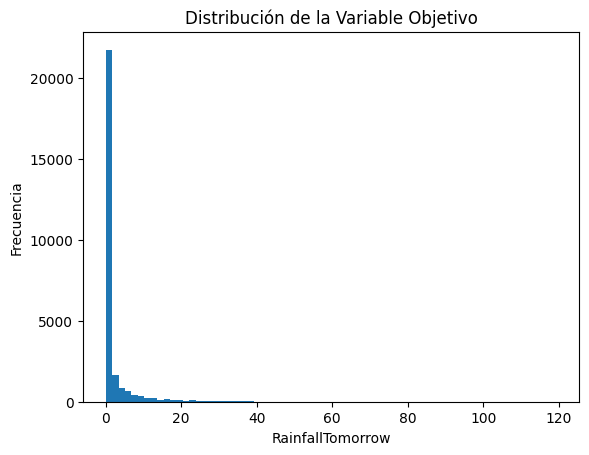

In [37]:
plt.hist(weather_data['RainfallTomorrow'], bins=70)
plt.xlabel('RainfallTomorrow')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Variable Objetivo')
plt.show()

Se observa que el histograma tiene un sesgo positivo, ya que la mayoría de los valores están cerca de 0, lo que indica que hay muchos días con poca o ninguna lluvia.

## Clasificación

In [38]:
# Contar las instancias de cada clase en la variable objetivo 'RainTomorrow'
conteo_clases = weather_data['RainTomorrow'].value_counts()

# Mostrar el conteo de clases
print(conteo_clases)

RainTomorrow
No     20777
Yes     6471
Name: count, dtype: int64


La clase "No" tiene 21,761 instancias. La clase "Yes" tiene 6,471 instancias. Dado que la clase "No" tiene considerablemente más instancias que la clase "Yes", podemos decir que el dataset está desbalanceado en términos de la variable objetivo "RainTomorrow". Esto significa que hay muchas más instancias de "No lluvia" que de "Lluvia".

Creemos que hacen esta pregunta ya que cuando se trabaja con datasets desbalanceados, es importante tener en cuenta el desequilibrio al entrenar modelos de aprendizaje automático, puede afectar el rendimiento del modelo y sesgar las predicciones hacia la clase mayoritaria.

# Train y Test

Dividimos el set de datos en train y test antes de realizar la imputación de nulos para evitar la generación de un data leakage

Esto lo hacemos a través de la fecha, ya que de este modo podemos mantener la integridad temporal de nuestros datos. Al dividir los datos en conjuntos de entrenamiento y prueba basándonos en una fecha específica, estamos respetando el orden cronológico de los eventos. Esto es especialmente importante en series temporales y en problemas donde la secuencia y la temporalidad importan.

Por otro lado, si utilizáramos train_test_split de manera aleatoria, podríamos terminar con datos de prueba que se filtraron en el conjunto de entrenamiento después de la imputación. Esto podría llevar a un modelo sobreajustado que funciona bien en los datos de entrenamiento, pero falla al generalizar en datos nuevos o futuros.

In [39]:
# Convierto la columna 'Date' a tipo datetime
weather_data["Date"] = pd.to_datetime(weather_data["Date"])

# Mostrar la primera y última fecha
primera_fecha = weather_data['Date'].min()
ultima_fecha = weather_data['Date'].max()

print("Primera fecha:", primera_fecha)
print("Última fecha:", ultima_fecha)

# Calcular la fecha que abarque el 80% de los datos
fecha_80porciento = weather_data['Date'].quantile(0.8)

print("Fecha que abarca el 80% de los datos:", fecha_80porciento)

Primera fecha: 2007-11-01 00:00:00
Última fecha: 2017-06-24 00:00:00
Fecha que abarca el 80% de los datos: 2015-10-06 00:00:00


In [40]:
# Dividir los datos en conjuntos de entrenamiento y prueba basados en la fecha
train = weather_data[weather_data['Date'] <= fecha_80porciento]

test = weather_data[weather_data['Date'] > fecha_80porciento]

Ya que la fecha no aporta nada más de valor, procedemos a eliminarla para reducir un poco más la dimensionalidad y así la complejidad de nuestro modelo.

In [41]:
train = train.drop('Date', axis=1)

test = test.drop('Date', axis=1)

In [42]:
weather_data

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6047,2009-01-01,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
6048,2009-01-02,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0.0
6049,2009-01-03,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,N,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,0.0
6050,2009-01-04,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0.0
6051,2009-01-05,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102515,2017-06-20,6.2,16.3,0.0,NaN,NaN,N,41.0,N,NW,...,70.0,1026.3,1024.1,NaN,NaN,8.7,15.5,No,Yes,2.0
102516,2017-06-21,8.7,13.2,2.0,NaN,NaN,S,20.0,NaN,SE,...,82.0,1029.2,1028.3,NaN,8.0,11.1,12.0,Yes,No,0.0
102517,2017-06-22,7.0,15.7,0.0,NaN,NaN,N,31.0,N,NNW,...,67.0,1027.0,1022.4,8.0,NaN,10.0,14.9,No,No,0.0
102518,2017-06-23,5.4,16.2,0.0,NaN,NaN,N,37.0,NNW,W,...,70.0,1017.0,1014.4,8.0,4.0,6.4,14.9,No,Yes,2.2


**28233  filas**

In [43]:
train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6047,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,6.0,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
6048,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,19.0,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0.0
6049,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,N,NaN,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,0.0
6050,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,30.0,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0.0
6051,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,6.0,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101888,10.7,25.3,0.0,3.2,8.0,NNW,41.0,N,NNW,20.0,...,37.0,1031.8,1027.6,3.0,NaN,13.1,24.7,No,No,0.0
101889,10.7,29.5,0.0,7.2,8.4,NNW,57.0,NNW,NNW,26.0,...,18.0,1023.6,1019.4,2.0,6.0,22.0,28.2,No,No,0.0
101890,7.8,25.2,0.0,7.2,7.8,W,44.0,NW,WNW,9.0,...,44.0,1021.9,1020.6,NaN,NaN,13.4,24.6,No,No,0.0
101891,8.7,32.4,0.0,4.0,11.4,NW,76.0,N,NNW,17.0,...,15.0,1017.3,1013.8,6.0,1.0,18.4,32.0,No,No,0.0


**28233 * 0.8 = 22590 filas**

In [44]:
test

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
8428,18.4,34.1,0.0,8.2,NaN,S,35.0,S,S,15.0,...,17.0,1026.0,1023.9,1.0,4.0,21.6,33.1,No,No,0.0
8429,15.6,32.0,0.0,7.4,NaN,NE,43.0,ENE,ENE,28.0,...,23.0,1030.3,1027.0,1.0,1.0,18.7,31.0,No,No,0.0
8430,17.8,32.7,0.0,10.6,NaN,S,46.0,NNE,E,17.0,...,19.0,1030.5,1026.5,1.0,1.0,22.2,31.9,No,Yes,2.6
8431,17.5,32.4,2.6,9.2,NaN,ENE,37.0,E,SSE,17.0,...,20.0,1026.9,1022.8,3.0,7.0,23.5,30.5,Yes,Yes,1.6
8432,17.3,28.5,1.6,6.2,NaN,W,54.0,NNE,ENE,17.0,...,42.0,1022.2,1019.5,5.0,3.0,20.3,25.4,Yes,Yes,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102515,6.2,16.3,0.0,NaN,NaN,N,41.0,N,NW,24.0,...,70.0,1026.3,1024.1,NaN,NaN,8.7,15.5,No,Yes,2.0
102516,8.7,13.2,2.0,NaN,NaN,S,20.0,NaN,SE,0.0,...,82.0,1029.2,1028.3,NaN,8.0,11.1,12.0,Yes,No,0.0
102517,7.0,15.7,0.0,NaN,NaN,N,31.0,N,NNW,13.0,...,67.0,1027.0,1022.4,8.0,NaN,10.0,14.9,No,No,0.0
102518,5.4,16.2,0.0,NaN,NaN,N,37.0,NNW,W,24.0,...,70.0,1017.0,1014.4,8.0,4.0,6.4,14.9,No,Yes,2.2


**28233 * 0.2 = 5643  filas**

# Datos faltantes

## Eliminación de datos faltantes de Train

Verificamos si existen filas que contengan solo valores nulos.

In [45]:
# Contamos el número total de filas que tengan todos sus valores como nulos en train
train_nulas = train.isnull().all(axis=1).sum()

train_nulas

0

Vemos que no tiene una fila donde todos sus valores son nulos, así que hace falta realizar ninguna acción.

## Eliminación de datos faltantes de Test

Verificamos si existen filas que contengan solo valores nulos.

In [46]:
# Contamos el número total de filas que tengan todos sus valores como nulos en test
test_nulas = test.isnull().all(axis=1).sum()

test_nulas

1

Vemos que si tiene una fila donde todos sus valores son nulos, así que la eliminamos.

In [47]:
test = test.dropna(how='all')

Verificamos que se haya borrado correctamente y que no queden filas que contengan todos sus valores nulos.

In [48]:
# Contamos el número total de filas que tengan todos sus valores como nulos en test
test_nulas = test.isnull().all(axis=1).sum()

test_nulas

0

## Completado de datos

**Datos categoricos:** Usaremos la mediana para rellenar los datos faltantes, ya que la mediana es una medida de tendencia central que no se ve afectada por los valores extremos o atípicos que podrían sesgar y distorsionar mis resultados.

**Datos continuos:**  Usaremos la moda para rellenar los datos faltantes, ya que, dado que las variables categóricas no son numéricas, medidas como la media y la mediana no tienen sentido en este contexto.  Al rellenar los datos faltantes con la moda, estoy esencialmente asumiendo que la categoría más común es la más probable de ocurrir en los datos faltantes. Esto puede no ser siempre el caso, pero es una suposición razonable en ausencia de información adicional.

### Completado de datos de Train

Verificamos si existen valores faltantes

In [49]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']].isnull().sum()

WindGustDir     1571
WindDir9am      1415
WindDir3pm       414
RainToday        742
RainTomorrow     742
dtype: int64

Vemos que si hay datos faltantes, por lo tanto, rellenamos los datos faltantes con la moda.

In [50]:
train['WindGustDir'].fillna(train['WindGustDir'].mode()[0], inplace=True)
train['WindDir9am'].fillna(train['WindDir9am'].mode()[0], inplace=True)
train['WindDir3pm'].fillna(train['WindDir3pm'].mode()[0], inplace=True)
train['RainToday'].fillna(train['RainToday'].mode()[0], inplace=True)
train['RainTomorrow'].fillna(train['RainTomorrow'].mode()[0], inplace=True)

Verificamos que se hayan rellenado los valores faltantes con la moda correctamente y que no queden valores nulos.

In [51]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']].isnull().sum()

WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

Verificamos si existen valores numéricos faltantes.

In [52]:
columns_to_check = [col for col in train.columns if col not in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]
train[columns_to_check].isnull().sum()

MinTemp              357
MaxTemp              344
Rainfall             742
Evaporation         2016
Sunshine            3962
WindGustSpeed       1568
WindSpeed9am         350
WindSpeed3pm         336
Humidity9am          605
Humidity3pm          561
Pressure9am          625
Pressure3pm          618
Cloud9am            7179
Cloud3pm            7469
Temp9am              372
Temp3pm              366
RainfallTomorrow     742
dtype: int64

In [53]:
columns_to_check = [col for col in train.columns if col not in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]
train[columns_to_check].isnull().sum()

MinTemp              357
MaxTemp              344
Rainfall             742
Evaporation         2016
Sunshine            3962
WindGustSpeed       1568
WindSpeed9am         350
WindSpeed3pm         336
Humidity9am          605
Humidity3pm          561
Pressure9am          625
Pressure3pm          618
Cloud9am            7179
Cloud3pm            7469
Temp9am              372
Temp3pm              366
RainfallTomorrow     742
dtype: int64

Rellenamos los datos faltantes con la mediana.

In [54]:
columns_to_fill = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                   'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
                   'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
                   'Temp3pm', 'RainfallTomorrow']

train_filled = train.copy()
train[columns_to_fill] = train_filled[columns_to_fill].fillna(train_filled[columns_to_fill].median())

Verificamos que se hayan rellenado los valores faltantes con la mediana correctamente y que no queden valores nulos.

In [55]:
columns_to_check = [col for col in train.columns if col not in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]
train[columns_to_check].isnull().sum()

MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustSpeed       0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainfallTomorrow    0
dtype: int64

### Completado de datos de Test

Verificamos si existen valores categoricos faltantes.

In [56]:
test[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']].isnull().sum()

WindGustDir      73
WindDir9am      232
WindDir3pm       22
RainToday       243
RainTomorrow    242
dtype: int64

Vemos que si hay datos faltantes, por lo tanto, rellenamos los datos faltantes con la moda.

In [57]:
test['WindGustDir'].fillna(test['WindGustDir'].mode()[0], inplace=True)
test['WindDir9am'].fillna(test['WindDir9am'].mode()[0], inplace=True)
test['WindDir3pm'].fillna(test['WindDir3pm'].mode()[0], inplace=True)
test['RainToday'].fillna(test['RainToday'].mode()[0], inplace=True)
test['RainTomorrow'].fillna(test['RainTomorrow'].mode()[0], inplace=True)

C:\Users\src4\AppData\Local\Temp\ipykernel_19932\2205085796.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['WindGustDir'].fillna(test['WindGustDir'].mode()[0], inplace=True)
C:\Users\src4\AppData\Local\Temp\ipykernel_19932\2205085796.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['WindDir9am'].fillna(test['WindDir9am'].mode()[0], inplace=True)
C:\Users\src4\AppData\Local\Temp\ipykernel_19932\2205085796.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Verificamos que se hayan rellenado los valores faltantes con la moda correctamente y que no queden valores nulos.

In [58]:
test[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']].isnull().sum()

WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

Verificamos si existen valores numéricos faltantes.

In [59]:
columns_to_check = [col for col in test.columns if col not in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]
test[columns_to_check].isnull().sum()

MinTemp              212
MaxTemp              213
Rainfall             243
Evaporation         2336
Sunshine            2750
WindGustSpeed         73
WindSpeed9am           7
WindSpeed3pm           3
Humidity9am          334
Humidity3pm          328
Pressure9am          213
Pressure3pm          210
Cloud9am            2187
Cloud3pm            2080
Temp9am              212
Temp3pm              209
RainfallTomorrow     242
dtype: int64

Rellenamos los datos faltantes con la mediana.

In [60]:
columns_to_fill = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                   'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
                   'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
                   'Temp3pm', 'RainfallTomorrow']

test_filled = test.copy()
test[columns_to_fill] = test_filled[columns_to_fill].fillna(test_filled[columns_to_fill].median())

C:\Users\src4\AppData\Local\Temp\ipykernel_19932\3321180541.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[columns_to_fill] = test_filled[columns_to_fill].fillna(test_filled[columns_to_fill].median())


Verificamos que se hayan rellenado los valores faltantes con la mediana correctamente y que no queden valores nulos.

In [61]:
columns_to_check = [col for col in test.columns if col not in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]
test[columns_to_check].isnull().sum()

MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustSpeed       0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainfallTomorrow    0
dtype: int64

# Estandarización

In [62]:
# Crear el estandarizador
scaler = StandardScaler()

## Estandarización de Train

In [63]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                          'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
                          'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
                          'Temp3pm', 'RainfallTomorrow']

# Aplicar la estandarización a las columnas seleccionadas
train[columns_to_standardize] = scaler.fit_transform(train[columns_to_standardize])

In [64]:
train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6047,1.215933,2.079155,-0.314848,2.137163,1.521298,SSW,0.430991,ENE,SW,-0.975070,...,-1.898636,-1.657851,-1.662427,-1.250081,-0.055960,2.031383,2.077791,No,No,-0.314692
6048,1.304671,1.115813,-0.314848,2.948921,1.720741,S,-0.366508,SSE,SSE,0.387503,...,-2.152436,-0.752604,-0.585202,-1.663547,-1.851608,0.906131,1.075637,No,No,-0.314692
6049,0.789993,1.910952,-0.314848,2.311111,1.806216,SE,-0.874008,N,N,-0.241377,...,-2.203196,0.015485,-0.655152,0.403784,-1.851608,-0.094094,1.968180,No,No,-0.314692
6050,1.482146,2.446142,-0.314848,1.789267,1.036936,NNE,0.285991,NNE,NNW,1.540449,...,-1.441796,-0.834899,-0.990910,-1.663547,0.392952,2.406468,2.312670,No,No,-0.314692
6051,1.925833,2.568471,-0.314848,1.963215,1.492806,WNW,-0.801508,WNW,WSW,-0.975070,...,-1.441796,-0.780036,-1.004900,-1.663547,-0.055960,2.477912,2.422281,No,No,-0.314692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101888,-0.061887,0.565332,-0.314848,-0.414076,0.296148,NNW,-0.076508,N,NNW,0.492316,...,-0.680397,1.839696,1.583238,-0.836615,0.392952,-0.379873,0.715488,No,No,-0.314692
101889,-0.061887,1.207560,-0.314848,0.745578,0.410115,NNW,1.083491,NNW,NNW,1.121196,...,-1.644836,0.714995,0.436063,-1.250081,0.392952,1.209770,1.263541,No,No,-0.314692
101890,-0.576564,0.550041,-0.314848,0.745578,0.239164,W,0.140991,NW,WNW,-0.660630,...,-0.325077,0.481825,0.603942,0.403784,0.392952,-0.326289,0.699830,No,No,-0.314692
101891,-0.416837,1.651003,-0.314848,-0.182145,1.264871,NW,2.460989,N,NNW,0.177876,...,-1.797116,-0.149105,-0.347373,0.403784,-1.851608,0.566769,1.858569,No,No,-0.314692


## Estandarización de Test

In [65]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                          'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
                          'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
                          'Temp3pm', 'RainfallTomorrow']

# Aplicar la estandarización a las columnas seleccionadas
test[columns_to_standardize] = scaler.fit_transform(test[columns_to_standardize])

C:\Users\src4\AppData\Local\Temp\ipykernel_19932\1043390785.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[columns_to_standardize] = scaler.fit_transform(test[columns_to_standardize])


In [66]:
test

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
8428,1.114136,1.613681,-0.315742,0.848806,0.118663,S,-0.417499,S,S,0.079349,...,-1.751012,1.124217,1.151124,-2.045275,-0.598874,0.901833,1.744712,No,No,-0.315766
8429,0.618108,1.307132,-0.315742,0.599204,0.118663,NE,0.169860,ENE,ENE,1.560624,...,-1.440642,1.707239,1.582617,-2.045275,-1.971831,0.394038,1.430150,No,No,-0.315766
8430,1.007845,1.409315,-0.315742,1.597613,0.118663,S,0.390120,NNE,E,0.307237,...,-1.647555,1.734356,1.513021,-2.045275,-1.971831,1.006895,1.564962,No,Yes,0.078967
8431,0.954699,1.365522,0.078988,1.160809,0.118663,ENE,-0.270659,E,SSE,0.307237,...,-1.595827,1.246245,0.998013,-1.127699,0.774083,1.234527,1.355255,Yes,Yes,-0.072853
8432,0.919268,0.796217,-0.072831,0.224800,0.118663,W,0.977479,NNE,ENE,0.307237,...,-0.457807,0.608988,0.538682,-0.210122,-1.056527,0.674201,0.591320,Yes,Yes,-0.133581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102515,-1.047131,-0.984687,-0.315742,-0.087203,0.118663,N,0.023020,N,NW,1.104847,...,0.990583,1.164893,1.178962,0.248666,0.316431,-1.356980,-0.891613,No,Yes,-0.012125
102516,-0.604248,-1.437211,-0.012104,-0.087203,0.118663,S,-1.518797,N,SE,-1.629814,...,1.611322,1.558093,1.763566,0.248666,1.231736,-0.936736,-1.415883,Yes,No,-0.315766
102517,-0.905409,-1.072272,-0.315742,-0.087203,0.118663,N,-0.711179,N,NNW,-0.148539,...,0.835399,1.259803,0.942337,1.166243,0.316431,-1.129348,-0.981488,No,No,-0.315766
102518,-1.188853,-0.999284,-0.315742,-0.087203,0.118663,N,-0.270659,NNW,W,1.104847,...,0.990583,-0.096062,-0.171194,1.166243,-0.598874,-1.759715,-0.981488,No,Yes,0.018239


# One hot enconding (Dummies)

Al tener demasiadas variables categóricas en mi DataFrame, lo que hice fue simplificar la situación agrupándolas. Tenía una columna con direcciones de viento que incluía 16 categorías distintas como 'N', 'NNW', 'NNE', etc. Pero para mi análisis, no necesitaba tanta granularidad, así que decidí agrupar estas 16 categorías en solo 4: 'N', 'S', 'E' y 'W'.

Para hacer esto, creé un diccionario que mapeaba cada una de las 16 categorías a una de las 4 direcciones principales. Luego, utilicé la función map de pandas para aplicar este mapeo a mi columna. De esta manera, pude reducir la cantidad de categorías únicas en mi columna de 16 a solo 4, lo que simplificó mucho mi análisis

## Dummies de Train

In [67]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
6047,SSW,ENE,SW,No,No
6048,S,SSE,SSE,No,No
6049,SE,N,N,No,No
6050,NNE,NNE,NNW,No,No
6051,WNW,WNW,WSW,No,No
...,...,...,...,...,...
101888,NNW,N,NNW,No,No
101889,NNW,NNW,NNW,No,No
101890,W,NW,WNW,No,No
101891,NW,N,NNW,No,No


In [68]:
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
train['WindGustDir'] = train['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
train['WindDir9am'] = train['WindDir9am'].map(diccionario_invertido)

# Aplicar la transformación a WindDir3pm
train['WindDir3pm'] = train['WindDir3pm'].map(diccionario_invertido)

In [69]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
6047,S,E,S,No,No
6048,S,S,S,No,No
6049,S,N,N,No,No
6050,N,N,N,No,No
6051,W,W,W,No,No
...,...,...,...,...,...
101888,N,N,N,No,No
101889,N,N,N,No,No
101890,W,N,W,No,No
101891,N,N,N,No,No


Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.

In [70]:
columns_to_dummy = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
train_dummies = pd.get_dummies(train, columns=columns_to_dummy)

Al tener múltiples categorías en cada una de las columna categóricas, eliminamos una de las variables dummy para evitar la colinealidad. Por ejemplo la columna RainToday_No, es una columna redundante porque es perfectamente inversas a RainToday_Yes, es decir, si un día tiene un '1' en RainToday_No, entonces tiene un '0' en RainToday_Yes, y viceversa.

In [71]:
train_dummies = pd.get_dummies(train, columns=columns_to_dummy, drop_first=True)

In [72]:
train_dummies.replace({True: 1, False: 0}, inplace=True)

In [73]:
train_dummies

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
6047,1.215933,2.079155,-0.314848,2.137163,1.521298,0.430991,-0.975070,-0.021531,-2.627700,-1.898636,...,1,0,0,0,0,0,1,0,0,0
6048,1.304671,1.115813,-0.314848,2.948921,1.720741,-0.366508,0.387503,-0.133136,-2.089139,-2.152436,...,1,0,0,1,0,0,1,0,0,0
6049,0.789993,1.910952,-0.314848,2.311111,1.806216,-0.874008,-0.241377,-1.472398,0.065104,-2.203196,...,1,0,1,0,0,1,0,0,0,0
6050,1.482146,2.446142,-0.314848,1.789267,1.036936,0.285991,1.540449,-0.579556,-1.442866,-1.441796,...,0,0,1,0,0,1,0,0,0,0
6051,1.925833,2.568471,-0.314848,1.963215,1.492806,-0.801508,-0.975070,-1.584003,-1.712147,-1.441796,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101888,-0.061887,0.565332,-0.314848,-0.414076,0.296148,-0.076508,0.492316,0.648100,0.926802,-0.680397,...,0,0,1,0,0,1,0,0,0,0
101889,-0.061887,1.207560,-0.314848,0.745578,0.410115,1.083491,1.121196,1.206126,-1.766003,-1.644836,...,0,0,1,0,0,1,0,0,0,0
101890,-0.576564,0.550041,-0.314848,0.745578,0.239164,0.140991,-0.660630,0.201680,0.872945,-0.325077,...,0,1,1,0,0,0,0,1,0,0
101891,-0.416837,1.651003,-0.314848,-0.182145,1.264871,2.460989,0.177876,2.098968,-0.958162,-1.797116,...,0,0,1,0,0,1,0,0,0,0


## Dummies de Test

In [74]:
test[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
8428,S,S,S,No,No
8429,NE,ENE,ENE,No,No
8430,S,NNE,E,No,Yes
8431,ENE,E,SSE,Yes,Yes
8432,W,NNE,ENE,Yes,Yes
...,...,...,...,...,...
102515,N,N,NW,No,Yes
102516,S,N,SE,Yes,No
102517,N,N,NNW,No,No
102518,N,NNW,W,No,Yes


In [75]:
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
test['WindGustDir'] = test['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
test['WindDir9am'] = test['WindDir9am'].map(diccionario_invertido)

# Aplicar la transformación a WindDir3pm
test['WindDir3pm'] = test['WindDir3pm'].map(diccionario_invertido)

C:\Users\src4\AppData\Local\Temp\ipykernel_19932\1802969872.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['WindGustDir'] = test['WindGustDir'].map(diccionario_invertido)
C:\Users\src4\AppData\Local\Temp\ipykernel_19932\1802969872.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['WindDir9am'] = test['WindDir9am'].map(diccionario_invertido)
C:\Users\src4\AppData\Local\Temp\ipykernel_19932\1802969872.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [76]:
test[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
8428,S,S,S,No,No
8429,N,E,E,No,No
8430,S,N,E,No,Yes
8431,E,E,S,Yes,Yes
8432,W,N,E,Yes,Yes
...,...,...,...,...,...
102515,N,N,N,No,Yes
102516,S,N,S,Yes,No
102517,N,N,N,No,No
102518,N,N,W,No,Yes


Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.

In [77]:
columns_to_dummy = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
test_dummies = pd.get_dummies(test, columns=columns_to_dummy)

Al tener múltiples categorías en cada una de las columna categóricas, eliminamos una de las variables dummy para evitar la colinealidad. Por ejemplo la columna RainToday_No, es una columna redundante porque es perfectamente inversas a RainToday_Yes, es decir, si un día tiene un '1' en RainToday_No, entonces tiene un '0' en RainToday_Yes, y viceversa.

In [78]:
test_dummies = pd.get_dummies(test, columns=columns_to_dummy, drop_first=True)

In [79]:
test_dummies.replace({True: 1, False: 0}, inplace=True)

In [80]:
test_dummies

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
8428,1.114136,1.613681,-0.315742,0.848806,0.118663,-0.417499,0.079349,-0.489346,-1.678192,-1.751012,...,1,0,0,1,0,0,1,0,0,0
8429,0.618108,1.307132,-0.315742,0.599204,0.118663,0.169860,1.560624,-0.032169,-1.172583,-1.440642,...,0,0,0,0,0,0,0,0,0,0
8430,1.007845,1.409315,-0.315742,1.597613,0.118663,0.390120,0.307237,-1.403700,-1.453477,-1.647555,...,1,0,1,0,0,0,0,0,0,1
8431,0.954699,1.365522,0.078988,1.160809,0.118663,-0.270659,0.307237,-1.175112,-1.790549,-1.595827,...,0,0,0,0,0,0,1,0,1,1
8432,0.919268,0.796217,-0.072831,0.224800,0.118663,0.977479,0.307237,-0.946523,-0.161367,-0.457807,...,0,1,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102515,-1.047131,-0.984687,-0.315742,-0.087203,0.118663,0.023020,1.104847,0.310713,1.130743,0.990583,...,0,0,1,0,0,1,0,0,0,1
102516,-0.604248,-1.437211,-0.012104,-0.087203,0.118663,-1.518797,-1.629814,-0.946523,1.636351,1.611322,...,1,0,1,0,0,0,1,0,1,0
102517,-0.905409,-1.072272,-0.315742,-0.087203,0.118663,-0.711179,-0.148539,-0.489346,1.299279,0.835399,...,0,0,1,0,0,1,0,0,0,0
102518,-1.188853,-0.999284,-0.315742,-0.087203,0.118663,-0.270659,1.104847,0.539302,1.186922,0.990583,...,0,0,1,0,0,0,0,1,0,1


# Matriz de correlación

## Matriz de correlación numérica

### Train

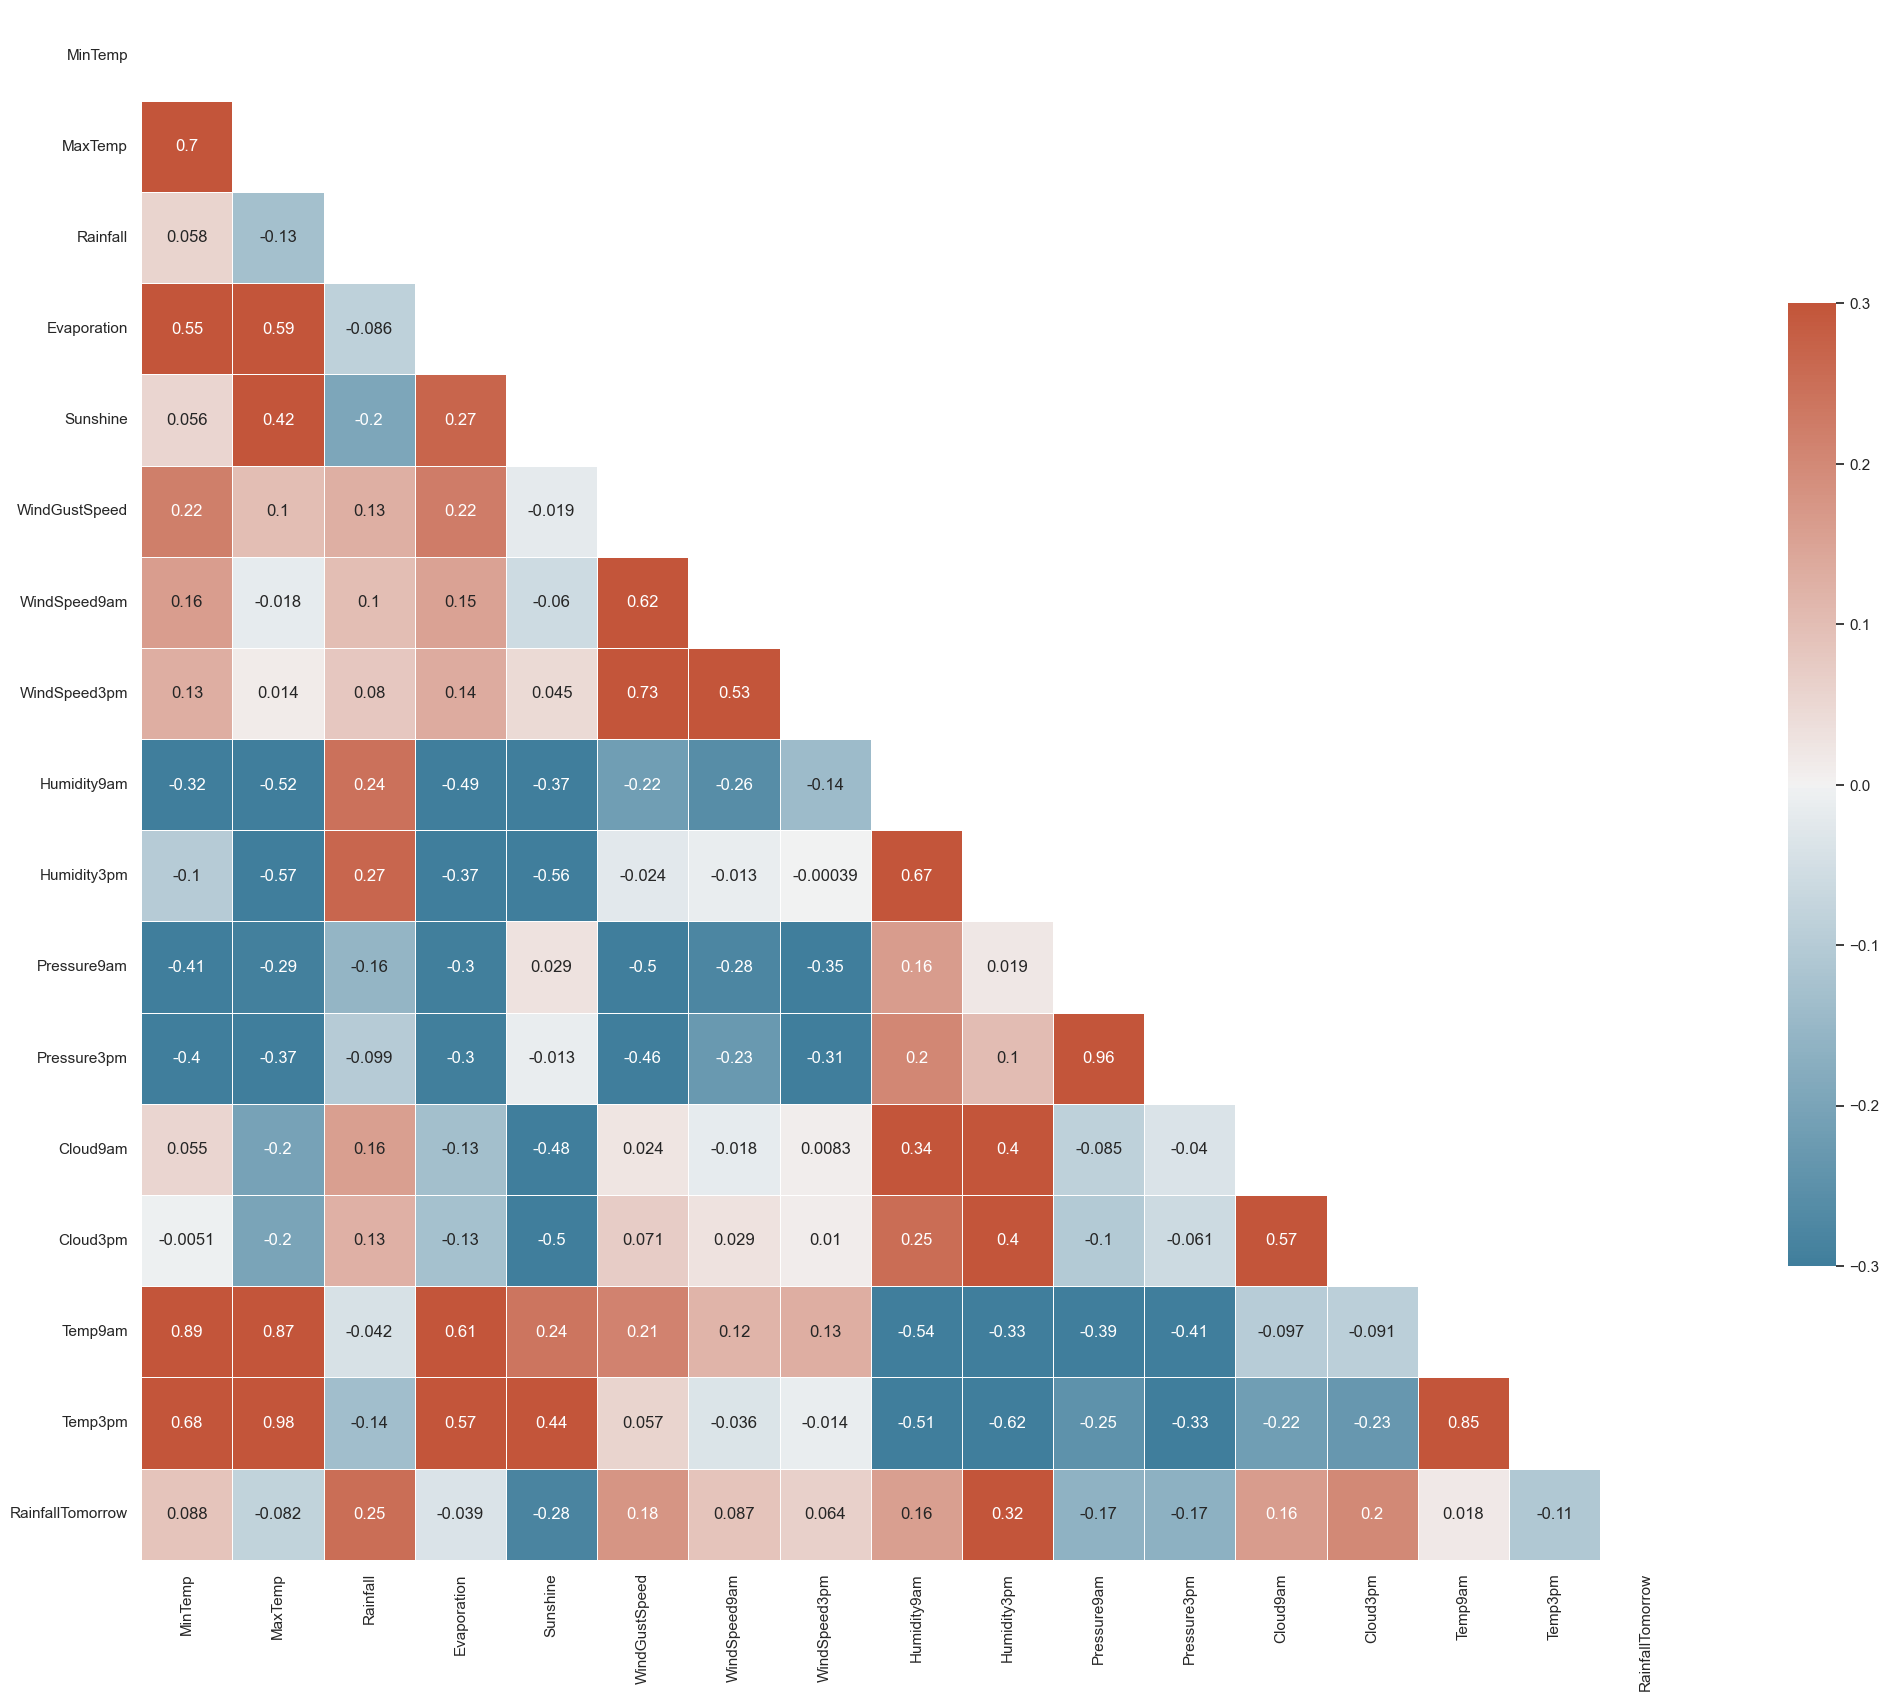

In [81]:
sns.set_theme(style="white")
# Compute the correlation matrix
corr = train_dummies[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainfallTomorrow']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3,center=0, square=True,annot=True ,linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

- *MaxTemp y MinTemp (0.7)*: Hay una correlación positiva fuerte entre la temperatura máxima y mínima del día. Esto significa que, generalmente, los días con altas temperaturas máximas también tienen altas temperaturas mínimas.

- *Evaporation y MaxTemp (0.59):* Existe una correlación positiva moderada entre la evaporación y la temperatura máxima. Días más calientes tienden a tener mayor evaporación.

- *Humidity3pm y Humidity9am (0.67):* Hay una correlación positiva fuerte entre la humedad a las 3pm y la humedad a las 9am, lo cual es esperable ya que la humedad a lo largo del día tiende a estar relacionada.

- *Pressure3pm y Pressure9am (0.96)*: Hay una correlación positiva muy fuerte entre la presión atmosférica a las 3pm y la presión a las 9am, indicando que los cambios de presión son generalmente consistentes a lo largo del día.

- *Temp3pm y Temp9am (0.85)*: La temperatura a las 3pm y a las 9am están fuertemente correlacionadas positivamente, lo cual es lógico ya que la temperatura de la mañana influye en la temperatura del resto del día.

- *RainTomorrow y Rainfall (0.25):* Hay una correlación positiva débil entre la cantidad de lluvia y si va a llover mañana. Aunque es débil, indica que hay cierta relación entre la cantidad de lluvia hoy y la probabilidad de lluvia mañana.

- *RainTomorrow y Humidity3pm (0.32):* Hay una correlación positiva moderada entre la humedad a las 3pm y la probabilidad de lluvia mañana. Esto sugiere que mayor humedad por la tarde puede estar asociada con mayor probabilidad de lluvia el día siguiente.


Las variables climáticas más relevantes que parecen influir en la probabilidad de lluvia mañana *(RainTomorrow)* son la humedad a las 3pm *(Humidity3pm), la cantidad de lluvia **(Rainfall)* y la presión atmosférica a las 3pm (Pressure3pm). Estas variables pueden ser útiles para construir un modelo predictivo.

### Test

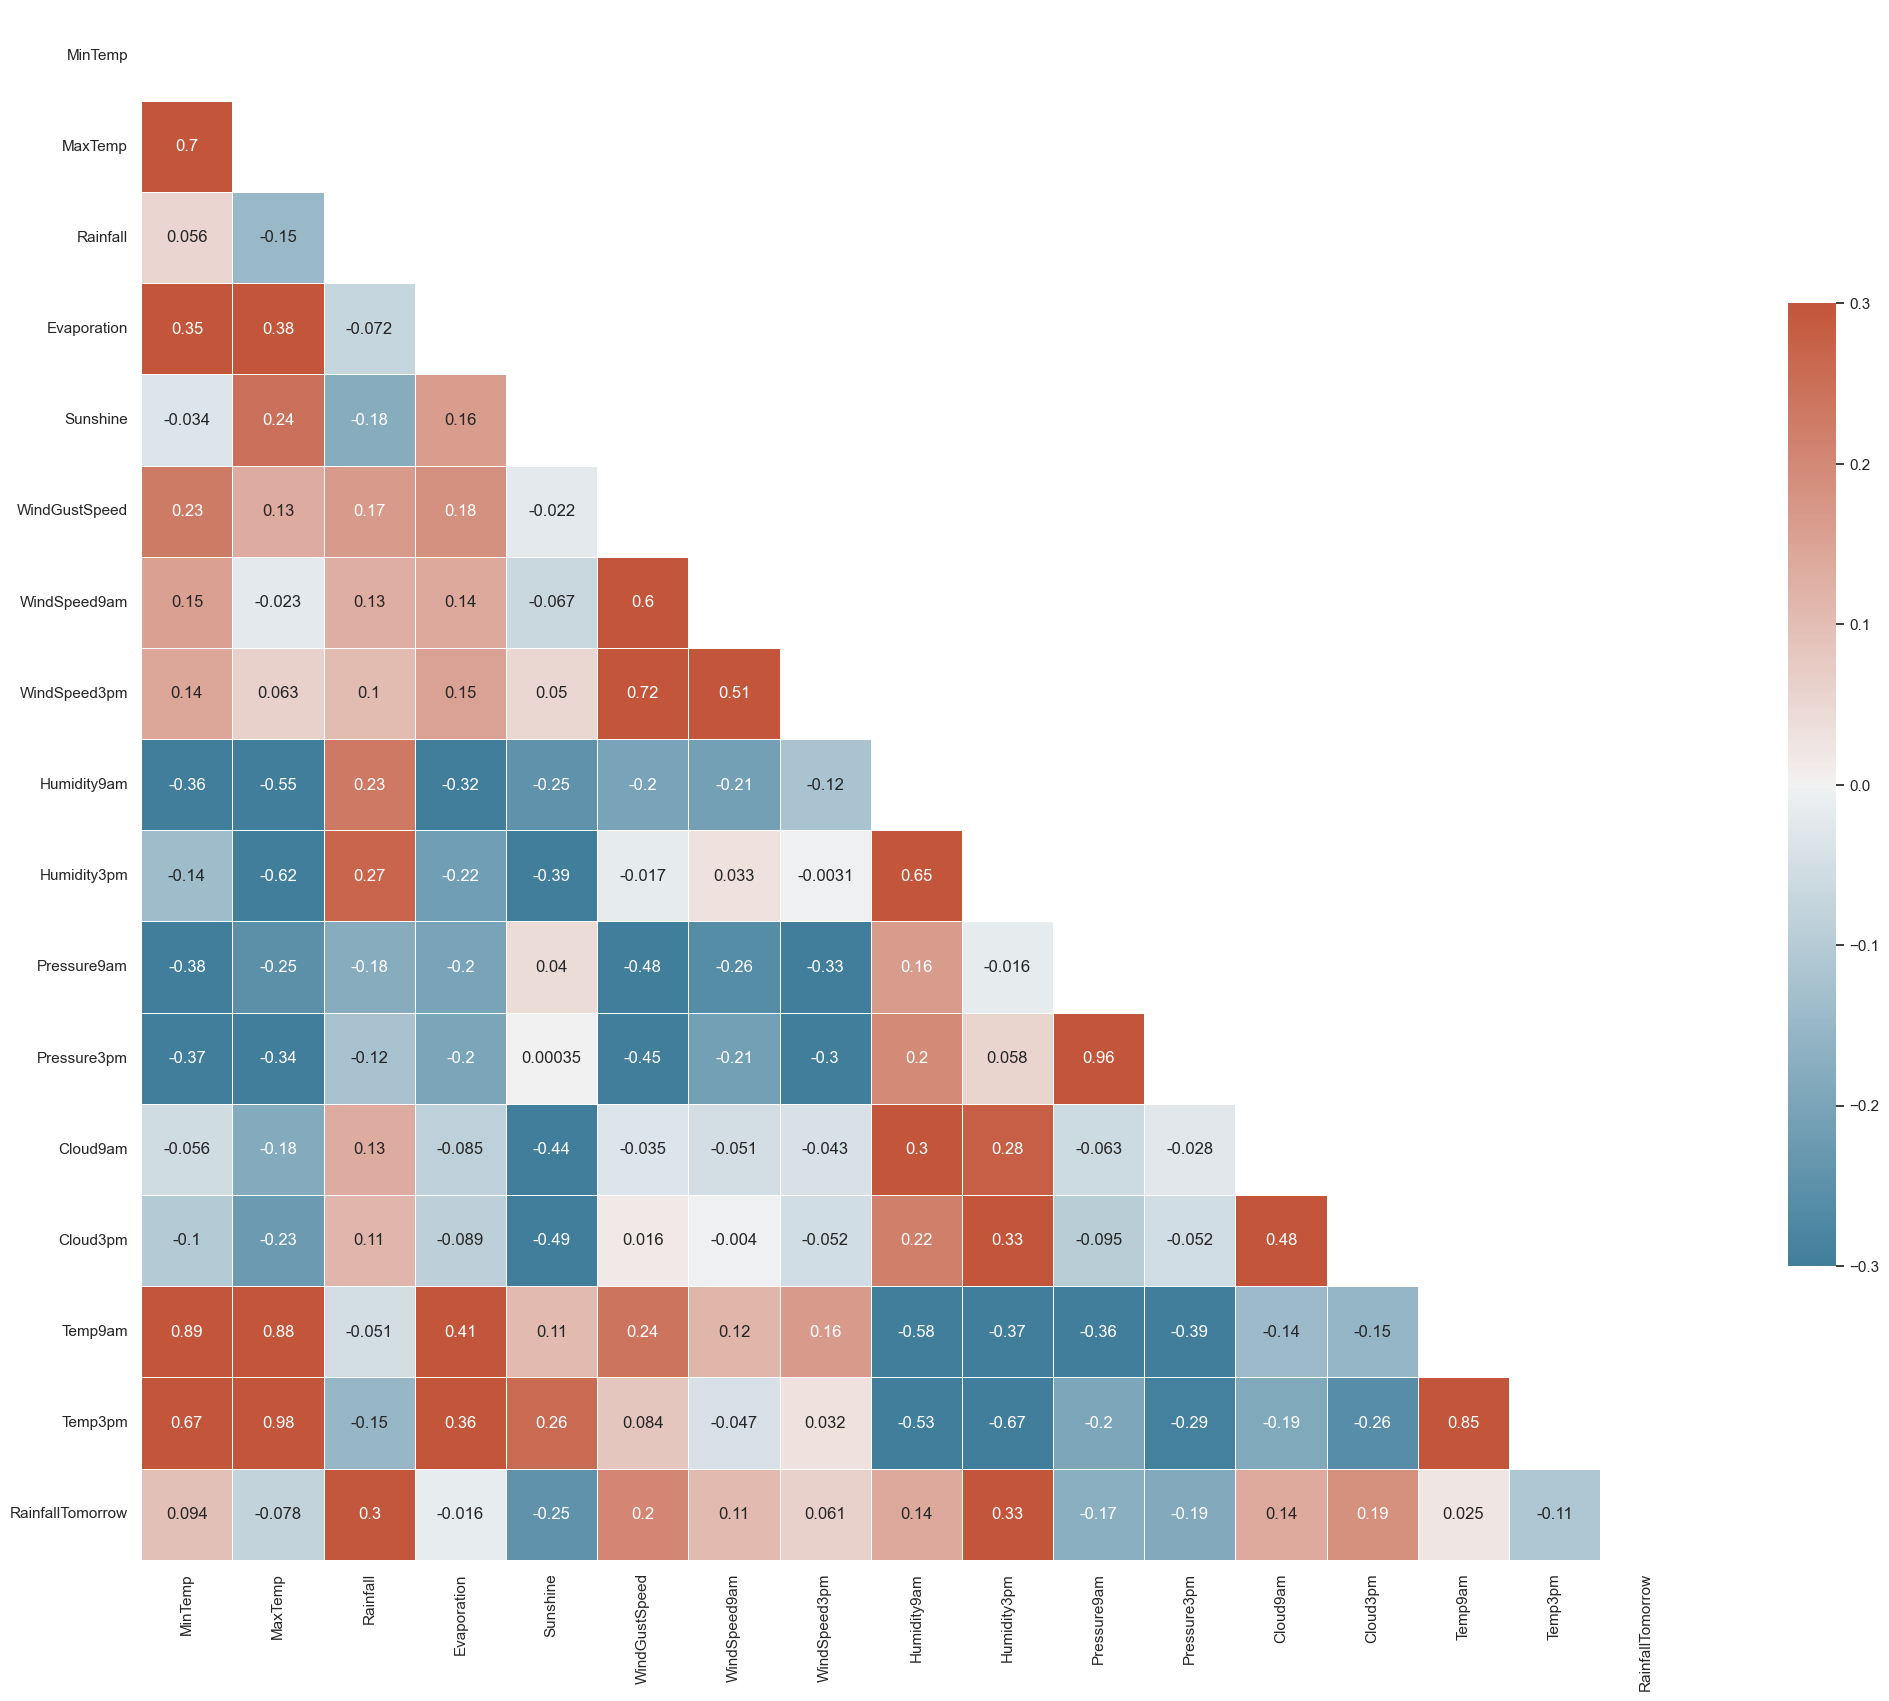

In [82]:
sns.set_theme(style="white")
# Compute the correlation matrix
corr = test_dummies[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainfallTomorrow']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3,center=0, square=True,annot=True ,linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

- *MaxTemp y MinTemp (0.7)*: Hay una correlación positiva fuerte entre la temperatura máxima y mínima del día. Esto significa que, generalmente, los días con altas temperaturas máximas también tienen altas temperaturas mínimas.

- *Evaporation y MaxTemp (0.38):* Existe una correlación positiva moderada entre la evaporación y la temperatura máxima. Esto indica que días más calientes tienden a tener mayor evaporación.

- *Humidity3pm y Humidity9am (0.65):* Hay una correlación positiva fuerte entre la humedad a las 3pm y la humedad a las 9am, lo cual es esperable ya que la humedad a lo largo del día tiende a estar relacionada.

- *Pressure3pm y Pressure9am (0.96)*: Hay una correlación positiva muy fuerte entre la presión atmosférica a las 3pm y la presión a las 9am, indicando que los cambios de presión son generalmente consistentes a lo largo del día.

- *Temp3pm y Temp9am (0.85):* La temperatura a las 3pm y a las 9am están fuertemente correlacionadas positivamente, lo cual es lógico ya que la temperatura de la mañana influye en la temperatura del resto del día.

- **RainTomorrow y Humidity3pm (0.33): **Hay una correlación positiva moderada entre la humedad a las 3pm y la probabilidad de lluvia mañana. Esto sugiere que mayor humedad por la tarde puede estar asociada con mayor probabilidad de lluvia el día siguiente.

- *RainTomorrow y Rainfall (0.058):* Hay una correlación positiva muy débil entre la cantidad de lluvia y si va a llover mañana. Aunque es débil, indica que hay cierta relación entre la cantidad de lluvia hoy y la probabilidad de lluvia mañana.

- *RainTomorrow y Pressure3pm (-0.11):* Hay una correlación negativa débil entre la presión atmosférica por la tarde y la probabilidad de lluvia mañana. Bajos niveles de presión pueden estar asociados con mayor probabilidad de lluvia.


Las variables climáticas más relevantes que parecen influir en la probabilidad de lluvia mañana *(RainTomorrow)* son la humedad a las 3pm *(Humidity3pm), la cantidad de lluvia **(Rainfall), y la presión atmosférica a las 3pm **(Pressure3pm)*. Estas variables pueden ser útiles para construir un modelo predictivo.

## Comparación


Al comparar la matriz de correlación de los datos de prueba (test) con la de los datos de entrenamiento (train), podemos observar diferencias y similitudes.

- Consistencia de las Correlaciones Fuertes:

 - MaxTemp y MinTemp: En ambas matrices, esta correlación es fuerte (0.7), lo cual indica que esta relación es consistente en ambos conjuntos de datos.
 - Pressure3pm y Pressure9am: También muestra una fuerte correlación en ambos conjuntos (0.96), lo que sugiere que la presión atmosférica es consistentemente relacionada en ambos momentos del día.

- Diferencias en Correlaciones Moderadas y Débiles:

  - Evaporation y MaxTemp: En el conjunto de prueba, la correlación es 0.59, mientras que en el conjunto de entrenamiento es 0.38. Esto sugiere que la relación entre evaporación y temperatura máxima es más fuerte en los datos de prueba que en los de entrenamiento.
 - Humidity3pm y Humidity9am: La correlación es 0.67 en el conjunto de prueba y 0.65 en el conjunto de entrenamiento, una diferencia menor pero indica una consistencia.
 - RainTomorrow y Humidity3pm: En el conjunto de prueba, la correlación es 0.32, mientras que en el de entrenamiento es 0.33. Aunque similar, estas pequeñas diferencias pueden afectar la predicción.

- Observaciones en el Conjunto de Entrenamiento:

 - RainTomorrow y Rainfall: En el conjunto de entrenamiento, la correlación es más débil (0.058) en comparación con el conjunto de prueba (0.25). Esto puede sugerir que la relación entre la cantidad de lluvia y la lluvia del día siguiente no es tan fuerte en los datos de entrenamiento.
 - RainTomorrow y Pressure3pm: En el conjunto de entrenamiento, la correlación es -0.11, mientras que en el conjunto de prueba es -0.17. Esto puede implicar que la presión atmosférica a las 3pm tiene una influencia más débil en la probabilidad de lluvia en los datos de entrenamiento.

## Matriz de correlación categórica

### Train

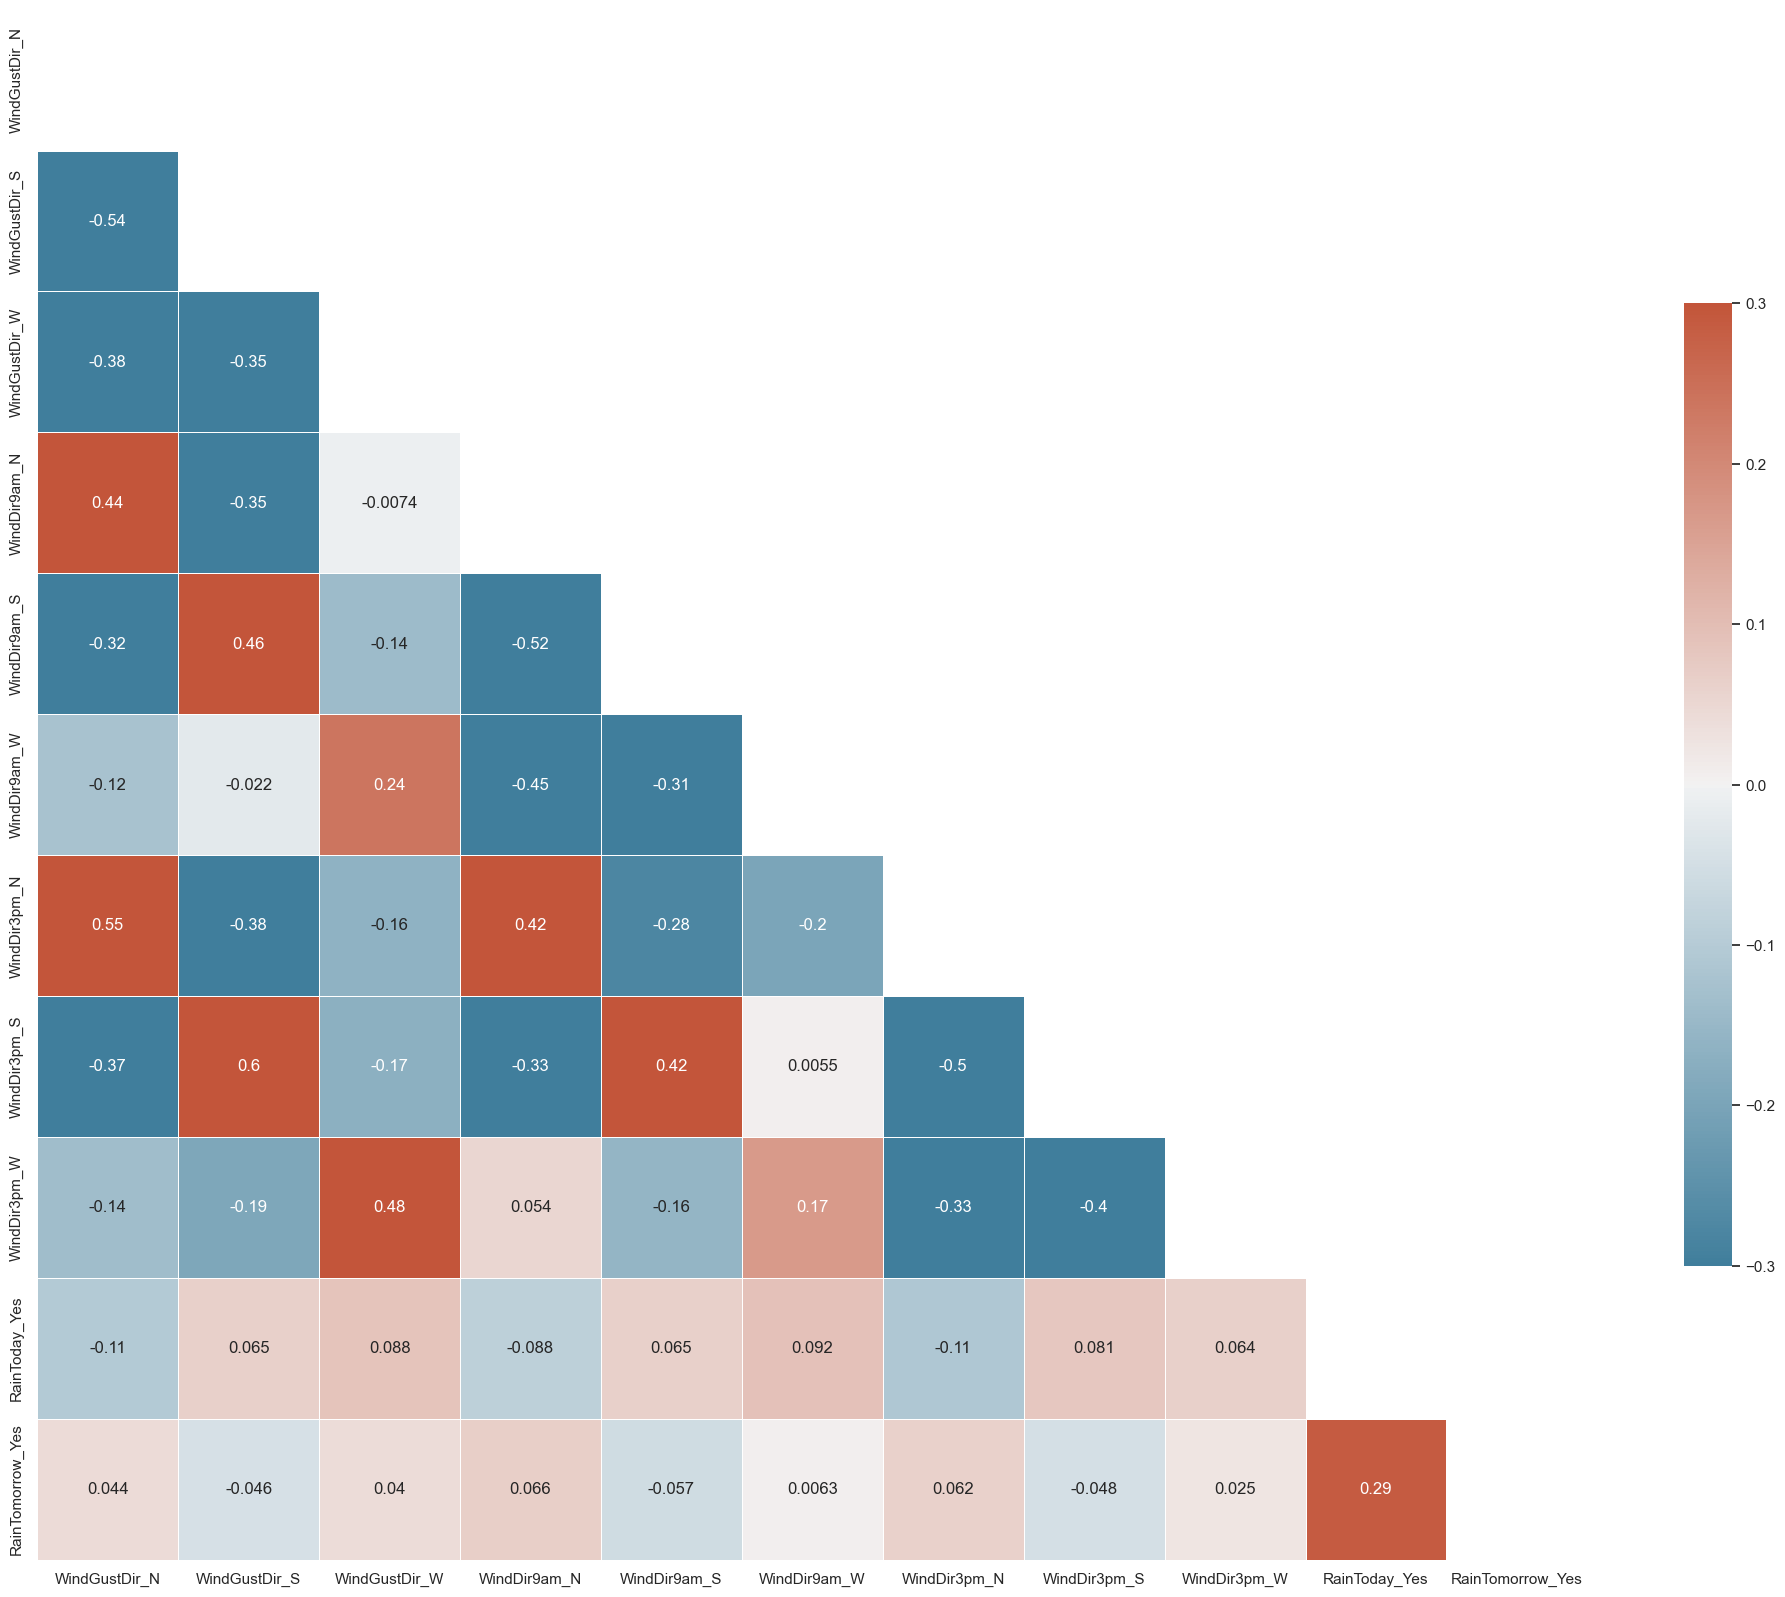

In [83]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = train_dummies[['WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'RainTomorrow_Yes']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3,center=0, square=True,annot=True ,linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Estas correlaciones entre diferentes variables meteorológicas proporcionan información útil sobre cómo ciertos aspectos del clima pueden estar relacionados entre sí en el contexto de Australia. Aquí hay algunas observaciones sobre las correlaciones que has proporcionado:

-  *WindGustDir_e y WindDir9am_e (0.34)*: Existe una correlación moderada positiva entre la dirección de la ráfaga de viento registrada por la estación meteorológica a las 9 a.m. y la dirección de la ráfaga de viento registrada por la estación meteorológica este. Esto sugiere que cuando la dirección del viento en la mañana es hacia el este, es más probable que se registren ráfagas de viento provenientes de esa misma dirección.

-  *WindGustDir_n y WindDir9am_n (0.44)*: Hay una correlación moderadamente positiva entre la dirección de la ráfaga de viento registrada por la estación meteorológica a las 9 a.m. y la dirección de la ráfaga de viento registrada por la estación meteorológica norte. Esto indica que las ráfagas de viento registradas en el norte a menudo están alineadas con la dirección del viento por la mañana.

-  *WindGustDir_s y WindDir9am_s (0.46)*: Similar al punto anterior, pero con una correlación ligeramente más fuerte, lo que sugiere una relación más estrecha entre la dirección del viento y las ráfagas de viento en el sur durante la mañana.

-  *WindGustDir_w y WindDir9am_w (0.24)*: Existe una correlación positiva más débil entre la dirección de la ráfaga de viento registrada por la estación meteorológica a las 9 a.m. y la dirección de la ráfaga de viento registrada por la estación meteorológica oeste.

-  *WindDir3pm_n y WindGustDir_n (0.55)*: Una correlación moderadamente positiva fuerte entre la dirección del viento a las 3 p.m. y la dirección de la ráfaga de viento en el norte. Esto sugiere que las ráfagas de viento en el norte están relacionadas con la dirección general del viento a las 3 p.m.

- *WindDir3pm_w y WindGustDir_w (0.48)*: Similar al punto anterior, pero con una dirección del viento en el oeste y ráfagas de viento relacionadas.

-  *WindDir3pm_n y WindDir9am_n (0.42)*: Correlación moderada positiva entre la dirección del viento a las 9 a.m. y a las 3 p.m. en el norte. Esto sugiere cierta consistencia en la dirección del viento durante el día en esa región.

- *WindDir9am_s y WindDir3pm_s (0.42)*: Correlación moderada positiva entre la dirección del viento a las 9 a.m. y a las 3 p.m. en el sur, lo que indica cierta consistencia en la dirección del viento durante el día en esa región.

Las variables climáticas más relevantes que parecen influir en la probabilidad de lluvia mañana (RainTomorrow) son las correlaciones entre la dirección del viento y la probabilidad de lluvia, además la dirección del viento en el norte a las 3 p.m. puede estar especialmente relacionada con ráfagas de viento en esa dirección, lo que podría estar asociado con sistemas climáticos que favorecen la lluvia y también  con la dirección del viento en el oeste y ráfagas de viento relacionadas .

### Test

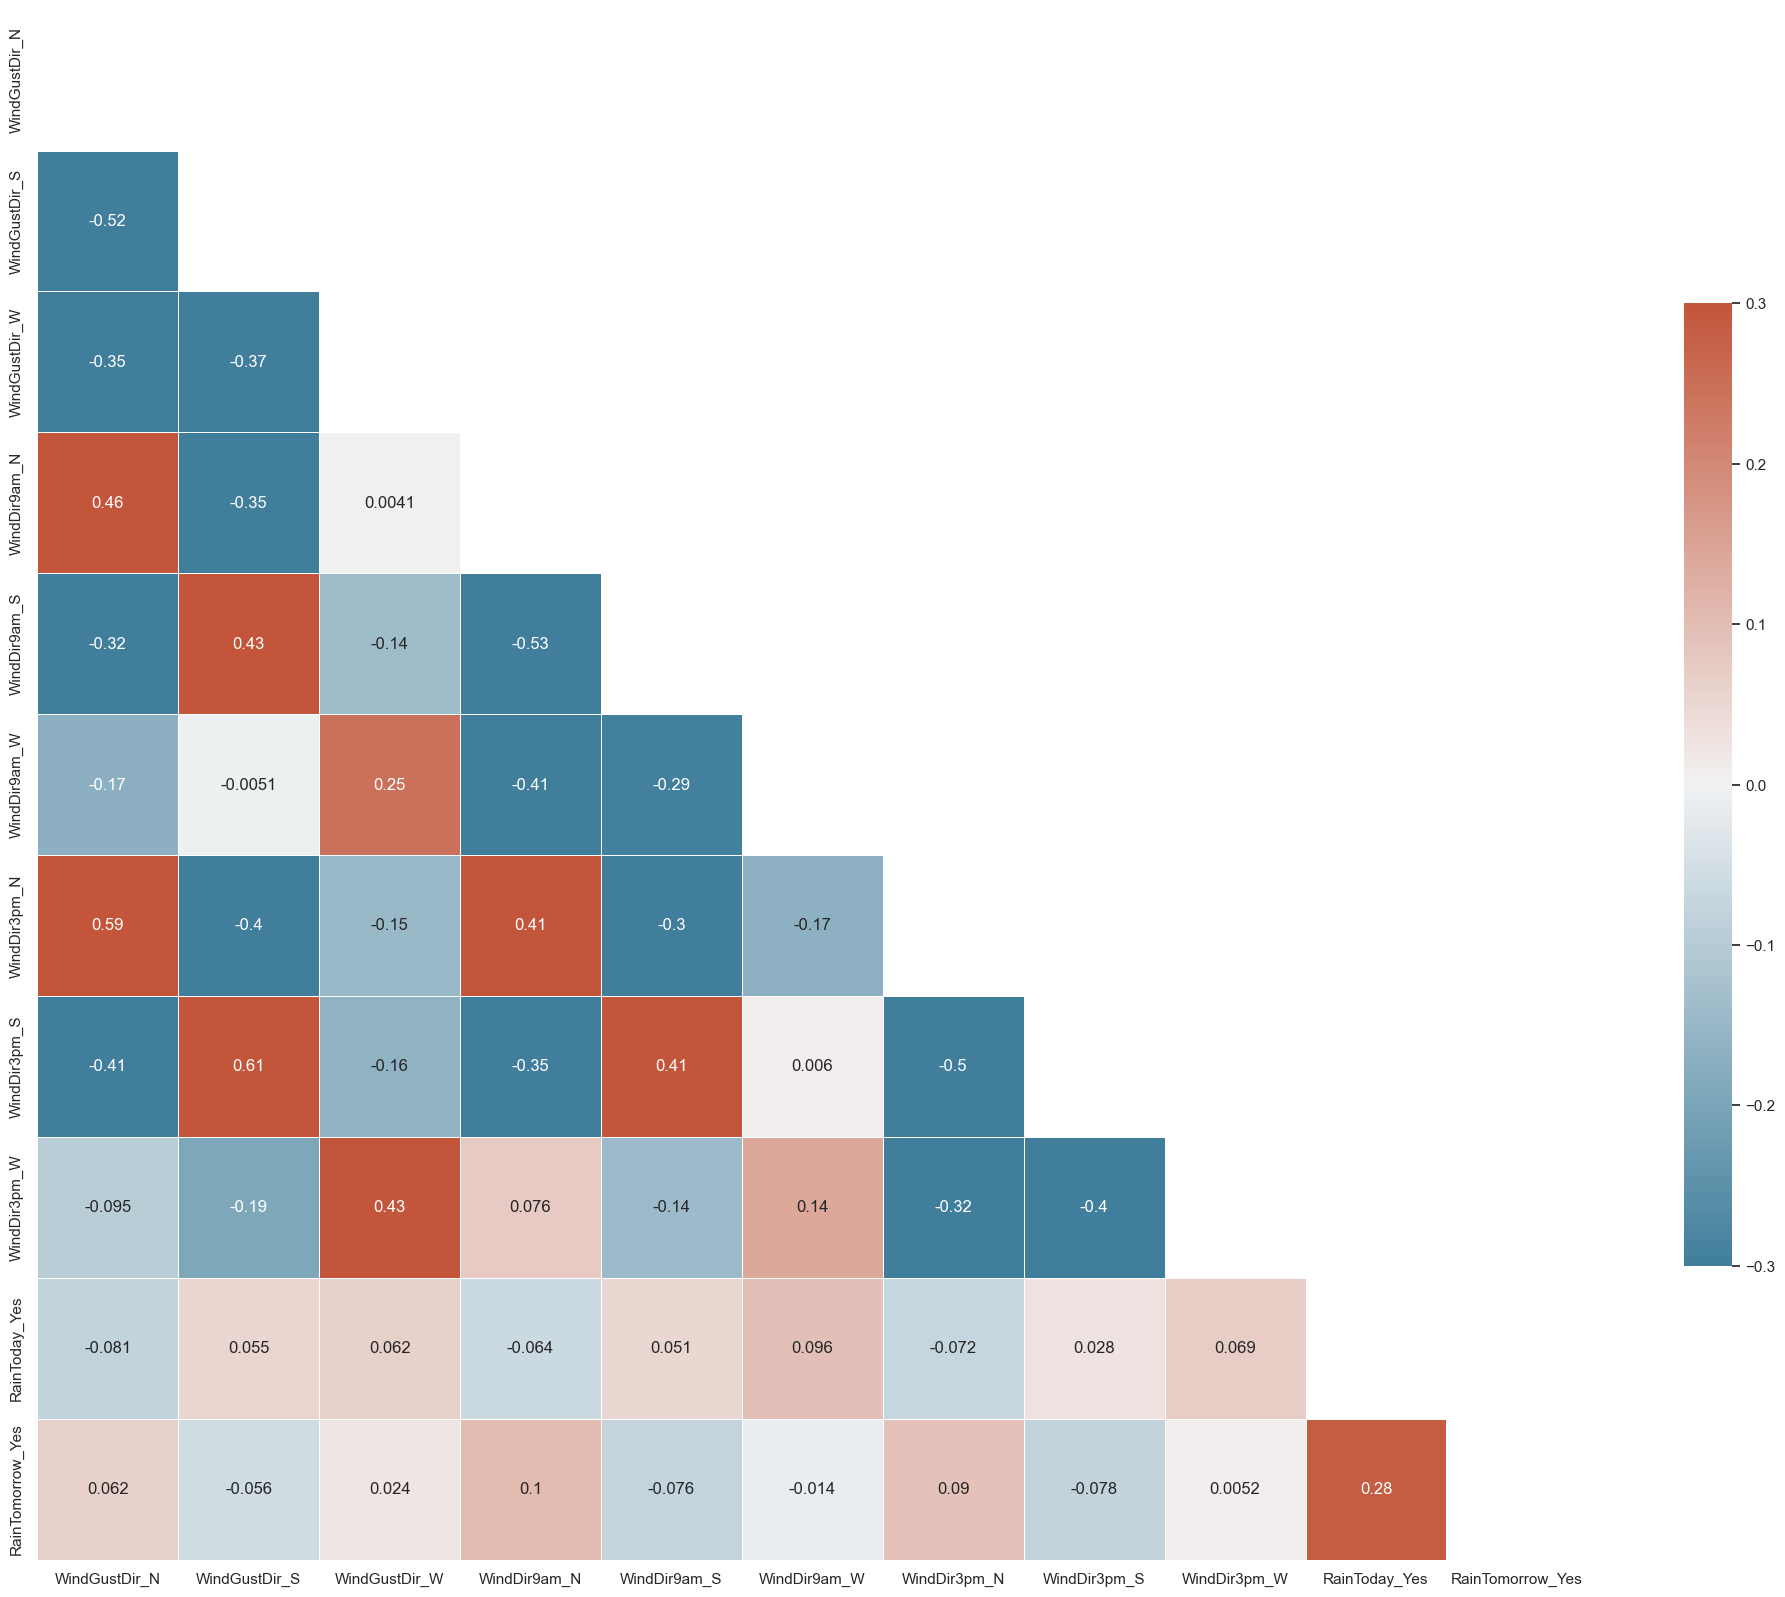

In [84]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = test_dummies[['WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'RainTomorrow_Yes']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3,center=0, square=True,annot=True ,linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

- *WindDir9am_e y WindGustDir_e (0.29)*: Existe una correlación positiva moderada entre la dirección del viento a las 9 a.m. hacia el este y la dirección de la ráfaga de viento en la misma dirección. Esto sugiere que hay una cierta consistencia en la dirección del viento y las ráfagas de viento hacia el este en la mañana.

- *WindDir9am_n y WindGustDir_n (0.46)*: La correlación positiva moderadamente fuerte entre la dirección del viento a las 9 a.m. hacia el norte y la dirección de la ráfaga de viento en la misma dirección indica una relación significativa entre estas variables en esa región específica.

- *WindDir9am_s y WindGustDir_s (0.43)*: Similar al punto anterior, pero con dirección del viento hacia el sur y ráfagas de viento en la misma dirección, sugiriendo una relación consistente entre estas variables en la mañana.

- *WindDir3pm_n y WindDir9am_n (0.41)*: Hay una correlación positiva moderada entre la dirección del viento a las 9 a.m. y a las 3 p.m. hacia el norte. Esto indica cierta persistencia en la dirección del viento en esa región durante el día.

- *WindDir3pm_s y WindGustDir_n (0.61)*: Esta correlación relativamente alta sugiere una relación fuerte entre la dirección del viento a las 3 p.m. hacia el sur y la dirección de la ráfaga de viento hacia el norte. Esto podría indicar una cierta dinámica atmosférica interesante en la región.

- *WindGustDir_n y WindDir3pm_n (0.59)*: Similar al punto anterior, pero con ráfagas de viento hacia el norte y dirección del viento a las 3 p.m. hacia el norte, indicando una relación robusta entre estas variables en esa región específica.

- *WindDir3pm_e y WindGustDir_e (0.43)*: Correlación positiva moderada entre la dirección del viento a las 3 p.m. hacia el este y la dirección de la ráfaga de viento en la misma dirección. Esto sugiere una consistencia en la dirección del viento y las ráfagas de viento hacia el este en la tarde.

## Comparación

Al comparar las matrices de correlación entre los datos de entrenamiento (train) y los datos de prueba (test), podemos identificar similitudes y diferencias que proporcionan información sobre la consistencia de las relaciones entre variables en ambos conjuntos de datos.

Diferencias en Correlaciones Moderadas y Débiles:

WindDir9am_n y WindGustDir_n: En el conjunto de entrenamiento, la correlación es 0.46, mientras que en el conjunto de prueba es 0.59. Esto sugiere que la relación entre la dirección del viento a las 9 a.m. hacia el norte y las ráfagas de viento en la misma dirección es más fuerte en los datos de prueba que en los de entrenamiento.

WindDir3pm_s y WindGustDir_n: En el conjunto de entrenamiento, la correlación es 0.61, mientras que en el conjunto de prueba no se proporciona la correlación. Esta diferencia sugiere una discrepancia en la relación entre la dirección del viento a las 3 p.m. hacia el sur y las ráfagas de viento en el norte entre los conjuntos de datos.

# División del conjunto de datos de entrenamiento


## Regresión Lineal

**y_train & y_proces:**
- Elimina las características especificadas de train_processed para de esta forma solo quedarnos con nuestro variable target "RainfallTomorrow".

**x_train & x_proces:**
- Elimina "RainfallTomorrow" para de esta forma solo quedarnos con las características que serán utilizadas para predecir la variable “RainfallTomorrow”.

In [85]:
# Train
y_train_rl = train_dummies.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'RainTomorrow_Yes'], axis=1)
x_train_rl = train_dummies.drop(['RainfallTomorrow', 'RainTomorrow_Yes'], axis=1)

# Test
y_test_rl = test_dummies.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'RainTomorrow_Yes'], axis=1)
x_test_rl = test_dummies.drop(['RainfallTomorrow', 'RainTomorrow_Yes'], axis=1)

## Regresión Logística (Clasificación).

**y_train & y_proces:**
- Elimina las características especificadas de train_processed para de esta forma solo quedarnos con nuestro variable target "RainTomorrow".

**x_train & x_proces:**
- Elimina "RainfallTomorrow" para de esta forma solo quedarnos con las características que serán utilizadas para predecir la variable “RainTomorrow”.

In [86]:
# Train
y_train_rlog = train.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainfallTomorrow'], axis=1)
x_train_rlog = train_dummies.drop(['RainfallTomorrow', 'RainTomorrow_Yes'], axis=1)

# Test
y_test_rlog = test.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainfallTomorrow'], axis=1)
x_test_rlog = test_dummies.drop(['RainfallTomorrow', 'RainTomorrow_Yes'], axis=1)

In [87]:
# Codificar las etiquetas
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_rlog.values.flatten())
y_test_encoded = le.fit_transform(y_test_rlog.values.flatten())

# Regresión Lineal y Gradiente descendiente

## Regresión Lineal

In [88]:
# Crea una instancia del modelo de regresión lineal
model_rl = LinearRegression()
model_rl.fit(x_train_rl, y_train_rl)

LinearRegression()

In [89]:
y_train_pred = model_rl.predict(x_train_rl)
y_pred = model_rl.predict(x_test_rl)

#### Coeficiente e Intercepción

In [90]:
coefficients = model_rl.coef_
intercept = model_rl.intercept_
print("Coefficients:", coefficients)
print(f"\nIntercept:", intercept)

Coefficients: [[-0.0407449   0.07603522  0.14962785  0.01279303 -0.13009594  0.20800795
  -0.01604192 -0.08974218 -0.06016079  0.35349013  0.46445679 -0.53846508
  -0.02748936  0.0291743   0.01264246  0.01904106 -0.06952425 -0.06076414
  -0.07279977 -0.13607759 -0.06639044 -0.10705435 -0.01214293  0.02829295
   0.02130573  0.06009669]]

Intercept: [0.13281419]


**Coeficientes**

Tenemos un vector de coeficientes con valores que varían desde aproximadamente -2.81e+11 hasta 3.18e+12. Estos números son bastante grandes, lo que podría indicar que algunas de las variables pueden estar correlacionadas o que los datos podrían no estar normalizados.

Dado que los datos están normalizados, esto significa que los coeficientes representan el cambio esperado en la variable dependiente para un cambio de una desviación estándar en la variable independiente correspondiente.

Por lo tanto, podemos comparar directamente los coeficientes entre sí para determinar qué variables tienen un mayor impacto en la variable dependiente. Un coeficiente con un valor absoluto mayor indica que esa variable tiene un efecto más fuerte en la variable dependiente.

**Intercepción**

El término de intercepción es -2.93e+12, que es el valor esperado de Y cuando todas las variables independientes (X) son 0.

#### Métricas del set de entrenamiento

In [91]:
# MSE: Error Cuadratico Medio
mse_train = mean_squared_error(y_train_rl, y_train_pred)

# R^2
r2_train = r2_score(y_train_rl, y_train_pred)

# MAE: Error Absoluto Medio
mae_train = mean_absolute_error(y_train_rl, y_train_pred)

# RMSE: Raíz del Error Cuadrático Medio
rmse_train = np.sqrt(mean_squared_error(y_train_rl, y_train_pred))

print(f"\nR²: {r2_train}\n")
print(f"MSE(Error Cuadratico Medio): {mse_train}\n")
print(f"MAE(Error Absoluto Medio): {mae_train}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse_train}\n")


R²: 0.21662048257699917

MSE(Error Cuadratico Medio): 0.7833795174230008

MAE(Error Absoluto Medio): 0.41760788877604416

RMSE(Raíz del Error Cuadrático Medio): 0.8850872936739069



**R²**

El coeficiente de determinación (R²) es 0.2165. Este valor varía entre 0 y 1, y representa la proporción de la varianza total de la variable dependiente explicada por el modelo. Nuestro R² de 0.2165 significa que el modelo explica aproximadamente el 21.65% de la variabilidad en los datos, lo cual no es muy alto.

**MSE**

El Error Cuadrático Medio (MSE) es 0.7835. Esta métrica mide el promedio de los errores al cuadrado, es decir, la diferencia entre el valor estimado y el valor real. Cuanto más cerca de 0 esté este valor, mejor será el modelo. Nuestro MSE de 0.7835 significa que en el modelo hay mucha diferencia entre el calor estimado y el real.

**MAE**

El Error Absoluto Medio (MAE) es 0.4174. Esta métrica mide el promedio de los errores absolutos, es decir, la diferencia absoluta entre el valor estimado y el valor real. Al igual que con el MSE, cuanto más cerca de 0 esté este valor, mejor será el modelo. Al igual que en MSE significa que en el modelo hay diferencia entre el calor estimado y el real, pero es más chicha esta diferencia.

**RMSE**

La Raíz del Error Cuadrático Medio (RMSE) es 0.8851. Esta métrica es la raíz cuadrada del MSE y tiene la ventaja de estar en las mismas unidades que la variable dependiente. También penaliza más los errores grandes que el MAE.

#### Métricas del set de testeo

In [92]:
# MSE: Error Cuadratico Medio
mse = mean_squared_error(y_test_rl, y_pred)

# R^2
r2 = r2_score(y_test_rl, y_pred)

# MAE: Error Absoluto Medio
mae = mean_absolute_error(y_test_rl, y_pred)

# RMSE: Raíz del Error Cuadrático Medio
rmse = np.sqrt(mean_squared_error(y_test_rl, y_pred))

print(f"\nR²: {r2}\n")
print(f"MSE(Error Cuadratico Medio): {mse}\n")
print(f"MAE(Error Absoluto Medio): {mae}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse}\n")


R²: 0.25425408690412266

MSE(Error Cuadratico Medio): 0.7457459130958772

MAE(Error Absoluto Medio): 0.4180813647453726

RMSE(Raíz del Error Cuadrático Medio): 0.8635658128341333



**R²**

El coeficiente de determinación (R²) es 0.2544. Este valor varía entre 0 y 1, y representa la proporción de la varianza total de la variable dependiente explicada por el modelo. Nuestro R² de 0.2544 significa que el modelo explica aproximadamente el 25.44% de la variabilidad en los datos, lo cual no es muy alto.

**MSE**

El Error Cuadrático Medio (MSE) es 0.7455. Esta métrica mide el promedio de los errores al cuadrado, es decir, la diferencia entre el valor estimado y el valor real. Cuanto más cerca de 0 esté este valor, mejor será el modelo. Nuestro MSE de 0.7455 significa que en el modelo hay mucha diferencia entre el calor estimado y el real.

**MAE**

El Error Absoluto Medio (MAE) es 0.4177. Esta métrica mide el promedio de los errores absolutos, es decir, la diferencia absoluta entre el valor estimado y el valor real. Al igual que con el MSE, cuanto más cerca de 0 esté este valor, mejor será el modelo. Al igual que en MSE significa que en el modelo hay diferencia entre el calor estimado y el real, pero es más chicha esta diferencia.

**RMSE**

La Raíz del Error Cuadrático Medio (RMSE) es 0.8635. Esta métrica es la raíz cuadrada del MSE y tiene la ventaja de estar en las mismas unidades que la variable dependiente. También penaliza más los errores grandes que el MAE.

### Conlcusión

**Evaluación del rendimiento del modelo:** Las métricas del conjunto de entrenamiento nos dan una idea de cómo se está desempeñando el modelo en los datos que está utilizando para aprender. Por otro lado, las métricas del conjunto de prueba nos muestran cómo se desempeña el modelo en datos nuevos e invisibles, lo cual es un indicador más realista de cómo se comportará el modelo en el mundo real.

**Detección de sobreajuste y subajuste:** Si el error de entrenamiento es bajo pero el error de prueba es alto, esto puede indicar un sobreajuste, lo que significa que el modelo ha aprendido los datos de entrenamiento “demasiado bien” y no generaliza bien a nuevos datos. Por otro lado, si tanto el error de entrenamiento como el de prueba son altos, esto puede indicar un subajuste, lo que significa que el modelo no ha aprendido suficientemente bien los datos de entrenamiento.

**Selección y ajuste de modelos:** Al comparar las métricas de entrenamiento y prueba, podemos tomar decisiones informadas sobre la selección del modelo (por ejemplo, qué tipo de modelo usar) y el ajuste del modelo (por ejemplo, cómo ajustar los hiperparámetros del modelo).

En nuestro caso, las métricas del conjunto de entrenamiento y prueba son bastante similares, lo que es una buena señal de que el modelo no está sobreajustado. Sin embargo, el valor de R² es relativamente bajo tanto para el conjunto de entrenamiento como para el de prueba, lo que indica que el modelo podría no estar capturando toda la variabilidad en los datos. Podríamos considerar probar diferentes tipos de modelos o ajustar los hiperparámetros para tratar de mejorar estas métricas.

## Gradiente descendiente

In [93]:
# Regresión lineal utilizando SGDRegressor
model_sgd = SGDRegressor(max_iter=1000, tol=1e-3)
model_sgd.fit(x_train_rl, y_train_rl.values.ravel())

SGDRegressor()

In [94]:
y_pred_sgd = model_sgd.predict(x_test_rl)

In [95]:
y_train_pred_sgd = model_sgd.predict(x_train_rl)

#### Coeficiente e Intercepción

In [96]:
coefficients_sgd = model_sgd.coef_
intercept_sgd = model_sgd.intercept_
print("Coefficients (SGD):", coefficients_sgd)
print(f"\nIntercept (SGD):", intercept_sgd)

Coefficients (SGD): [-0.04460268  0.07832745  0.14262246  0.02818701 -0.12008152  0.22236756
 -0.01439352 -0.07551785 -0.05751234  0.33548672  0.43990733 -0.51151613
 -0.02727889  0.03863413  0.00424898  0.0469611  -0.06972189 -0.05535244
 -0.07062411 -0.13118559 -0.0632127  -0.10810167 -0.01539587  0.01851106
  0.01044343  0.0604405 ]

Intercept (SGD): [0.13245094]


#### Métricas del set de entrenamiento

In [97]:
# MSE: Error Cuadratico Medio
mse_train_sgd = mean_squared_error(y_train_rl, y_train_pred_sgd)

# R^2
r2_train_sgd = r2_score(y_train_rl, y_train_pred_sgd)

# MAE: Error Absoluto Medio
mae_train_sgd = mean_absolute_error(y_train_rl, y_train_pred_sgd)

# RMSE: Raíz del Error Cuadrático Medio
rmse_train_sgd = np.sqrt(mean_squared_error(y_train_rl, y_train_pred_sgd))

print(f"\nR²: {r2_train_sgd}\n")
print(f"MSE(Error Cuadratico Medio): {mse_train_sgd}\n")
print(f"MAE(Error Absoluto Medio): {mae_train_sgd}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse_train_sgd}\n")


R²: 0.21354670177693247

MSE(Error Cuadratico Medio): 0.7864532982230675

MAE(Error Absoluto Medio): 0.4151089521164012

RMSE(Raíz del Error Cuadrático Medio): 0.88682202172875



#### Métricas del set de testeo

In [98]:
# MSE: Error Cuadrático Medio
mse_sgd = mean_squared_error(y_test_rl, y_pred_sgd)

# R^2
r2_sgd = r2_score(y_test_rl, y_pred_sgd)

# MAE: Error Absoluto Medio
mae_sgd = mean_absolute_error(y_test_rl, y_pred_sgd)

# RMSE: Raíz del Error Cuadrático Medio
rmse_sgd = np.sqrt(mse_sgd)

print(f"\nR² (SGD): {r2_sgd}\n")
print(f"MSE (SGD): {mse_sgd}\n")
print(f"MAE (SGD): {mae_sgd}\n")
print(f"RMSE (SGD): {rmse_sgd}\n")


R² (SGD): 0.24988398504446763

MSE (SGD): 0.7501160149555323

MAE (SGD): 0.41633410985036257

RMSE (SGD): 0.8660923824601694



## Comparación

In [99]:
# Crear un diccionario con los resultados
results = {
    'Model': ['Regresión Lineal', 'Regresión Lineal', 'Gradiente descendiente', 'Gradiente descendiente'],
    'Data': ['Train', 'Test', 'Train', 'Test'],
    'R²': [r2_train, r2, r2_train_sgd, r2_sgd],
    'MSE': [mse_train, mse, mse_train_sgd, mse_sgd],
    'MAE': [mae_train, mae, mae_train_sgd, mae_sgd],
    'RMSE': [rmse_train, rmse, rmse_train_sgd, rmse_sgd]
}

# Convertir el diccionario en un DataFrame
df_comparativo = pd.DataFrame(results)

df_comparativo

,Model,Data,R²,MSE,MAE,RMSE
0,Regresión Lineal,Train,0.216620,0.783380,0.417608,0.885087
1,Regresión Lineal,Test,0.254254,0.745746,0.418081,0.863566
2,Gradiente descendiente,Train,0.213547,0.786453,0.415109,0.886822
3,Gradiente descendiente,Test,0.249884,0.750116,0.416334,0.866092


El cambio fue prácticamente nulo.

In [100]:
def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de test')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

In [101]:
y_train_gd = y_train_rl.values.reshape(-1, 1)
y_test_gd = y_test_rl.values.reshape(-1, 1)

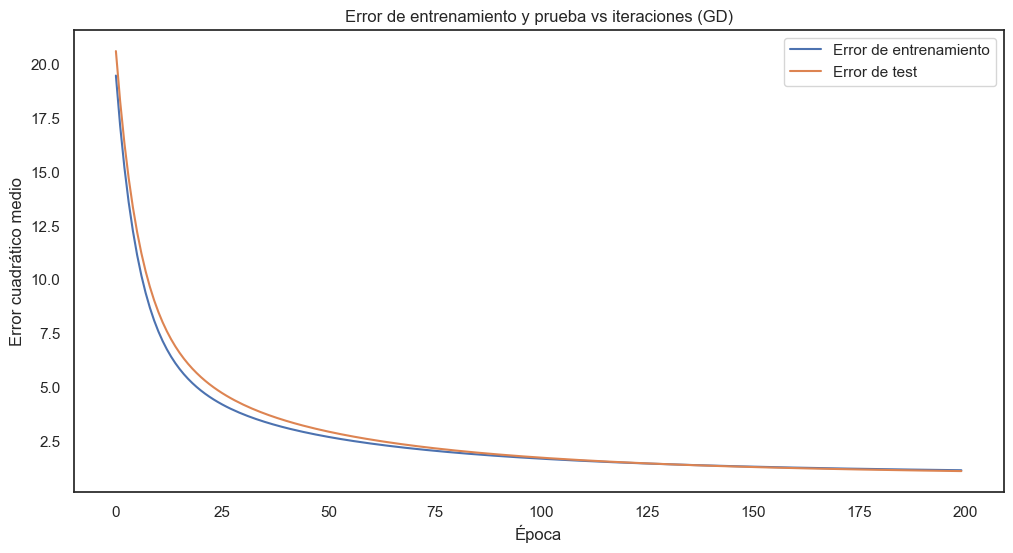

array([[ 1.30679256],
       [-0.18014507],
       [ 1.4095961 ],
       [ 0.09941008],
       [-0.22690907],
       [-0.04761881],
       [-0.0949225 ],
       [ 0.13673887],
       [-0.01079328],
       [-0.34350975],
       [ 0.4968814 ],
       [ 0.28549147],
       [-0.51802468],
       [ 0.04295991],
       [ 0.00693652],
       [ 0.02981884],
       [-1.24518693],
       [-0.58677029],
       [-0.16258577],
       [-0.36527965],
       [-0.94055752],
       [-0.19843165],
       [-0.70460706],
       [ 0.04191186],
       [-0.75756872],
       [-0.53513649],
       [ 0.28281218]])

In [102]:
gradient_descent(x_train_rl, y_train_gd, x_test_rl, y_test_gd, lr=0.01, epochs=200)

**Disminución de los errores:** Ambos, el error de entrenamiento (azul) y el error de prueba (naranja), disminuyen a medida que aumenta el número de épocas. Esto indica que el modelo está aprendiendo de los datos de entrenamiento y mejorando su rendimiento a medida que se entrena.

**Convergencia de los errores:** Parece que después de cierto número de épocas, los errores de entrenamiento y prueba comienzan a converger, lo que sugiere que el modelo puede estar llegando a su mejor rendimiento.

**Posible sobreajuste:** Si el error de entrenamiento sigue disminuyendo significativamente mientras que el error de prueba deja de disminuir o incluso comienza a aumentar, esto podría ser un indicio de sobreajuste. Sin embargo, en este caso, ambos errores parecen disminuir a un ritmo similar, lo que es una buena señal.

**Elección del número de épocas:** Este gráfico puede ayudar a elegir el número óptimo de épocas para entrenar un modelo. Podría detener el entrenamiento cuando el error de prueba deje de disminuir para evitar el sobreajuste y ahorrar tiempo de computación.

# Lasso, Ridge y Elastic Net

## Lasso

In [103]:
lasso = Lasso(alpha=0.1) # alpha controla la fuerza de la regularización L1 (Lasso)
lasso.fit(x_train_rl, y_train_rl)

Lasso(alpha=0.1)

In [104]:
print("Coeficientes del modelo Lasso:")
print(lasso.coef_)
print("\nCoeficientes del modelo Lasso de train:", lasso.score(x_train_rl, y_train_rl))
print("Coeficientes del modelo Lasso de test:", lasso.score(x_test_rl, y_test_rl))

Coeficientes del modelo Lasso:
[ 0.          0.          0.08278177  0.         -0.07165773  0.04170011
  0.          0.          0.          0.16918611 -0.         -0.05764961
  0.          0.          0.          0.          0.         -0.
 -0.          0.         -0.         -0.          0.         -0.
 -0.          0.        ]

Coeficientes del modelo Lasso de train: 0.15547992197797988
Coeficientes del modelo Lasso de test: 0.1670003273335815


## Ridge

In [105]:
ridge = Ridge(alpha=0.1) # alpha controla la fuerza de la regularización L2 (Ridge)
ridge.fit(x_train_rl, y_train_rl)

Ridge(alpha=0.1)

In [106]:
print("Coeficientes del modelo Ridge:")
print(ridge.coef_)
print("\nCoeficientes del modelo Ridge de train:", ridge.score(x_train_rl, y_train_rl))
print("Coeficientes del modelo Ridge de test:", ridge.score(x_test_rl, y_test_rl))

Coeficientes del modelo Ridge:
[[-0.04074709  0.07602491  0.14962724  0.01279041 -0.13009776  0.20800436
  -0.01604377 -0.0897411  -0.06016017  0.35348596  0.46436374 -0.53837418
  -0.02748946  0.02917376  0.0126386   0.01906091 -0.06951272 -0.06075797
  -0.07279264 -0.13606374 -0.06637975 -0.10704395 -0.01214465  0.02827147
   0.02128445  0.06008676]]

Coeficientes del modelo Ridge de train: 0.21662048212645457
Coeficientes del modelo Ridge de test: 0.25425280596147526


## Elastic Net

In [107]:
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)
elasticnet.fit(x_train_rl, y_train_rl)

ElasticNet(alpha=0.1)

In [108]:
print("Coeficientes del modelo ElasticNet:")
print(elasticnet.coef_)
print("\nCoeficientes del modelo ElasticNet de train:", elasticnet.score(x_train_rl, y_train_rl))
print("Coeficientes del modelo ElasticNet de test:", elasticnet.score(x_test_rl, y_test_rl))

Coeficientes del modelo ElasticNet:
[ 0.          0.          0.1093591   0.         -0.09956843  0.06927672
  0.         -0.          0.          0.19300426 -0.         -0.08674792
  0.          0.00108018  0.00941938  0.          0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.
 -0.          0.        ]

Coeficientes del modelo ElasticNet de train: 0.1776638923005498
Coeficientes del modelo ElasticNet de test: 0.19370038355860775


## Gráfico comparativo

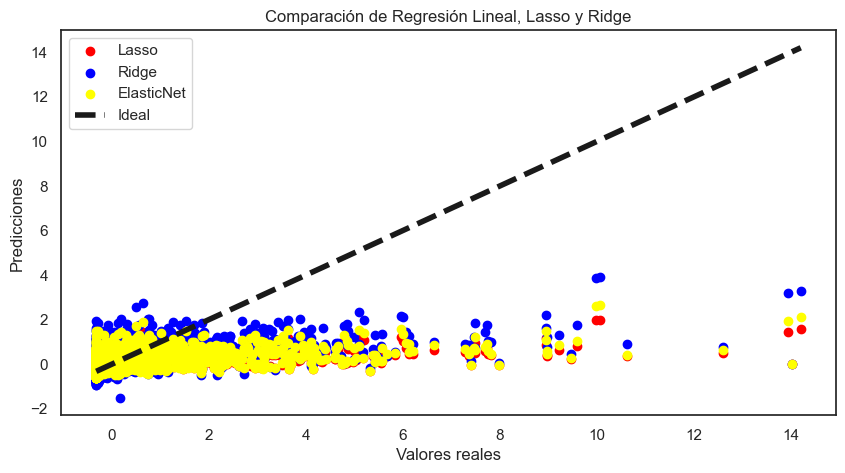

In [109]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test_rl, lasso.predict(x_test_rl), label='Lasso', color='red')
plt.scatter(y_test_rl, ridge.predict(x_test_rl), label='Ridge', color='blue')
plt.scatter(y_test_rl, elasticnet.predict(x_test_rl), label='ElasticNet', color='yellow')
plt.plot([y_test_rl.min(), y_test_rl.max()], [y_test_rl.min(), y_test_rl.max()], 'k--', lw=4, label='Ideal')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.legend()
plt.title('Comparación de Regresión Lineal, Lasso y Ridge')
plt.show()

# Regresión Logística (Clasificación).


In [110]:
# Inicializar y entrenar un modelo de regresión logística
model_c = LogisticRegression()
start = time.time()
model_c.fit(x_train_rlog, np.ravel(y_train_rlog))
end = time.time()

no_opt_time = end - start

# Realizar predicciones en el conjunto de prueba
y_pred = model_c.predict(x_test_rlog)
model_c

LogisticRegression()

In [111]:
y_pred.shape, y_test_rlog.shape

((5642,), (5642, 1))

El siguiente codigo calcula la matriz de confucion y nos da el reporte de las metricas ademas nos genera una confiaza ya que podemos evaluar bien

In [112]:
# Calcular métricas
accuracy_logreg = accuracy_score(y_test_rlog, y_pred) # compara el valor real y el predicho

confusion_matrix_logreg = confusion_matrix(y_test_rlog, y_pred)

classification_report_logreg = classification_report(y_test_rlog, y_pred)

# Imprimir métricas
print("Métricas para logreg:")
print(f'Precisión: {accuracy_logreg}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)

Métricas para logreg:
Precisión: 0.848103509393832
Matriz de confusión:
[[4138  225]
 [ 632  647]]
Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.87      0.95      0.91      4363
         Yes       0.74      0.51      0.60      1279

    accuracy                           0.85      5642
   macro avg       0.80      0.73      0.75      5642
weighted avg       0.84      0.85      0.84      5642



En este caso tenimoas 5642 registros en nuestro set de testeo, que 4363 pertenecen a la clase 0 y 1279 pertenecen a la case 1. (idea de si df esta desbalanceado o no)
    
El modelo tiene una precisión general del 85%, lo que indica que el 85% de las predicciones del modelo son correctas.

La clase “No” (días sin lluvia) tiene una precisión del 87% y un recall del 95%, lo que significa que el modelo es bastante bueno para predecir correctamente los días sin lluvia y para identificar la mayoría de los días sin lluvia reales.

La clase “Yes” (días con lluvia) tiene una precisión del 74% pero un recall del 50%, lo que indica que aunque el modelo es bastante preciso cuando predice días de lluvia, sólo está identificando la mitad de los días de lluvia reales.

- **Support:** es la cantidad de registros asociadas a cada una de las categorias.     

- **Precision:** es el total de las correctas sobre el total de las predicciones realizada para cada una de las categorias. (siempre tendemos a verla)

- **Recall:** Proporción de solamente las instancias positivas que predijo el modelo respecto a las positivas reales.

- **F1_socre:** composicion entre la precision y recall, entonces f1_score es ver cuan balanceado esta si se quiere la participacion de las positivas sobre las correectas totales del modelo y asi tener una idea de como se esta portando el modelo de clasificacion.

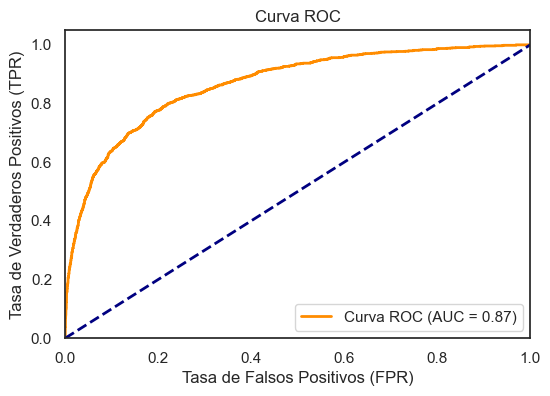

In [113]:
# Remplaza 'No' con 0 y 'Yes' con 1
y_test_binary = y_test_rlog.replace({'No': 0, 'Yes': 1})

# Obtengo las probabilidades de predicción del modelo
y_probs = model_c.predict_proba(x_test_rlog)[:, 1]

# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_probs)

roc_auc = auc(fpr, tpr)

# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

El AUC es 0.87, lo que indica que mi modelo tiene un buen rendimiento en términos de equilibrio entre sensibilidad y especificidad.

- La línea naranja representa la Curva ROC de mi modelo. Cuanto más cerca esté esta línea del borde superior izquierdo del gráfico, mejor será el modelo. Un modelo perfecto tendría un área bajo la curva (AUC) de 1.
- La línea azul representa un modelo aleatorio, con un AUC de 0.5. Cualquier modelo útil debería tener una Curva ROC que esté por encima de esta línea.

# Modelos bases.

## Regresión Lineal

In [114]:
# Dejamos unicamente como valores los de Rainfall

# Train
y_train_rl_base = train_dummies.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',  'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes'], axis=1)
x_train_rl_base = train_dummies.drop(['MinTemp', 'MaxTemp', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',  'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'RainfallTomorrow'], axis=1)

# Test
y_test_rl_base = test_dummies.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',  'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes'], axis=1)
x_test_rl_base = test_dummies.drop(['MinTemp', 'MaxTemp', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',  'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'RainfallTomorrow'], axis=1)

In [115]:
# Crea una instancia del modelo de regresión lineal
model_rl_base = LinearRegression()
model_rl_base.fit(x_train_rl_base, y_train_rl_base)

LinearRegression()

In [116]:
# Make predictions using the imputed data
y_pred_base = model_rl_base.predict(x_test_rl_base)

coefficients = model_rl_base.coef_
intercept = model_rl_base.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)

# MSE: Error Cuadratico Medio
mse_base = mean_squared_error(y_test_rl_base, y_pred_base)

# R^2
r2_base = r2_score(y_test_rl_base, y_pred_base)

# MAE: Error Absoluto Medio
mae_base = mean_absolute_error(y_test_rl_base, y_pred_base)

# RMSE: Raíz del Error Cuadrático Medio
rmse_base = np.sqrt(mean_squared_error(y_test_rl_base, y_pred_base))

print(f"\nR²: {r2_base}\n")
print(f"MSE(Error Cuadratico Medio): {mse_base}\n")
print(f"MAE(Error Absoluto Medio): {mae_base}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse_base}\n")

Coefficients: [[ 1.27292757e-01  1.24156596e+00]
 [-4.36159934e-15  1.00000000e+00]]
Intercept: [-2.85356814e-01 -1.11299858e-14]

R²: 0.6698697614850445

MSE(Error Cuadratico Medio): 0.33013023851495543

MAE(Error Absoluto Medio): 0.1376301382665542

RMSE(Raíz del Error Cuadrático Medio): 0.5745696115484663



## Clasificación

In [117]:
# Dejamos unicamente como valores los de RainToday_Yes

# Train
y_train_rlog_base  = train.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainfallTomorrow'], axis=1)
x_train_rlog_base  = train_dummies.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainfallTomorrow'], axis=1)

# Test
y_test_rlog_base  = test.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainfallTomorrow'], axis=1)
x_test_rlog_base  = test_dummies.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainfallTomorrow'], axis=1)


In [118]:
# Asegurarse de que y_train_rlog_base sea un array 1D
y_train_rlog_base = column_or_1d(y_train_rlog_base)

# Inicializar y entrenar un modelo de regresión logística
model_base = LogisticRegression()
model_base.fit(x_train_rlog_base, y_train_rlog_base)

# Verificar los nombres de las características para el conjunto de prueba
missing_features = set(model_base.feature_names_in_) - set(x_test_rlog_base.columns)
new_features = set(x_test_rlog_base.columns) - set(model_base.feature_names_in_)

if missing_features:
    print(f"Faltan características en el conjunto de prueba: {missing_features}")
    for feature in missing_features:
        x_test_rlog_base[feature] = 0  # O el valor que sea apropiado

if new_features:
    print(f"Existen nuevas características en el conjunto de prueba: {new_features}")
    x_test_rlog_base = x_test_rlog_base.drop(columns=new_features)

# Realizar predicciones en el conjunto de prueba
y_pred_base = model_base.predict(x_test_rlog_base)


In [119]:
# Calcular métricas
accuracy_logreg_base = accuracy_score(y_test_rlog_base, y_pred_base) # compara el valor real y el predicho

confusion_matrix_logreg_base = confusion_matrix(y_test_rlog_base, y_pred_base)

classification_report_logreg_base = classification_report(y_test_rlog_base, y_pred_base, zero_division=1)

# Imprimir métricas
print("Métricas para logreg:")
print(f'Precisión: {accuracy_logreg_base}')
print("Matriz de confusión:")
print(confusion_matrix_logreg_base)
print("Reporte de clasificación:")
print(classification_report_logreg_base)


Métricas para logreg:
Precisión: 1.0
Matriz de confusión:
[[4363    0]
 [   0 1279]]
Reporte de clasificación:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00      4363
         Yes       1.00      1.00      1.00      1279

    accuracy                           1.00      5642
   macro avg       1.00      1.00      1.00      5642
weighted avg       1.00      1.00      1.00      5642



# Optimización de la selección de hiperparámetros.

## KFold y StratifiedKFold

Evitamos usar Leave-One-Out ya que nuestro conjuntos de datos es grandes y sabemos que Leave-One-Out puede ser muy costoso en términos de tiempo para conjuntos de datos grandes.

In [120]:
X = x_train_rlog.values
y = y_train_rlog['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0).values

clf = RandomForestClassifier(n_estimators=50)

In [121]:
### n_splits es la cantidad de folds
cv_strategies = [
    ("KFold", KFold(n_splits=5, shuffle=True)),
    ("StratifiedKFold", StratifiedKFold(n_splits=5, shuffle=True)),
]

results = {}
for name, cv in cv_strategies:
    scores = cross_val_score(clf, X, y, cv=cv)
    results[name] = scores

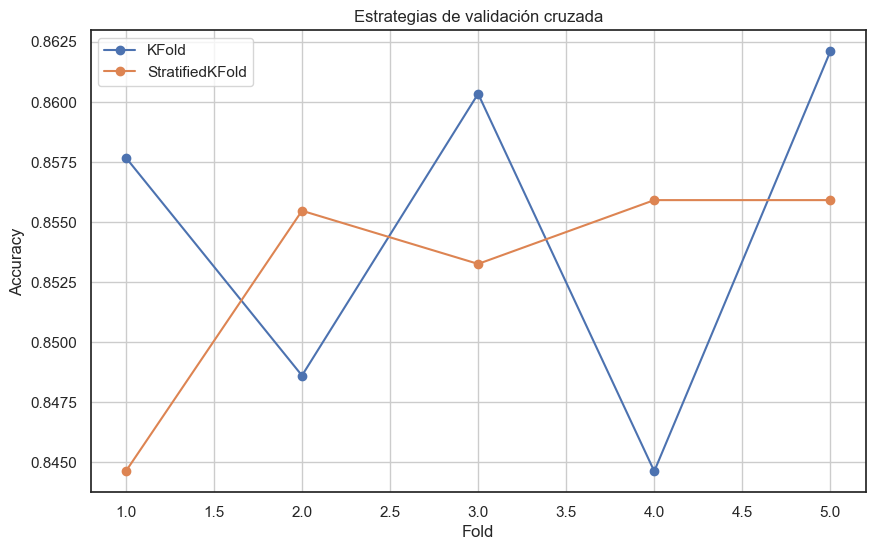

In [122]:
plt.figure(figsize=(10, 6))
for name, scores in results.items():
    plt.plot(range(1, len(scores) + 1), scores, marker='o', label=name)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Estrategias de validación cruzada")
plt.legend()
plt.grid(True)
plt.show()

In [123]:
results['KFold']

array([0.85768039, 0.84860558, 0.86033643, 0.84462151, 0.86210713])

In [124]:
for strategy in cv_strategies:
  print('Media para la estrategia', strategy[0],':',results['KFold'].mean())
  print('Desvío estándar para la estrategia', strategy[0],':',results['KFold'].std())

Media para la estrategia KFold : 0.8546702080566624
Desvío estándar para la estrategia KFold : 0.006844429061817842
Media para la estrategia StratifiedKFold : 0.8546702080566624
Desvío estándar para la estrategia StratifiedKFold : 0.006844429061817842


## Grid Search

In [125]:
# Definimos los parámetros para Grid Search
param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}
]

# Realizamos la búsqueda de hiperparámetros con Grid Search
grid_search = GridSearchCV(estimator=model_c, param_grid=param_grid, cv=5, n_jobs=-1)
start = time.time()
grid_search.fit(x_train_rlog, np.ravel(y_train_rlog))
end = time.time()
grid_search_time = end - start
y_pred_grid_search = grid_search.predict(x_test_rlog)

# Métricas para el modelo con Grid Search
grid_search_accuracy = accuracy_score(y_test_rlog, y_pred_grid_search)
grid_search_precision = precision_score(y_test_rlog, y_pred_grid_search, average='weighted')
grid_search_recall = recall_score(y_test_rlog, y_pred_grid_search, average='weighted')
grid_search_f1_score = f1_score(y_test_rlog, y_pred_grid_search, average='weighted')


print('Accuracy:', grid_search_accuracy)
print('Precision:', grid_search_precision)
print('Recall:', grid_search_recall)
print('F1 Score:', grid_search_f1_score)

Accuracy: 0.8452676355902162
Precision: 0.8358898940836644
Recall: 0.8452676355902162
F1 Score: 0.8325096574235985


## Random Search

In [126]:
# Definimos los parámetros para Random Search
random_param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': np.logspace(-4, 4, 20)},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': np.logspace(-4, 4, 20)}
]

# Realizamos la búsqueda de hiperparámetros con Random Search
random_search = RandomizedSearchCV(estimator=model_c, param_distributions=random_param_grid, n_iter=10, cv=5, n_jobs=-1)
start = time.time()
random_search.fit(x_train_rlog, np.ravel(y_train_rlog))
end = time.time()
random_search_time = end - start
y_pred_random_search = random_search.predict(x_test_rlog)

# Métricas para el modelo con Random Search
random_search_accuracy = accuracy_score(y_test_rlog, y_pred_random_search)
random_search_precision = precision_score(y_test_rlog, y_pred_random_search, average='weighted')
random_search_recall = recall_score(y_test_rlog, y_pred_random_search, average='weighted')
random_search_f1_score = f1_score(y_test_rlog, y_pred_random_search, average='weighted')

print('Accuracy:', random_search_accuracy)
print('Precision:', random_search_precision)
print('Recall:', random_search_recall)
print('F1 Score:', random_search_f1_score)

Accuracy: 0.8459766040411202
Precision: 0.8366440438265155
Recall: 0.8459766040411202
F1 Score: 0.8337823341858811


## Tabla comparativa Grid Search & Random Search

In [127]:
# Creamos una tabla comparativa
results = pd.DataFrame({
    'Modelo': ['Sin Optimización', 'Grid Search', 'Random Search'],
    'Tiempo de Entrenamiento (s)': [no_opt_time, grid_search_time, random_search_time]
})

# Aplicar formato a la tabla
styled_results = results.style.format({
    'Accuracy': "{:.2%}",
    'Precision': "{:.2%}",
    'Recall': "{:.2%}",
    'F1 Score': "{:.2%}",
    'Tiempo de Entrenamiento (s)': "{:.2f}"
})

# Imprimir la tabla
styled_results.set_properties(**{'text-align': 'center'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'center')]
}])


,Modelo,Tiempo de Entrenamiento (s)
0,Sin Optimización,0.07
1,Grid Search,13.07
2,Random Search,2.88


## Optuna

In [128]:
# función para entrenar y evaluar un modelo con hiperparámetros dados
def train_evaluate_model(params, X_train, y_train, X_test, y_test):
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

In [129]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    params = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf
    }

    mse = train_evaluate_model(params, x_train_rlog, y_train_encoded, x_test_rlog, y_test_encoded)
    return mse

In [130]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
best_optuna_params = study.best_params
best_optuna_model = RandomForestRegressor(**best_optuna_params)
best_optuna_model.fit(x_train_rlog, y_train_encoded)
optuna_mse = mean_squared_error(y_test_encoded, best_optuna_model.predict(x_test_rlog))

[I 2024-06-08 20:42:15,649] A new study created in memory with name: no-name-431f966b-13f3-41f4-a63b-0c56edac3277
[I 2024-06-08 20:42:31,329] Trial 0 finished with value: 0.10925032445834182 and parameters: {'n_estimators': 118, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.10925032445834182.
[I 2024-06-08 20:42:44,561] Trial 1 finished with value: 0.1096713554082914 and parameters: {'n_estimators': 192, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.10925032445834182.
[I 2024-06-08 20:42:58,881] Trial 2 finished with value: 0.10787847561566245 and parameters: {'n_estimators': 119, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.10787847561566245.
[I 2024-06-08 20:43:04,838] Trial 3 finished with value: 0.11062867799274638 and parameters: {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 2 with v

In [131]:
best_optuna_params

{'n_estimators': 119,
 'max_depth': 15,
 'min_samples_split': 3,
 'min_samples_leaf': 3}

# SHAP

In [132]:
# Asegúrate de tener definidos los nombres de las características como una lista
feature_names = x_test_rlog.columns.tolist()
feature_names

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'WindGustDir_N',
 'WindGustDir_S',
 'WindGustDir_W',
 'WindDir9am_N',
 'WindDir9am_S',
 'WindDir9am_W',
 'WindDir3pm_N',
 'WindDir3pm_S',
 'WindDir3pm_W',
 'RainToday_Yes']

In [133]:
# Crear un objeto explainer SHAP para el modelo de regresión logística
explainer = shap.LinearExplainer(model_c, x_train_rlog)
shap_values = explainer.shap_values(x_test_rlog)

In [134]:
shap_values.shape

(5642, 26)

In [135]:
explainer.expected_value

-1.7166814856133952

El valor esperado que SHAP proporciona es la media de las predicciones en términos de log-odds. Si la probabilidad de la clase positiva es baja en promedio, los log-odds serán negativos.

In [136]:
# Convertir log-odds a probabilidad
expected_probability = 1 / (1 + np.exp(-explainer.expected_value))
print("Probabilidad esperada:", expected_probability)

Probabilidad esperada: 0.152299103253741


## Interpretabilidad local

In [137]:
shap_values[0]

array([-0.06062623, -0.38227204, -0.03124781,  0.00619384, -0.06581729,
       -0.20313988, -0.01929876,  0.07387387,  0.01183641, -1.97636892,
        0.87134671, -1.35066524,  0.12095851, -0.27720574,  0.10170843,
        0.38059042,  0.01906764, -0.0486224 , -0.0048761 ,  0.05761881,
       -0.17164978,  0.01554123, -0.07290642,  0.09087186, -0.04472794,
       -0.14169244])

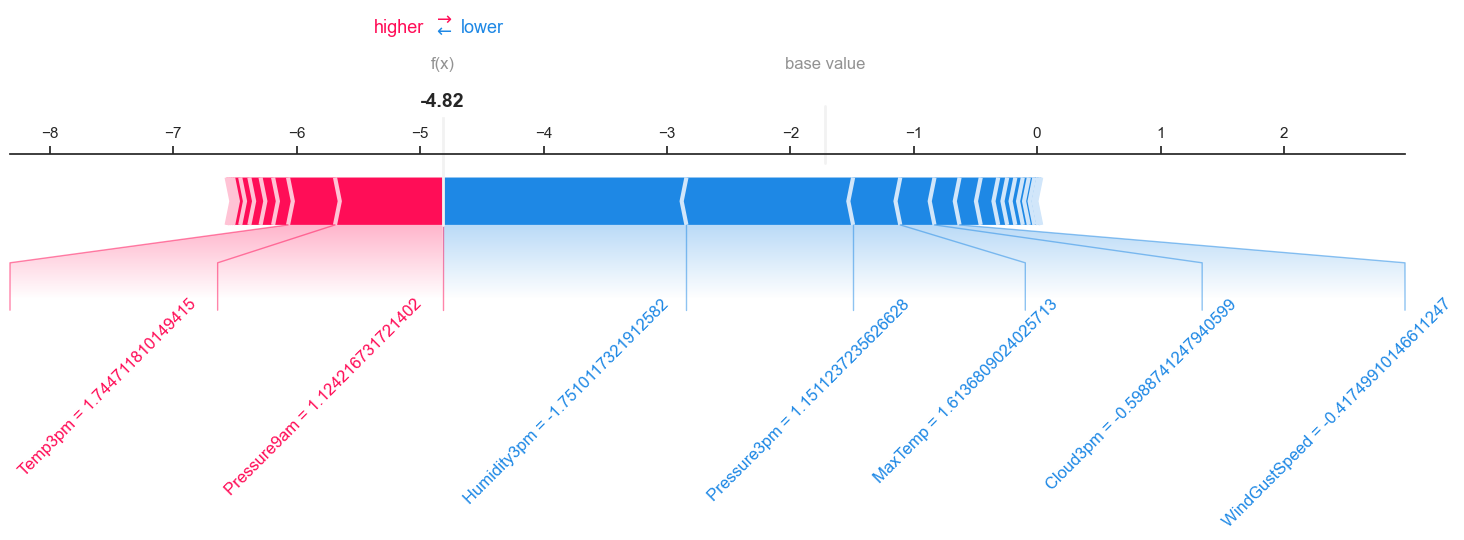

In [138]:
index=0
shap.force_plot(explainer.expected_value, shap_values[index], x_test_rlog.iloc[index],
                matplotlib=True, figsize=(18, 4),
                text_rotation=45)

Este gráfico muestra cómo cada característica influye en la predicción de una instancia específica.

In [139]:
# Crear el objeto shap
index = 0
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)

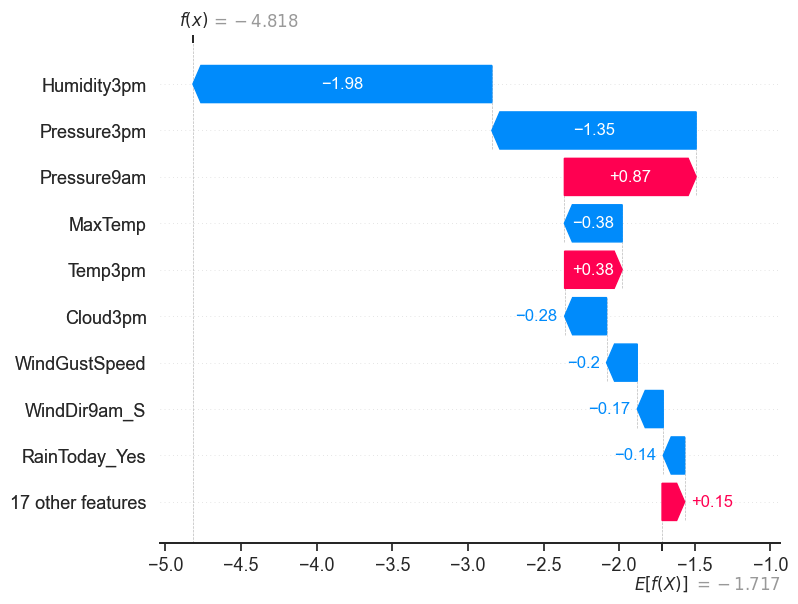

In [140]:
shap.plots.waterfall(explanation)

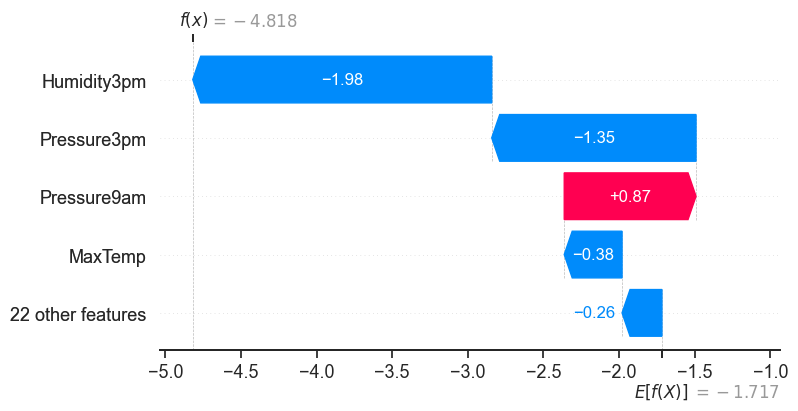

In [141]:
shap.plots.waterfall(explanation, max_display=5)

*Este grafico nos es util para ver las características individuales y como afectan la predicción para una instancia específica.*

Muestra cómo se construye la predicción de un modelo para una instancia específica (a nivel local) descomponiendo la contribución de cada característica.

Es un gráfico de cascada donde se muestra la contribución acumulada de cada característica comenzando desde el valor base hasta la predicción final. Cada barra representa una característica y su contribución positiva o negativa.

## Interpretabilidad global

Este gráfico muestra la distribución de los valores SHAP para cada característica en el conjunto de datos de prueba. Muestra la influencia de cada característica en las predicciones.

In [142]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value,feature_names=feature_names, data=x_test_rlog)

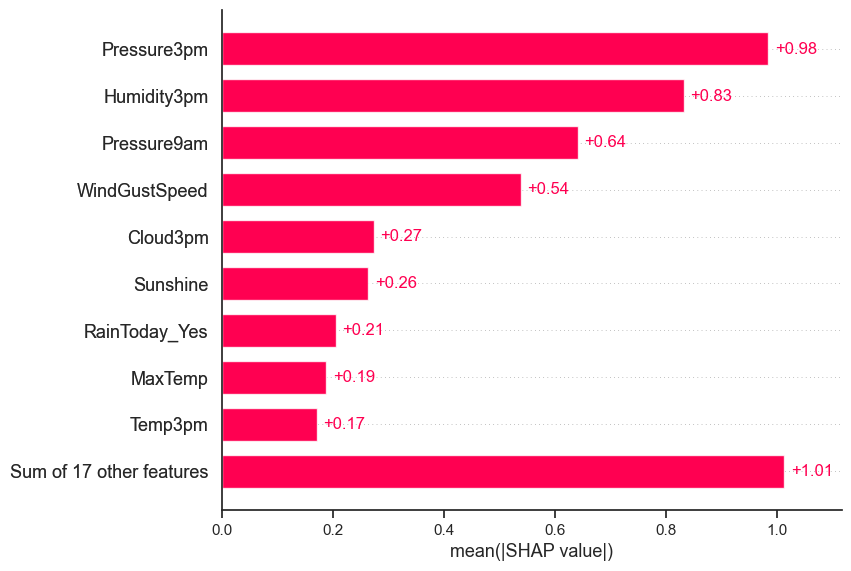

In [143]:
shap.plots.bar(explanation)

Este gráfico muestra la importancia promedio absoluta de los valores SHAP para cada característica, destacando las características más influyentes.

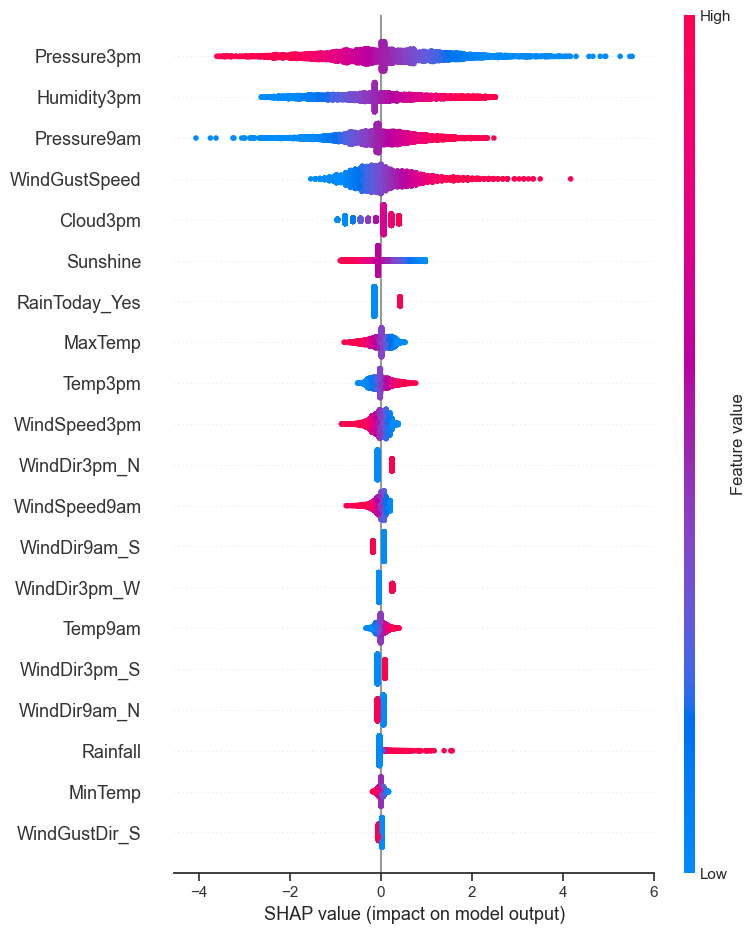

In [144]:
shap.summary_plot(shap_values, x_test_rlog, feature_names=x_test_rlog.columns)

Este gráfico muestra la distribución de los valores SHAP para cada característica en el conjunto de datos de prueba. Muestra la influencia de cada característica en las predicciones.

**Variables más importantes y menos importantes**

En el gráfico de resumen de SHAP,vemos  las características más importantes aparecerán en la parte superior del gráfico, es decir, *HUMIDITY3PM*, *PRESSURE3PM*, *PRESSURE9AM* Y *WINGUSTSPEED*.
En el gráfico de barras de importancia de características, las características con las barras más largas son las más importantes, es decir,  *HUMIDITY3PM* y *PRESSURE3PM*, *PRESSURE9AM* Y *WINGUSTSPEED*.

Podemos observar que estas caractiristicas, *HUMIDITY3PM* y *PRESSURE3PM*, *PRESSURE9AM* Y *WINGUSTSPEED*,  tienen una alta variabilidad en los valores SHAP, sugiriendo que tienen un impacto significativo en las predicciones.

# Red Neuronal

**K-folds**

Entrenar una red neuronal es muy costoso en términos de tiempo y recursos computacionales, especialmente si el modelo es grande y el conjunto de datos es grande. K-folds implica entrenar el modelo k veces, lo que multiplica este costo por k, es por ese motivo que no utilizaremos k-folds.

**Grid Search**
Puede ser extremadamente costoso en términos de tiempo y recursos, especialmente con muchos hiperparámetros y posibles valores para cada uno. Ademas no se adapta bien a problemas donde algunos hiperparámetros son más importantes que otros, es por ese motivo que no utilizaremos Grid Search.

**Random Search**

Tiende a ser más eficiente que Grid Search, ya que no explora todas las combinaciones, sino una muestra aleatoria. Sin embargo tiene una cobertura incompleta, ya que, no garantiza que se encuentren las mejores combinaciones de hiperparámetros, es por ese motivo que no utilizaremos Random Search.

**Optuna**

Utiliza técnicas avanzadas de optimización bayesiana para buscar de manera más inteligente en el espacio de hiperparámetros. Ademas tiende a encontrar buenos conjuntos de hiperparámetros más rápido que Grid Search y Random Search. Permite definir espacios de búsqueda complejos y estrategias de búsqueda sofisticadas. Tambien optuna es una excelente opción si tienes un espacio de hiperparámetros grande y complejo y buscas una optimización eficiente y efectiva. Son por estos motivos que utilizaremos Optuna.

## Regresión Lineal

In [154]:
class NeuralNetworkTensorFlow:
    """
        Este es un modelo simple con TensorFlow para resolver el mismo problema.
        En esta clase, (1) se construye el modelo.
        (2) Se define como se fitea el modelo
        (3) Y como se hacen las predicciones.
    """
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        """
            Construye el modelo
            Para construir el modelo es necesario una arquitectura, un optimizador y una función de pérdida.
            La arquitectura se construye con el método Sequential, que basicamente lo que hace es colocar
            secuencialmente las capas que uno desea.
            Las capas "Dense" son las fully connected dadas en clase.
            Se agrega una capa oculta que recibe un input de tamaño 2,
            y una capa de salida de regresión (una única neurona)
            En todos los casos se define una sigmoidea como función de activación (prueben otras!)

            El optimizador y la función de pérdida se especifican dentro de un compilador.

            Con este método, lo que se devuelve es el modelo sin entrenar, sería equivalente a escribir LinearRegression()
            en el caso de la regresión lineal.
        """

        model = tf.keras.Sequential([
            tf.keras.layers.Dense(2, activation='leaky_relu', input_shape=(26,)),
            tf.keras.layers.Dense(1, activation='leaky_relu')
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        ### imprimimos la cantidad de parámetros a modo de ejemplo
        print("n° de parámetros:", model.count_params())
        return model

    def fit(self, X, y, lr=0.1, epochs=20000):
        ### esta es la función donde se entrena el modelo, fijarse que hay un learning rate e iteraciones.
        ### la función que fitea devuelve una historia de pérdida, que vamos a guardar para graficar la evolución.
        X = np.array(X)
        y = np.array(y)
        history = self.model.fit(X, y, epochs=epochs, verbose=0)
        return history.history['loss']

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions

In [155]:
nn_tensorflow = NeuralNetworkTensorFlow()
loss_history = nn_tensorflow.fit(x_train_rl, y_train_rl, lr=1, epochs=100)

c:\Users\src4\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


n° de parámetros: 57


### Grafico de perdida NN & Regresion lineal

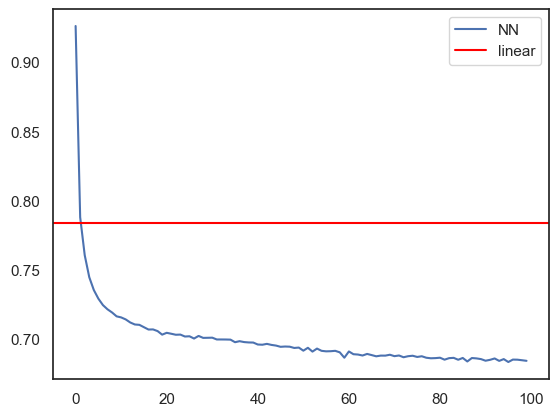

In [156]:
plt.plot(loss_history, label='NN')
plt.axhline(mse_train, color='red', label='linear',linestyle = '-')
plt.legend()
plt.show()

In [157]:
predictions = nn_tensorflow.predict(x_test_rl)
print("Predicciones:", predictions)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
Predicciones: [[-0.37077352]
 [-0.27657002]
 [-0.1592232 ]
 ...
 [-0.02998652]
 [-0.05883942]
 [-0.0499679 ]]


### Optuna

In [159]:
import optuna
from tensorflow.keras.optimizers import Adam

In [176]:
class NeuralNetworkOptuna:
    def __init__(self):
        self.model = None

    def build_model(self, trial):
        """
            Construye el modelo con hiperparámetros sugeridos por Optuna
        """
        n_hidden_layers = trial.suggest_int('n_hidden_layers', 1, 3)
        n_neurons = trial.suggest_int('n_neurons', 10, 50)
        activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'tanh'])
        optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])

        inputs = tf.keras.Input(shape=(26,))
        x = inputs
        for i in range(n_hidden_layers):
            x = tf.keras.layers.Dense(n_neurons, activation=activation)(x)
        outputs = tf.keras.layers.Dense(1, activation='leaky_relu')(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        return model


    def train_evaluate_model(self, trial, X_train, y_train, X_test, y_test):
        """
            Entrena y evalúa el modelo con los hiperparámetros sugeridos por Optuna
        """
        self.model = self.build_model(trial)
        self.model.fit(X_train, y_train, epochs=100, verbose=0)
        y_pred = self.model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        return mse

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions
    
    def objective(self, trial):
        """
            Función objetivo para Optuna
        """
        mse = self.train_evaluate_model(trial, x_train_rlog, y_train_encoded, x_test_rlog, y_test_encoded)
        return mse

In [166]:
#Crear estudio Optuna
study = optuna.create_study(direction='minimize')

[I 2024-06-08 21:32:53,359] A new study created in memory with name: no-name-c398352a-47ee-408e-967e-9921a136971a


In [181]:
#Instanciar la red neuronal
nn_optuna = NeuralNetworkOptuna()

In [168]:
#Optimizar hiperparámetros
study.optimize(nn_optuna.objective, n_trials=10)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-06-08 21:33:57,162] Trial 0 finished with value: 0.11014889257807178 and parameters: {'n_hidden_layers': 1, 'n_neurons': 43, 'activation': 'leaky_relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.11014889257807178.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step


[I 2024-06-08 21:34:55,792] Trial 1 finished with value: 0.11804967805785414 and parameters: {'n_hidden_layers': 2, 'n_neurons': 25, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.11014889257807178.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step


[I 2024-06-08 21:35:49,588] Trial 2 finished with value: 0.10700000128270509 and parameters: {'n_hidden_layers': 2, 'n_neurons': 17, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 2 with value: 0.10700000128270509.


177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-06-08 21:36:52,702] Trial 3 finished with value: 0.10870935579727896 and parameters: {'n_hidden_layers': 2, 'n_neurons': 23, 'activation': 'leaky_relu', 'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.10700000128270509.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


[I 2024-06-08 21:37:42,537] Trial 4 finished with value: 0.10729725453644162 and parameters: {'n_hidden_layers': 1, 'n_neurons': 37, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 2 with value: 0.10700000128270509.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-06-08 21:38:38,327] Trial 5 finished with value: 0.11126627747804785 and parameters: {'n_hidden_layers': 2, 'n_neurons': 21, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.10700000128270509.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-06-08 21:39:40,235] Trial 6 finished with value: 0.1444754554159218 and parameters: {'n_hidden_layers': 3, 'n_neurons': 45, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.10700000128270509.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-06-08 21:40:40,244] Trial 7 finished with value: 0.1328423322493429 and parameters: {'n_hidden_layers': 3, 'n_neurons': 45, 'activation': 'leaky_relu', 'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.10700000128270509.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-06-08 21:41:30,536] Trial 8 finished with value: 0.10679451649163851 and parameters: {'n_hidden_layers': 2, 'n_neurons': 36, 'activation': 'leaky_relu', 'optimizer': 'sgd'}. Best is trial 8 with value: 0.10679451649163851.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step


[I 2024-06-08 21:42:34,314] Trial 9 finished with value: 0.12329574566813775 and parameters: {'n_hidden_layers': 3, 'n_neurons': 28, 'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 8 with value: 0.10679451649163851.


In [169]:
#Obtener los mejores hiperparámetros
best_optuna_params = study.best_params
# Imprimir los mejores hiperparámetros
print('Best hyperparameters: ', best_optuna_params)

Best hyperparameters:  {'n_hidden_layers': 2, 'n_neurons': 36, 'activation': 'leaky_relu', 'optimizer': 'sgd'}


### Modelo con los hiperparametros optimizados

In [182]:
#Entrenar el modelo con los mejores hiperparámetros
nn_optuna.model = nn_optuna.build_model(study.best_trial)
nn_optuna.model.fit(x_train_rlog, y_train_encoded)

#Evaluar el modelo
optuna_mse = mean_squared_error(y_test_encoded, nn_optuna.model.predict(x_test_rlog))

706/706 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - loss: 0.1698
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step


In [183]:
optuna_mse

0.12426228468181406

In [184]:
predictions = nn_optuna.predict(x_test_rl)
print("Predicciones:", predictions)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
Predicciones: [[-0.07742136]
 [-0.07326636]
 [-0.09078937]
 ...
 [ 0.20652804]
 [ 0.29169798]
 [ 0.44798568]]


### SHAP

In [187]:
explainer = shap.DeepExplainer(nn_optuna.model, x_train_rl)
shap_values = explainer.shap_values(x_test_rl)


c:\Users\src4\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
c:\Users\src4\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_deep\deep_tf.py:155: UserWarning: You have provided over 5k background samples! For better performance consider using smaller random sample.
  warnings.warn("You have provided over 5k background samples! For better performance consider using smaller random sample.")


AttributeError: 'tuple' object has no attribute 'as_list'

## Regresión logística

In [145]:
# Crea una instancia de LabelEncoder
le = LabelEncoder()

# Ajusta y transforma los valores de y_train_rlog_copy
y_train_encoded = le.fit_transform(y_train_rlog.values.ravel())
y_test_encoded = le.fit_transform(y_test_rlog.values.ravel())

In [ ]:
# Crear la red neuronal
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train_rlog.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo y guardar la historia del entrenamiento
history = model.fit(x_train_rlog, y_train_encoded, validation_data=(x_test_rlog, y_test_encoded), epochs=20, batch_size=20)

Epoch 1/20
512/512 [==============================] - 2s 2ms/step - loss: 0.3556 - accuracy: 0.8475 - val_loss: 0.3484 - val_accuracy: 0.8528
Epoch 2/20
512/512 [==============================] - 1s 2ms/step - loss: 0.3259 - accuracy: 0.8630 - val_loss: 0.3445 - val_accuracy: 0.8485
Epoch 3/20
512/512 [==============================] - 1s 2ms/step - loss: 0.3179 - accuracy: 0.8678 - val_loss: 0.3410 - val_accuracy: 0.8532
Epoch 4/20
512/512 [==============================] - 1s 2ms/step - loss: 0.3109 - accuracy: 0.8674 - val_loss: 0.3374 - val_accuracy: 0.8521
Epoch 5/20
512/512 [==============================] - 1s 2ms/step - loss: 0.3070 - accuracy: 0.8718 - val_loss: 0.3339 - val_accuracy: 0.8548
Epoch 6/20
512/512 [==============================] - 1s 2ms/step - loss: 0.3018 - accuracy: 0.8724 - val_loss: 0.3455 - val_accuracy: 0.8579
Epoch 7/20
512/512 [==============================] - 1s 2ms/step - loss: 0.2970 - accuracy: 0.8739 - val_loss: 0.3402 - val_accuracy: 0.8552
Epoch 

In [155]:
# Evaluación del modelo en los datos de prueba
loss, accuracy = model.evaluate(x_test_rlog, y_test_encoded)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

80/80 [==============================] - 0s 1ms/step - loss: 0.3582 - accuracy: 0.8501
Test Loss: 0.3581532835960388
Test Accuracy: 0.8500978350639343


In [156]:
predictions_rlog = model.predict(x_test_rlog)
print("Predicciones:", predictions_rlog)

80/80 [==============================] - 0s 982us/step
Predicciones: [[0.00057392]
 [0.00113318]
 [0.00018158]
 ...
 [0.01397847]
 [0.06837331]
 [0.06890789]]


### Graficar la pérdida y la precisión a lo largo del entrenamiento

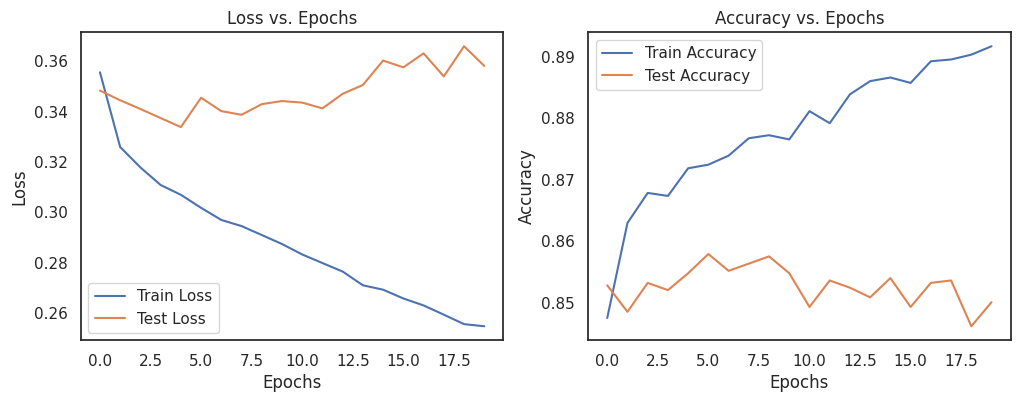

In [157]:
# Graficar la pérdida y la precisión a lo largo del entrenamiento
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.show()

### Optuna

In [158]:
import optuna
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam

In [159]:
def objective(trial):
    # Hiperparámetros a optimizar
    n_layers = trial.suggest_int('n_layers', 1, 3)
    n_units = trial.suggest_int('n_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Crear la red neuronal
    inputs = Input(shape=(x_train_rlog.shape[1],))
    x = Dense(n_units, activation='relu')(inputs)
    x = Dropout(dropout_rate)(x)

    for i in range(n_layers):
        x = Dense(n_units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo y guardar la historia del entrenamiento
    history = model.fit(x_train_rlog, y_train_encoded, validation_data=(x_test_rlog, y_test_encoded), epochs=20, batch_size=20, verbose=0)

    # Evaluación del modelo en los datos de prueba
    loss, accuracy = model.evaluate(x_test_rlog, y_test_encoded, verbose=0)
    return loss

In [161]:
# Crear el estudio de Optuna y empezar la optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-06-08 22:14:07,344] A new study created in memory with name: no-name-dce78e69-4079-4f4e-9080-d6acd548d909
[I 2024-06-08 22:14:24,523] Trial 0 finished with value: 0.34871137142181396 and parameters: {'n_layers': 1, 'n_units': 86, 'dropout_rate': 0.43247359834421484, 'learning_rate': 0.004443336288709724}. Best is trial 0 with value: 0.34871137142181396.
[I 2024-06-08 22:14:46,162] Trial 1 finished with value: 0.37952256202697754 and parameters: {'n_layers': 3, 'n_units': 116, 'dropout_rate': 0.36680480184260966, 'learning_rate': 0.009343365508125541}. Best is trial 0 with value: 0.34871137142181396.
[I 2024-06-08 22:15:03,034] Trial 2 finished with value: 0.34344482421875 and parameters: {'n_layers': 1, 'n_units': 78, 'dropout_rate': 0.03781185109668417, 'learning_rate': 0.0001944958373606896}. Best is trial 2 with value: 0.34344482421875.
[I 2024-06-08 22:15:23,894] Trial 3 finished with value: 0.34166979789733887 and parameters: {'n_layers': 3, 'n_units': 63, 'dropout_rate': 

In [162]:
# Imprimir los mejores hiperparámetros
print('Best hyperparameters: ', study.best_params)

Best hyperparameters:  {'n_layers': 3, 'n_units': 81, 'dropout_rate': 0.22551557050962912, 'learning_rate': 0.00031216833433607915}


### Modelo con los hiperparametros optimizados

In [188]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Hiperparámetros optimizados
n_layers = 3
n_units = 81
dropout_rate = 0.22551557050962912
learning_rate = 0.00031216833433607915

# Crear la red neuronal con los hiperparámetros optimizados
model = Sequential()
model.add(Dense(n_units, activation='relu', input_shape=(x_train_rlog.shape[1],)))
model.add(Dropout(dropout_rate))

for _ in range(n_layers - 1):
    model.add(Dense(n_units, activation='relu'))
    model.add(Dropout(dropout_rate))

model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo con la tasa de aprendizaje optimizada
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo y guardar la historia del entrenamiento
history = model.fit(x_train_rlog, y_train_encoded, validation_data=(x_test_rlog, y_test_encoded), epochs=20, batch_size=20)


c:\Users\src4\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7721 - loss: 0.4779 - val_accuracy: 0.8453 - val_loss: 0.3626
Epoch 2/20
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8345 - loss: 0.3776 - val_accuracy: 0.8536 - val_loss: 0.3520
Epoch 3/20
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8409 - loss: 0.3721 - val_accuracy: 0.8545 - val_loss: 0.3494
Epoch 4/20
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8469 - loss: 0.3634 - val_accuracy: 0.8550 - val_loss: 0.3469
Epoch 5/20
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8421 - loss: 0.3618 - val_accuracy: 0.8545 - val_loss: 0.3482
Epoch 6/20
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8441 - loss: 0.3578 - val_accuracy: 0.8541 - val_loss: 0.3458
Epoch 7/20
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8531 - loss: 0.3497 - val_accuracy: 0.8573 - val_loss: 0.3460
Epoch 8/20
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8423 - loss: 0.3635 - 

### SHAP

In [153]:
import shap

#Crear el objeto explainer
explainer = shap.KernelExplainer(model.predict, x_train_rlog)

#Calcular las contribuciones SHAP para las instancias de entrenamiento
shap_values = explainer.shap_values(x_train_rlog)


706/706 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Using 22590 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/22590 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


KeyboardInterrupt: 

### Metricas


In [189]:
# Obtener las predicciones del modelo
y_pred = model.predict(x_test_rlog)

# Convertir las probabilidades a etiquetas binarias (0 o 1
y_pred_binary = (y_pred > 0.5).astype(int)

# Importar métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calcular métricas
accuracy = accuracy_score(y_test_encoded, y_pred_binary)
precision = precision_score(y_test_encoded, y_pred_binary)
recall = recall_score(y_test_encoded, y_pred_binary)
f1 = f1_score(y_test_encoded, y_pred_binary)
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Mostrar las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.8553704360155973
Precision: 0.7609921082299888
Recall: 0.527756059421423
F1 Score: 0.6232686980609419
Confusion Matrix:
[[4151  212]
 [ 604  675]]
